# Biometric Format Analysis
Automated within-subject and mixed-model testing for biometric metrics.

## Setup
Import shared utilities and configure plotting defaults to mirror the enjoyment workflow.

In [ ]:
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import ticker
from scipy import stats

from wbdlib import (
    COLOR_MAP,
    FORM_ORDER,
    PlotDataExporter,
    format_value,
    format_p_value,
    print_long_short_summary_value,
    register_boxplot_with_means,
    reshape_biometric_long,
    to_percent_table,
)

PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "analysis":
    PROJECT_ROOT = PROJECT_ROOT.parent

RESULTS_PATH = PROJECT_ROOT / "results"
PLOT_EXPORT_ROOT = RESULTS_PATH / "plot_data_exports"
UV_BIOMETRIC_PATH = RESULTS_PATH / "uv_biometric_full.csv"

BIOMETRIC_PLOT_EXPORTER = PlotDataExporter(
    base_path=PLOT_EXPORT_ROOT,
    notebook_name="analysis_biometric",
    static_metadata={
        "notebook": "analysis_biometric",
        "source": "analysis_biometric.ipynb",
    },
)

TARGET_TITLES: List[str] = [
    "Mad Max",
    "The Town",
    "Abbott Elementary",
]
TARGET_SENSORS: List[str] = ["EEG", "ET", "FAC", "GSR"]

warnings.filterwarnings("ignore", message=".*ConvergenceWarning.*")

plt.rcParams["font.family"] = "Century Gothic"
plt.rcParams["font.sans-serif"] = ["Century Gothic"]
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams.update({"font.size": 10})

sns.set_theme(style="whitegrid", rc={"font.family": "Century Gothic", "font.sans-serif": ["Century Gothic"]})
register_boxplot_with_means()

print(f"Plot exports path: {PLOT_EXPORT_ROOT / 'analysis_biometric'}")

In [ ]:
# Load the unified biometric extract and preview its shape.
uv_biometric = pd.read_csv(UV_BIOMETRIC_PATH)
uv_biometric.shape
# Apply canonical spelling corrections for Abbott Elementary across columns and string fields.
uv_biometric.columns = [
    column.replace("Abbot ", "Abbott ")
    for column in uv_biometric.columns
]
object_columns = uv_biometric.select_dtypes(include="object").columns
if len(object_columns):
    uv_biometric[object_columns] = uv_biometric[object_columns].apply(
        lambda series: series.str.replace("Abbot ", "Abbott ", regex=False)
    )

uv_biometric.filter(regex="Abbott", axis=1).columns[:5]
# Create long-form tables restricted to the target titles and sensors.
biometric_long = reshape_biometric_long(
    uv_biometric,
    sensors=TARGET_SENSORS,
    titles=TARGET_TITLES,
    dropna=True,
)

biometric_long.to_csv(RESULTS_PATH / "uv_biometric_long.csv", index=False)

biometric_long["title"] = pd.Categorical(
    biometric_long["title"],
    categories=TARGET_TITLES,
    ordered=True,
)
biometric_long.head()

respondent_id   form     title sensor metric  stat     value
0    005_10.csv  Short  The Town    FAC  Anger  Mean  0.000507
1    004_15.csv  Short  The Town    FAC  Anger  Mean  0.000000
2    003_37.csv  Short  The Town    FAC  Anger  Mean  0.000000
3    002_39.csv  Short  The Town    FAC  Anger  Mean  0.000000
4    004_56.csv  Short  The Town    FAC  Anger  Mean  0.000000

## Data Loading
Read the biometric long-form dataset and normalise key columns for downstream analysis.

In [ ]:
PROJECT_ROOT = Path.cwd().parent
DATA_PATH = PROJECT_ROOT / "results" / "uv_biometric_long.csv"

biometric_long = pd.read_csv(DATA_PATH)
biometric_long["respondent_id"] = biometric_long["respondent_id"].astype(str)
biometric_long["form"] = pd.Categorical(biometric_long["form"], categories=FORM_ORDER, ordered=True)
biometric_long["title"] = biometric_long["title"].astype(str)
biometric_long["sensor"] = biometric_long["sensor"].astype(str)
biometric_long["metric"] = biometric_long["metric"].astype(str)
biometric_long["stat"] = biometric_long["stat"].astype(str)

FAC_EMOTION_COMPONENTS: Tuple[str, ...] = (
    "Anger",
    "Confusion",
    "Disgust",
    "Fear",
    "Joy",
    "Sadness",
    "Sentimentality",
    "Surprise",
)

fac_emotion_base = biometric_long.loc[
    (biometric_long["sensor"].str.upper() == "FAC")
    & (biometric_long["metric"].isin(FAC_EMOTION_COMPONENTS))
    & (biometric_long["stat"].str.upper() == "AUC")
].copy()

if fac_emotion_base.empty:
    print("FAC Emotion composite: no component rows found; skipping metric construction.")
else:
    fac_emotion_base["value"] = pd.to_numeric(fac_emotion_base["value"], errors="coerce")
    component_keys = [metric.casefold() for metric in FAC_EMOTION_COMPONENTS]
    fac_emotion_components = (
        fac_emotion_base.assign(
            metric_norm=fac_emotion_base["metric"].str.strip().str.casefold()
        )
        .pivot_table(
            index=["respondent_id", "form", "title"],
            columns="metric_norm",
            values="value",
            aggfunc="mean",
        )
        .reindex(columns=component_keys)
    )
    fac_emotion_components["fac_emotion_sum"] = fac_emotion_components.sum(
        axis=1, min_count=len(component_keys)
    )
    fac_emotion_long = (
        fac_emotion_components["fac_emotion_sum"].dropna().rename("value").reset_index()
    )
    fac_emotion_long["sensor"] = "FAC_EMOTION"
    fac_emotion_long["metric"] = "EmotionComposite"
    fac_emotion_long["stat"] = "AUC_SUM"
    fac_emotion_long = fac_emotion_long.reindex(
        columns=biometric_long.columns, fill_value=np.nan
    )
    biometric_long = pd.concat([biometric_long, fac_emotion_long], ignore_index=True)
    print(f"FAC Emotion composite rows appended: {fac_emotion_long.shape[0]:,}")

sensor_overview = (
    biometric_long.groupby(["sensor", "metric", "stat"], observed=True)["respondent_id"].count()
    .rename("n_records")
    .reset_index()
)

SUMMARY_TABLE_RECORDS: List[Dict[str, object]] = []
POSTHOC_TABLE_RECORDS: List[Dict[str, object]] = []

biometric_long.head()

FAC Emotion composite rows appended: 165


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\3111352625.py:38: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(


respondent_id   form     title sensor metric  stat     value
0    005_10.csv  Short  The Town    FAC  Anger  Mean  0.000507
1    004_15.csv  Short  The Town    FAC  Anger  Mean  0.000000
2    003_37.csv  Short  The Town    FAC  Anger  Mean  0.000000
3    002_39.csv  Short  The Town    FAC  Anger  Mean  0.000000
4    004_56.csv  Short  The Town    FAC  Anger  Mean  0.000000

## Helper Functions
Reusable utilities for outlier handling, statistical tests, summaries, and consistent visual formatting.

In [ ]:


def remove_iqr_outliers(
    frame: pd.DataFrame,
    value_col: str = "value",
    group_col: str = "form",
    iqr_multiplier: float = 1.5,
) -> Tuple[pd.DataFrame, Dict[str, int]]:
    """Drop per-group outliers using the IQR rule and report removals."""
    if frame.empty:
        return frame.copy(), {}

    quantiles = (
        frame.groupby(group_col, observed=True)[value_col]
        .quantile([0.25, 0.75])
        .unstack(level=-1)
        .rename(columns={0.25: "q1", 0.75: "q3"})
    )

    quantiles["iqr"] = quantiles["q3"] - quantiles["q1"]
    quantiles["lower"] = quantiles["q1"] - iqr_multiplier * quantiles["iqr"]
    quantiles["upper"] = quantiles["q3"] + iqr_multiplier * quantiles["iqr"]

    bounds = quantiles[["lower", "upper"]]
    joined = frame.join(bounds, on=group_col)
    mask = joined[value_col].between(joined["lower"], joined["upper"], inclusive="both")

    filtered = frame.loc[mask].copy()
    removal_summary = (
        frame.assign(_removed=~mask)
        .groupby(group_col, observed=True)["_removed"]
        .sum()
        .astype(int)
        .to_dict()
    )

    return filtered, removal_summary


def prepare_paired_samples(
    frame: pd.DataFrame,
    id_col: str = "respondent_id",
    form_col: str = "form",
    value_col: str = "value",
) -> pd.DataFrame:
    """Pivot long format into paired wide form (Short/Long columns)."""
    if frame.empty:
        return pd.DataFrame(columns=FORM_ORDER)

    pivot = (
        frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")
        .reindex(columns=FORM_ORDER)
    )
    return pivot.dropna(subset=FORM_ORDER)


def paired_t_test(paired: pd.DataFrame) -> Dict[str, float]:
    """Run a paired two-sided t-test and summarise key statistics."""
    if paired.empty or any(col not in paired for col in FORM_ORDER):
        return {
            "t_stat": np.nan,
            "p_value": np.nan,
            "n_pairs": 0,
            "long_mean": np.nan,
            "short_mean": np.nan,
            "mean_diff": np.nan,
        }

    long_values = paired["Long"].astype(float)
    short_values = paired["Short"].astype(float)
    valid = long_values.notna() & short_values.notna()
    if not valid.any():
        return {
            "t_stat": np.nan,
            "p_value": np.nan,
            "n_pairs": 0,
            "long_mean": np.nan,
            "short_mean": np.nan,
            "mean_diff": np.nan,
        }

    statistic, p_two_sided = stats.ttest_rel(long_values[valid], short_values[valid], nan_policy="omit")
    long_mean = long_values[valid].mean()
    short_mean = short_values[valid].mean()

    return {
        "t_stat": statistic,
        "p_value": p_two_sided,
        "n_pairs": int(valid.sum()),
        "long_mean": long_mean,
        "short_mean": short_mean,
        "mean_diff": long_mean - short_mean,
    }


def make_form_indicator(frame: pd.DataFrame, form_col: str = "form") -> pd.Series:
    """Encode Long as 1, Short as 0 for mixed-model usage."""
    return (frame[form_col] == "Long").astype(int)


def fit_mixed_model(
    frame: pd.DataFrame,
    value_col: str = "value",
    group_col: str = "title",
    form_indicator: str = "form_long",
) -> Dict[str, float]:
    """Fit a mixed model with title as random intercept; return coefficient stats."""
    if frame.empty or frame[group_col].nunique() <= 1:
        return {"coef": np.nan, "se": np.nan, "z_value": np.nan, "p_value": np.nan}

    try:
        model = smf.mixedlm(f"{value_col} ~ {form_indicator}", data=frame, groups=frame[group_col])
        result = model.fit(reml=False, method="lbfgs", disp=False)
        coef = result.params.get(form_indicator, np.nan)
        se = result.bse.get(form_indicator, np.nan)
        if not np.isfinite(coef) or not np.isfinite(se) or se == 0:
            raise ValueError("Invalid coefficient or standard error")
        z_value = coef / se
        p_two_sided = 2 * stats.norm.sf(np.abs(z_value))
        return {
            "coef": coef,
            "se": se,
            "z_value": z_value,
            "p_value": p_two_sided,
            "result": result,
        }
    except Exception as exc:
        return {"coef": np.nan, "se": np.nan, "z_value": np.nan, "p_value": np.nan, "error": str(exc)}


def title_level_comparisons(frame: pd.DataFrame) -> pd.DataFrame:
    """Compute per-title descriptive stats and Welch t-tests."""
    rows = []
    for title, subset in frame.groupby("title", observed=True):
        long_values = subset.loc[subset["form"] == "Long", "value"].astype(float)
        short_values = subset.loc[subset["form"] == "Short", "value"].astype(float)
        if long_values.empty or short_values.empty:
            continue
        t_stat, p_two = stats.ttest_ind(long_values, short_values, equal_var=False, nan_policy="omit")
        rows.append({
            "title": title,
            "long_mean": long_values.mean(),
            "short_mean": short_values.mean(),
            "mean_diff": long_values.mean() - short_values.mean(),
            "t_stat": t_stat,
            "p_value": p_two,
            "n_long": int(long_values.count()),
            "n_short": int(short_values.count()),
        })
    return pd.DataFrame(rows)


def _format_mean(value: float, decimals: int = 1) -> str:
    """Format mean values as percentages when bounded, otherwise raw."""
    if pd.isna(value):
        return "NA"
    if 0 <= value <= 1:
        return format_value(value, decimals=decimals)
    return f"{value:.{decimals}f}"


def plot_part1_distributions(
    frame: pd.DataFrame,
    metric_label: str,
    value_label: str,
    annotation: str,
    decimals: int = 1,
) -> None:
    """Render box/strip and bar charts for Part 1."""
    palette = {form: COLOR_MAP.get(form, "#666666") for form in FORM_ORDER}

    fig, ax = plt.subplots(figsize=(8, 4))
    fig.subplots_adjust(bottom=0.28, right=0.78)
    sns.boxplot(data=frame, x="form", y="value", order=FORM_ORDER, palette=palette, ax=ax)
    sns.stripplot(
        data=frame,
        x="form",
        y="value",
        order=FORM_ORDER,
        palette={form: "#3a3a3a" for form in FORM_ORDER},
        dodge=False,
        size=3,
        alpha=0.5,
        ax=ax,
        legend=False,
    )
    means = frame.groupby("form", observed=True)["value"].mean()
    #_add_mean_labels(ax, means, decimals=decimals)
    ax.set_xlabel("Format")
    ax.set_ylabel(value_label)
    ax.set_title(metric_label)
    ax.text(0.0, -0.27, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
    ax.set_xticklabels([f"{form}" for form in FORM_ORDER])
    plt.show()

    bar_data = (
        frame.groupby("form", observed=True)["value"].mean().reindex(FORM_ORDER)
        .rename("mean_value")
        .reset_index()
    )
    fig_bar, ax_bar = plt.subplots(figsize=(8, 3.4))
    fig_bar.subplots_adjust(bottom=0.28, right=0.78)
    sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)
    for idx, row in bar_data.iterrows():
        ax_bar.text(idx, row["mean_value"], _format_mean(row["mean_value"], decimals=decimals), ha="center", va="bottom", fontsize=9, fontweight="bold")
    ax_bar.set_xlabel("Format")
    ax_bar.set_ylabel(value_label)
    ax_bar.set_title(f"Mean {metric_label}")
    ax_bar.text(0.0, -0.3, annotation, transform=ax_bar.transAxes, ha="left", va="top", fontsize=9)
    plt.show()


def plot_part2_boxplot(
    frame: pd.DataFrame,
    metric_label: str,
    value_label: str,
    annotation: str,
    decimals: int = 1,
) -> None:
    """Render mixed-model distribution plot with means annotated."""
    palette = {form: COLOR_MAP.get(form, "#666666") for form in FORM_ORDER}
    titles = list(frame["title"].dropna().unique())
    if not titles:
        return

    fig, ax = plt.subplots(figsize=(8, 4))
    fig.subplots_adjust(bottom=0.3, right=0.78)
    sns.boxplot(
        data=frame,
        x="title",
        y="value",
        hue="form",
        order=titles,
        hue_order=FORM_ORDER,
        palette=palette,
        ax=ax,
        annotate=False,
    )
    sns.stripplot(
        data=frame,
        x="title",
        y="value",
        hue="form",
        order=titles,
        hue_order=FORM_ORDER,
        palette={form: "#3a3a3a" for form in FORM_ORDER},
        dodge=True,
        size=3,
        alpha=0.5,
        ax=ax,
    )
    title_means = frame.groupby(["title", "form"], observed=True)["value"].mean().unstack("form")
    for idx, title in enumerate(titles):
        for offset, form in enumerate(FORM_ORDER):
            mean_val = title_means.get(form, pd.Series(dtype=float)).get(title)
            if pd.isna(mean_val):
                continue
            jitter = (offset - 0.5) * 0.2
            ax.text(idx + jitter, mean_val, _format_mean(mean_val, decimals=decimals), ha="center", va="bottom", fontsize=8, fontweight="bold")
    ax.set_xlabel("Title")
    ax.set_ylabel(value_label)
    ax.set_title(metric_label)
    ax.text(0.0, -0.32, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title="Format", loc="center left", bbox_to_anchor=(1.02, 0.5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins="auto", prune="lower"))
    plt.show()


def build_part1_annotation(paired_stats: Dict[str, float], outliers: Dict[str, int]) -> str:
    """Create the annotation string for Part 1 visuals."""
    items = []
    p_value = paired_stats.get("p_value")
    if isinstance(p_value, (int, float)) and np.isfinite(p_value):
        items.append(format_p_value(p_value))
    n_pairs = paired_stats.get("n_pairs", 0)
    if n_pairs:
        items.append(f"n_pairs={n_pairs}")
    removed_bits = [f"{form.lower()}={count}" for form, count in outliers.items() if count]
    if removed_bits:
        items.append("outliers removed: " + ", ".join(removed_bits))
    return "; ".join(items) if items else ""


def build_part2_annotation(mixed_stats: Dict[str, float], outliers: Dict[str, int]) -> str:
    """Create the annotation string for Part 2 visuals."""
    items = []
    coef = mixed_stats.get("coef")
    z_value = mixed_stats.get("z_value")
    p_value = mixed_stats.get("p_value")
    if isinstance(coef, (int, float)) and np.isfinite(coef):
        items.append(f"coef={coef:.3f}")
    if isinstance(z_value, (int, float)) and np.isfinite(z_value):
        items.append(f"z={z_value:.2f}")
    if isinstance(p_value, (int, float)) and np.isfinite(p_value):
        items.append(format_p_value(p_value))
    removed_bits = [f"{form.lower()}={count}" for form, count in outliers.items() if count]
    if removed_bits:
        items.append("outliers removed: " + ", ".join(removed_bits))
    return "; ".join(items) if items else ""


def render_part1_summary(
    label: str,
    paired_stats: Dict[str, float],
    outliers: Dict[str, int],
) -> None:
    """Print the one-line Part 1 summary mirroring the reference notebook."""
    extra_bits = []
    p_value = paired_stats.get("p_value")
    if isinstance(p_value, (int, float)) and np.isfinite(p_value):
        extra_bits.append(format_p_value(p_value))
    n_pairs = paired_stats.get("n_pairs", 0)
    if n_pairs:
        extra_bits.append(f"n_pairs={n_pairs}")
    removed_bits = [f"{form.lower()}={count}" for form, count in outliers.items() if count]
    if removed_bits:
        extra_bits.append("outliers removed: " + ", ".join(removed_bits))
    extra_note = ", ".join(extra_bits) if extra_bits else None
    print_long_short_summary_value(
        label=label,
        long_mean=paired_stats.get("long_mean", np.nan),
        short_mean=paired_stats.get("short_mean", np.nan),
        extra_note=extra_note,
    )


def render_part2_summaries(
    metric_label: str,
    title_stats: pd.DataFrame,
    mixed_stats: Dict[str, float],
) -> None:
    """Print per-title and overall summaries for Part 2."""
    if title_stats.empty:
        print(f"{metric_label}: No title-level data available after filtering.")
        return

    overall_p = mixed_stats.get("p_value")
    overall_note = None
    if isinstance(overall_p, (int, float)) and np.isfinite(overall_p):
        overall_note = f"overall mixed-model {format_p_value(overall_p)}"

    for _, row in title_stats.iterrows():
        extra_bits = []
        if isinstance(row["p_value"], (int, float)) and np.isfinite(row["p_value"]):
            extra_bits.append(format_p_value(row["p_value"]))
        extra_bits.append(f"n_long={row['n_long']}")
        extra_bits.append(f"n_short={row['n_short']}")
        if overall_note:
            extra_bits.append(overall_note)
        extra_note = ", ".join(extra_bits)
        print_long_short_summary_value(
            label=f"{metric_label} – {row['title']}",
            long_mean=row["long_mean"],
            short_mean=row["short_mean"],
            extra_note=extra_note,
        )

    combined_long = title_stats["long_mean"].mean()
    combined_short = title_stats["short_mean"].mean()
    sample_note = f"n_long={int(title_stats['n_long'].sum())}, n_short={int(title_stats['n_short'].sum())}"
    extra_bits = [sample_note]
    if overall_note:
        extra_bits.append(overall_note)
    print_long_short_summary_value(
        label=f"{metric_label} (Overall)",
        long_mean=combined_long,
        short_mean=combined_short,
        extra_note=", ".join(extra_bits),
    )

In [ ]:
def _coerce_numeric_metadata(value: object) -> float | None:
    """Convert numpy-backed numbers to native floats when possible."""
    if isinstance(value, (int, float, np.generic)):
        if pd.isna(value):
            return None
        numeric_value = float(value)
        if not np.isfinite(numeric_value):
            return None
        return numeric_value
    return None


def _normalize_export_title(raw_title: str) -> str:
    cleaned = raw_title.replace("\n", " ")
    return " ".join(cleaned.split())


def _export_metric_bundle(
    *,
    part: str,
    sensor_name: str,
    metric_name: str,
    stat_name: str,
    value_label: str,
    frames: List[Tuple[str, pd.DataFrame]],
    annotation: str | None = None,
    extra_metadata: Dict[str, object] | None = None,
    section_label: str | None = None,
) -> None:
    """Write prepared frames to disk using the shared biometric exporter."""

    exporter = globals().get("BIOMETRIC_PLOT_EXPORTER")
    if not exporter or not frames:
        return

    prepared_frames: List[Tuple[str, pd.DataFrame]] = []
    for sheet_name, frame in frames:
        if frame is None or not isinstance(frame, pd.DataFrame):
            continue
        cleaned = frame.reset_index(drop=True)
        if value_label and "value" in cleaned.columns:
            cleaned = cleaned.rename(columns={"value": value_label})
        prepared_frames.append((sheet_name, cleaned))

    if not prepared_frames:
        return

    metadata: Dict[str, object] = {
        "sensor": sensor_name,
        "metric": metric_name,
        "stat": stat_name,
        "value_label": value_label,
    }
    if annotation:
        metadata["annotation"] = annotation
    if extra_metadata:
        normalized: Dict[str, object] = {}
        for key, value in extra_metadata.items():
            numeric_value = _coerce_numeric_metadata(value)
            normalized[key] = numeric_value if numeric_value is not None else value
        metadata.update(normalized)

    normalized_title = _normalize_export_title(f"{sensor_name} – {metric_name} ({stat_name})")
    exporter(
        title=normalized_title,
        part=part,
        data_frames=prepared_frames,
        section=section_label or sensor_name,
        metadata=metadata,
        folder_parts=None,
    )

In [ ]:
def run_metric_analysis(
    sensor_name: str,
    metric_name: str,
    stat_name: str,
    data: pd.DataFrame,
) -> None:
    """Execute Part 1 and Part 2 analysis for a single sensor/metric/stat combination."""
    global SUMMARY_TABLE_RECORDS, POSTHOC_TABLE_RECORDS

    metric_mask = (data["metric"] == metric_name) & (data["stat"] == stat_name)
    subset = data.loc[metric_mask, ["respondent_id", "form", "title", "value"]].copy()
    if subset.empty or subset["form"].nunique() < 2:
        print(f"{sensor_name} – {metric_name} ({stat_name}): insufficient data after filtering forms.")
        return

    filtered, removed = remove_iqr_outliers(subset)
    removed = {form: int(removed.get(form, 0)) for form in FORM_ORDER}
    removal_summary_df = pd.DataFrame([removed])
    if filtered.empty or filtered["form"].nunique() < 2:
        print(f"{sensor_name} – {metric_name} ({stat_name}): all records removed as outliers.")
        return

    use_percent = False  # metrics are already on sensor-specific scales
    decimals = 1 if use_percent else 2
    metric_label = f"{sensor_name} – {metric_name} ({stat_name})"
    value_label = f"{metric_name} ({stat_name})"

    # Part 1 – Within-subject paired t-test
    paired = prepare_paired_samples(filtered)
    paired_stats = paired_t_test(paired)
    if paired_stats["n_pairs"] < 2:
        print(f"{metric_label}: insufficient paired observations for Part 1 (n_pairs={paired_stats['n_pairs']}).")
    else:
        part1_table = pd.DataFrame([
            {
                "Long mean": paired_stats["long_mean"],
                "Short mean": paired_stats["short_mean"],
                "Difference": paired_stats["mean_diff"],
                "t_stat": paired_stats["t_stat"],
                "p_value": paired_stats["p_value"],
                "n_pairs": paired_stats["n_pairs"],
            }
        ])
        if use_percent:
            display(to_percent_table(part1_table, ["Long mean", "Short mean", "Difference"], decimals=decimals))
        else:
            display(part1_table)
        annotation = build_part1_annotation(paired_stats, removed)
        SUMMARY_TABLE_RECORDS.append(
            {
                "part": "Part 1",
                "sensor": sensor_name,
                "metric": metric_name,
                "stat": stat_name,
                "long_mean": paired_stats["long_mean"],
                "short_mean": paired_stats["short_mean"],
                "difference": paired_stats["mean_diff"],
                "t_stat": paired_stats["t_stat"],
                "p_value": paired_stats["p_value"],
                "n_pairs": paired_stats["n_pairs"],
                "removed_short": int(removed.get("Short", 0)),
                "removed_long": int(removed.get("Long", 0)),
            }
        )
        plot_part1_distributions(filtered, f"{metric_label}", value_label, annotation, decimals=decimals)
        render_part1_summary(f"{metric_label} – Part 1", paired_stats, removed)
        part1_bar_data = (
            filtered.groupby("form", observed=True)["value"].mean().reindex(FORM_ORDER)
            .rename("mean_value")
            .reset_index()
        )
        _export_metric_bundle(
            part="Part 1",
            sensor_name=sensor_name,
            metric_name=metric_name,
            stat_name=stat_name,
            value_label=value_label,
            frames=[
                ("data", filtered.copy()),
                ("paired_samples", paired.reset_index()),
                ("paired_summary", part1_table),
                ("bar_means", part1_bar_data),
                ("outlier_summary", removal_summary_df),
            ],
            annotation=annotation,
            extra_metadata={
                "t_stat": paired_stats.get("t_stat"),
                "p_value": paired_stats.get("p_value"),
                "n_pairs": paired_stats.get("n_pairs"),
                "removed_short": removed.get("Short", 0),
                "removed_long": removed.get("Long", 0),
            },
            section_label=f"{sensor_name} – Part 1",
        )

    # Part 2 – Mixed model by title
    mixed_frame = filtered.copy()
    mixed_frame["form_long"] = make_form_indicator(mixed_frame)
    if mixed_frame["title"].nunique() < 2 or mixed_frame["form"].nunique() < 2:
        print(f"{metric_label}: insufficient diversity for mixed-model Part 2.")
        return

    mixed_stats = fit_mixed_model(mixed_frame)
    title_stats = title_level_comparisons(mixed_frame)
    if title_stats.empty:
        print(f"{metric_label}: no title-level comparisons available.")
        return

    for row in title_stats.to_dict(orient="records"):
        POSTHOC_TABLE_RECORDS.append(
            {
                "part": "Part 2",
                "sensor": sensor_name,
                "metric": metric_name,
                "stat": stat_name,
                "title": str(row["title"]),
                "long_mean": float(row["long_mean"]) if pd.notna(row["long_mean"]) else np.nan,
                "short_mean": float(row["short_mean"]) if pd.notna(row["short_mean"]) else np.nan,
                "difference": float(row["mean_diff"]) if pd.notna(row["mean_diff"]) else np.nan,
                "t_stat": float(row["t_stat"]) if pd.notna(row["t_stat"]) else np.nan,
                "p_value": float(row["p_value"]) if pd.notna(row["p_value"]) else np.nan,
                "n_long": int(row["n_long"]) if pd.notna(row["n_long"]) else 0,
                "n_short": int(row["n_short"]) if pd.notna(row["n_short"]) else 0,
                "overall_p_value": mixed_stats.get("p_value"),
            }
        )

    long_overall = mixed_frame.loc[mixed_frame["form"] == "Long", "value"].dropna()
    short_overall = mixed_frame.loc[mixed_frame["form"] == "Short", "value"].dropna()
    SUMMARY_TABLE_RECORDS.append(
        {
            "part": "Part 2",
            "sensor": sensor_name,
            "metric": metric_name,
            "stat": stat_name,
            "long_mean": float(long_overall.mean()) if not long_overall.empty else np.nan,
            "short_mean": float(short_overall.mean()) if not short_overall.empty else np.nan,
            "difference": float(long_overall.mean() - short_overall.mean()) if not long_overall.empty and not short_overall.empty else np.nan,
            "coef": mixed_stats.get("coef"),
            "z_value": mixed_stats.get("z_value"),
            "p_value": mixed_stats.get("p_value"),
            "n_titles": int(mixed_frame["title"].nunique()),
            "n_observations": int(mixed_frame.shape[0]),
            "n_long": int(long_overall.count()),
            "n_short": int(short_overall.count()),
            "removed_short": int(removed.get("Short", 0)),
            "removed_long": int(removed.get("Long", 0)),
        }
    )

    title_display = title_stats.rename(
        columns={
            "title": "Title",
            "long_mean": "Long mean",
            "short_mean": "Short mean",
            "mean_diff": "Difference",
            "t_stat": "t_stat",
            "p_value": "p_value",
            "n_long": "n_long",
            "n_short": "n_short",
        }
    )
    if use_percent:
        display(to_percent_table(title_display, ["Long mean", "Short mean", "Difference"], decimals=decimals))
    else:
        display(title_display)
    annotation2 = build_part2_annotation(mixed_stats, removed)
    plot_part2_boxplot(mixed_frame, f"{metric_label}", value_label, annotation2, decimals=decimals)
    render_part2_summaries(f"{metric_label} – Part 2", title_stats, mixed_stats)

    model_result = mixed_stats.get("result")
    model_params_df: Optional[pd.DataFrame] = None
    if model_result is not None:
        model_params_df = pd.DataFrame(
            {
                "parameter": model_result.params.index,
                "coefficient": model_result.params.values,
                "std_error": model_result.bse.values,
                "p_value": model_result.pvalues.values,
            }
        )

    part2_frames: List[Tuple[str, pd.DataFrame]] = [
        ("data", mixed_frame.copy()),
        ("title_stats", title_stats.copy()),
        ("outlier_summary", removal_summary_df),
    ]
    if model_params_df is not None:
        part2_frames.append(("mixed_model_params", model_params_df))

    _export_metric_bundle(
        part="Part 2",
        sensor_name=sensor_name,
        metric_name=metric_name,
        stat_name=stat_name,
        value_label=value_label,
        frames=part2_frames,
        annotation=annotation2,
        extra_metadata={
            "coef": mixed_stats.get("coef"),
            "z_value": mixed_stats.get("z_value"),
            "p_value": mixed_stats.get("p_value"),
            "n_titles": mixed_frame["title"].nunique(),
            "n_observations": mixed_frame.shape[0],
            "removed_short": removed.get("Short", 0),
            "removed_long": removed.get("Long", 0),
        },
        section_label=f"{sensor_name} – Part 2",
    )


def analyze_sensor(sensor_name: str, data: pd.DataFrame = biometric_long) -> None:
    """Iterate through metric/stat combinations for the given sensor."""
    sensor_data = data.loc[data["sensor"] == sensor_name].copy()
    if sensor_data.empty:
        print(f"Sensor '{sensor_name}' not found in dataset.")
        return

    combinations = (
        sensor_data[["metric", "stat"]]
        .drop_duplicates()
        .sort_values(["metric", "stat"])
        .itertuples(index=False, name=None)
    )
    for metric_name, stat_name in combinations:
        print("\n" + "=" * 80)
        print(f"Analyzing {sensor_name} – {metric_name} ({stat_name})")
        print("=" * 80)
        run_metric_analysis(sensor_name, metric_name, stat_name, sensor_data)


## Sensor Analyses
Execute the full workflow per sensor using the shared helpers.


##########################################################################################
Running analyses for sensor: FAC
##########################################################################################

Analyzing FAC – AdaptiveEngagement (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   28.83303   18.589197   10.243833  2.258564  0.027273       66

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


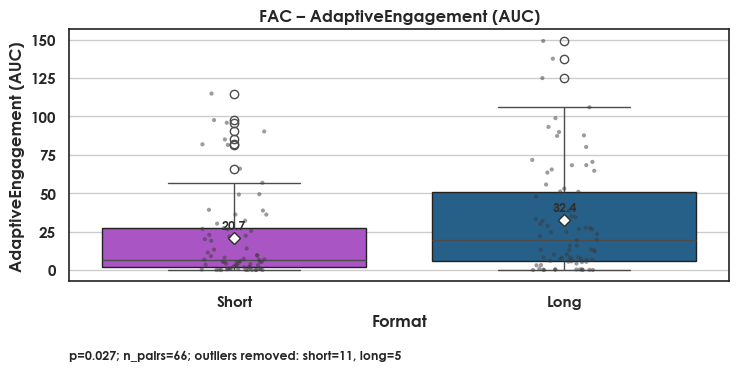

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


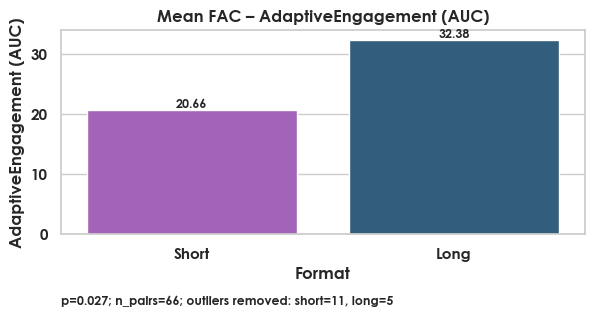

FAC – AdaptiveEngagement (AUC) – Part 1: Long form (29) showed 10 greater than short form (19) (p=0.027, n_pairs=66, outliers removed: short=11, long=5).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary  40.881567   26.128033   14.753533  1.767673  0.082381   
1            Mad Max  28.222500   15.883250   12.339250  1.323085  0.194637   
2           The Town  26.004320   17.757794    8.246526  0.832075  0.410455   

   n_long  n_short  
0      30       30  
1      23       24  
2      25       17

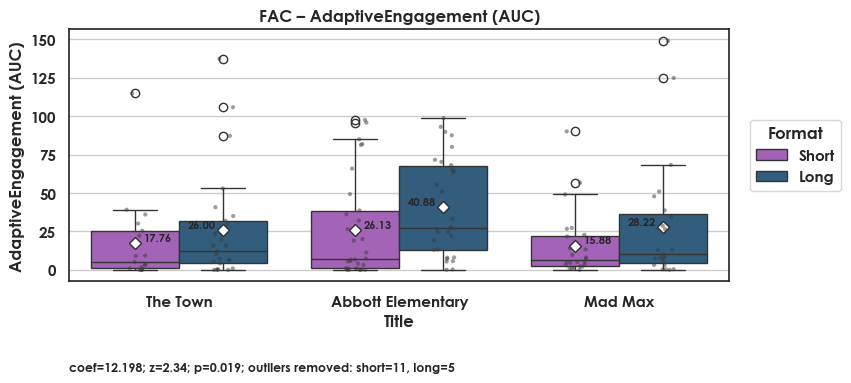

FAC – AdaptiveEngagement (AUC) – Part 2 – Abbott Elementary: Long form (41) showed 15 greater than short form (26) (p=0.082, n_long=30, n_short=30, overall mixed-model p=0.019).
FAC – AdaptiveEngagement (AUC) – Part 2 – Mad Max: Long form (28) showed 12 greater than short form (16) (p=0.195, n_long=23, n_short=24, overall mixed-model p=0.019).
FAC – AdaptiveEngagement (AUC) – Part 2 – The Town: Long form (26) showed 8 greater than short form (18) (p=0.410, n_long=25, n_short=17, overall mixed-model p=0.019).
FAC – AdaptiveEngagement (AUC) – Part 2 (Overall): Long form (32) showed 12 greater than short form (20) (n_long=78, n_short=71, overall mixed-model p=0.019).

Analyzing FAC – AdaptiveEngagement (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.254573    0.188347    0.066226  1.972434  0.052104       79

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


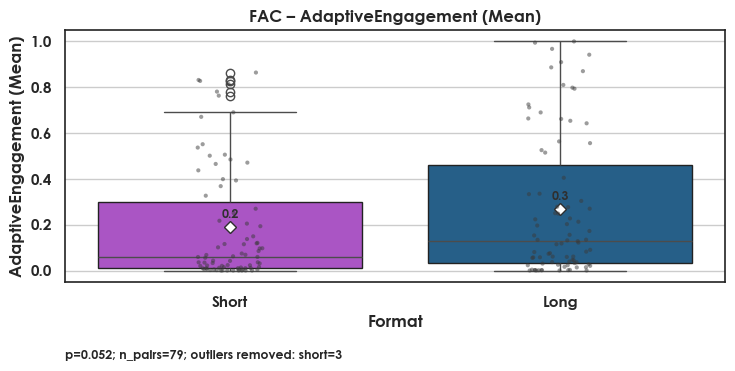

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


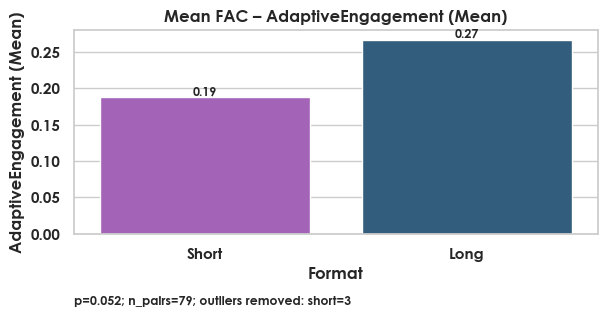

FAC – AdaptiveEngagement (Mean) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.052, n_pairs=79, outliers removed: short=3).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.413028    0.214071    0.198956  2.516849  0.014745   
1            Mad Max   0.161589    0.115932    0.045657  0.731305  0.468551   
2           The Town   0.203628    0.234847   -0.031219 -0.402094  0.689273   

   n_long  n_short  
0      30       28  
1      24       26  
2      29       25

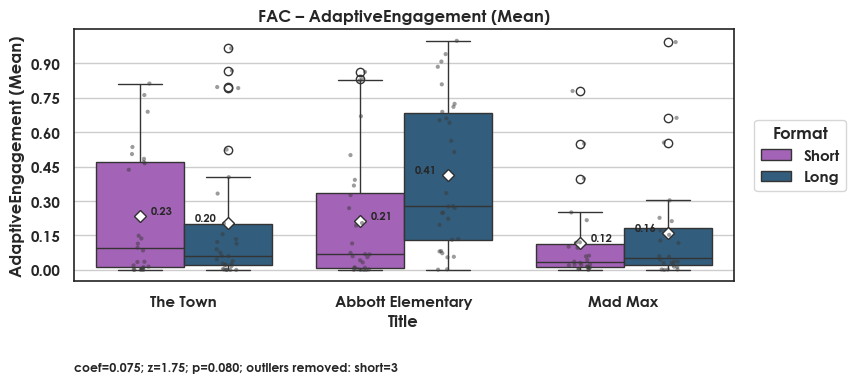

FAC – AdaptiveEngagement (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.015, n_long=30, n_short=28, overall mixed-model p=0.080).
FAC – AdaptiveEngagement (Mean) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (p=0.469, n_long=24, n_short=26, overall mixed-model p=0.080).
FAC – AdaptiveEngagement (Mean) – Part 2 – The Town: Long form (0) showed 0 lower than short form (0) (p=0.689, n_long=29, n_short=25, overall mixed-model p=0.080).
FAC – AdaptiveEngagement (Mean) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=83, n_short=79, overall mixed-model p=0.080).

Analyzing FAC – Anger (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       62

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


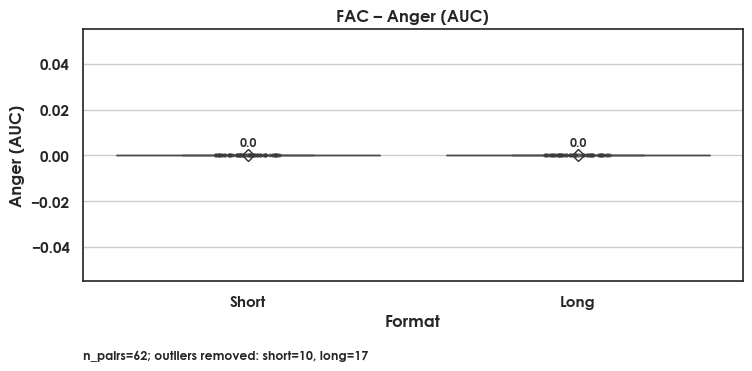

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


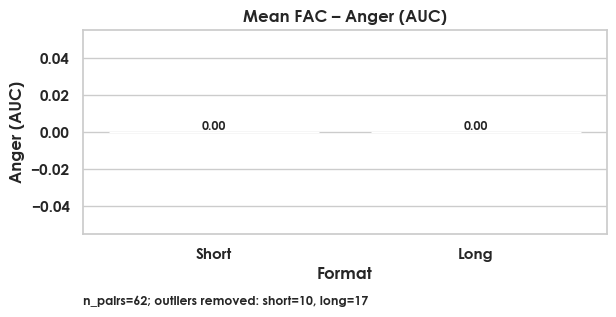

FAC – Anger (AUC) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=62, outliers removed: short=10, long=17).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      25       28  
1      19       22  
2      22       22

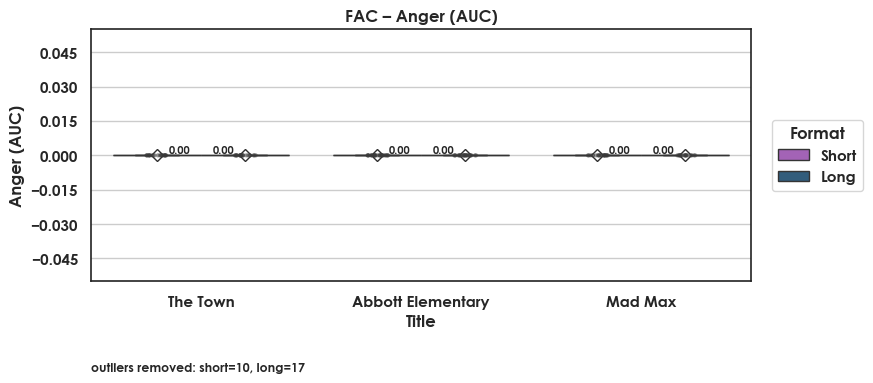

FAC – Anger (AUC) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=25, n_short=28).
FAC – Anger (AUC) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=19, n_short=22).
FAC – Anger (AUC) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=22, n_short=22).
FAC – Anger (AUC) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=66, n_short=72).

Analyzing FAC – Anger (Binary)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       82

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


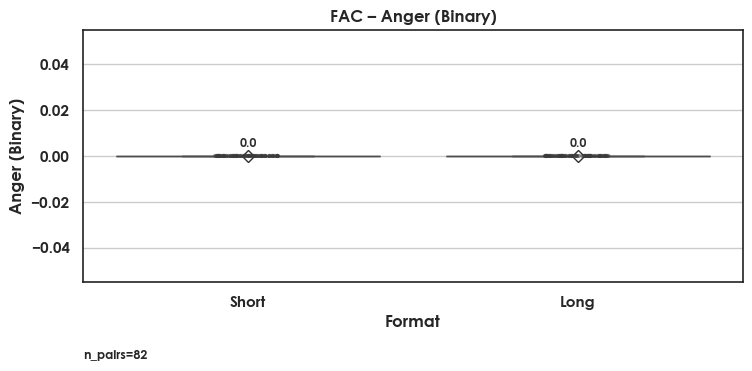

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


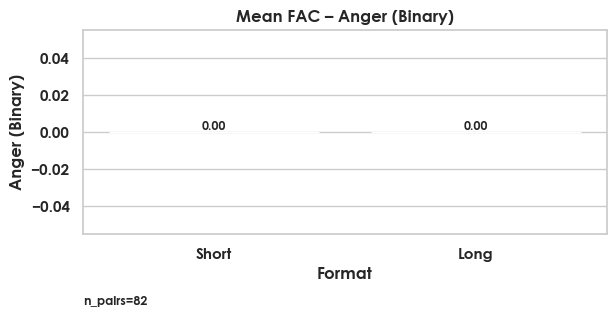

FAC – Anger (Binary) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=82).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      30       30  
1      24       26  
2      29       26

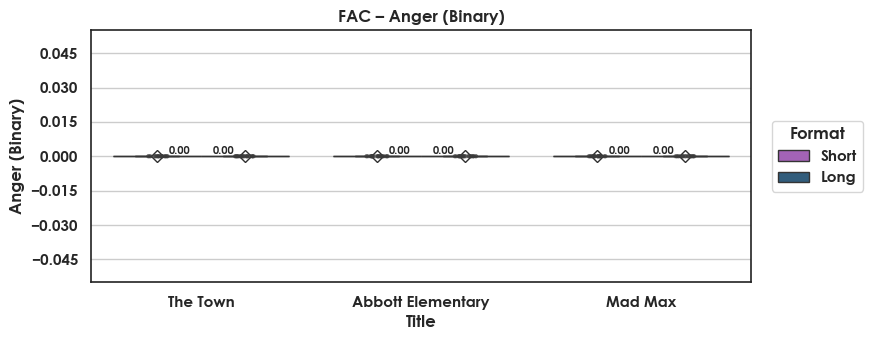

FAC – Anger (Binary) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=30, n_short=30).
FAC – Anger (Binary) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=24, n_short=26).
FAC – Anger (Binary) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=29, n_short=26).
FAC – Anger (Binary) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=83, n_short=82).

Analyzing FAC – Anger (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       62

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


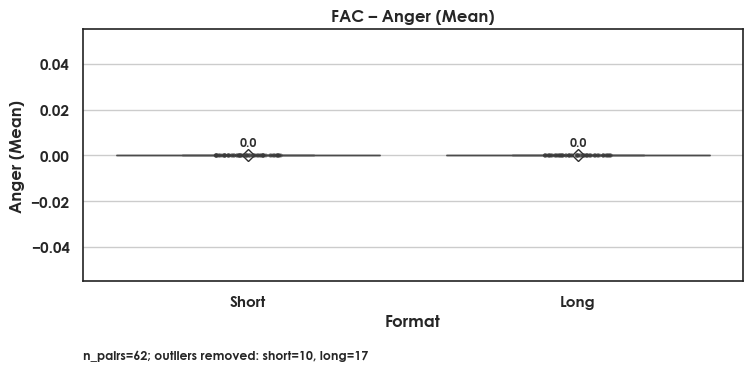

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


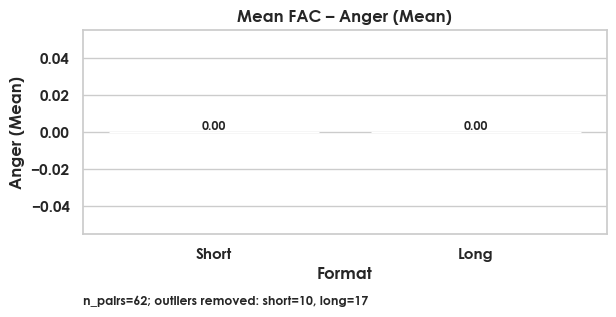

FAC – Anger (Mean) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=62, outliers removed: short=10, long=17).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      25       28  
1      19       22  
2      22       22

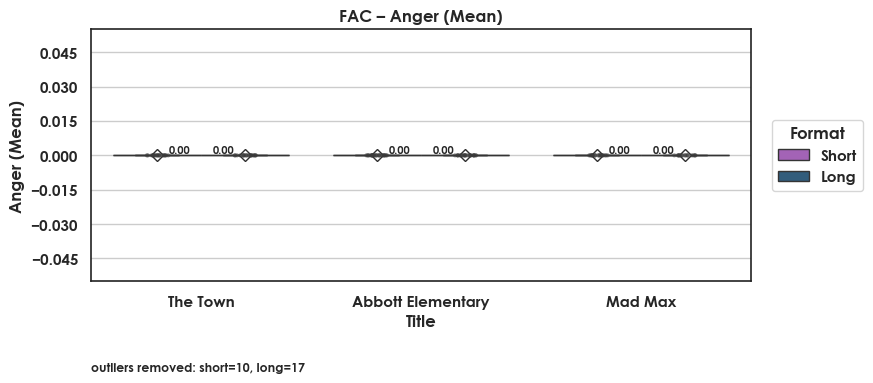

FAC – Anger (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=25, n_short=28).
FAC – Anger (Mean) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=19, n_short=22).
FAC – Anger (Mean) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=22, n_short=22).
FAC – Anger (Mean) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=66, n_short=72).

Analyzing FAC – Confusion (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.008236    0.001655    0.006582  1.462081  0.149515       55

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


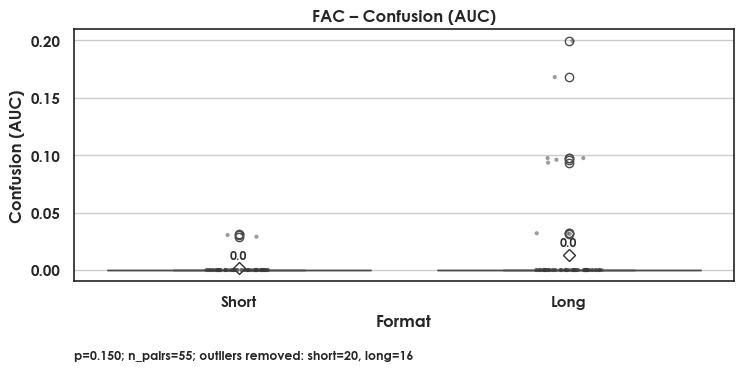

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


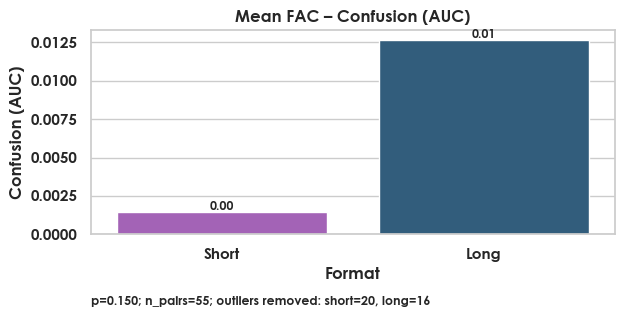

FAC – Confusion (AUC) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.150, n_pairs=55, outliers removed: short=20, long=16).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.018885    0.000000    0.018885  2.192919  0.037833   
1            Mad Max   0.004921    0.002952    0.001969  0.369686  0.714852   
2           The Town   0.011955    0.001611    0.010343  1.113406  0.277394   

   n_long  n_short  
0      26       23  
1      19       21  
2      22       18

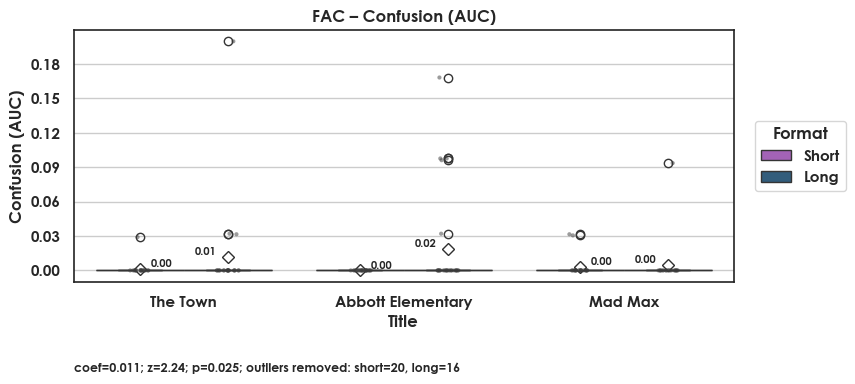

FAC – Confusion (AUC) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.038, n_long=26, n_short=23, overall mixed-model p=0.025).
FAC – Confusion (AUC) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (p=0.715, n_long=19, n_short=21, overall mixed-model p=0.025).
FAC – Confusion (AUC) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (p=0.277, n_long=22, n_short=18, overall mixed-model p=0.025).
FAC – Confusion (AUC) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=67, n_short=62, overall mixed-model p=0.025).

Analyzing FAC – Confusion (Binary)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       82

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


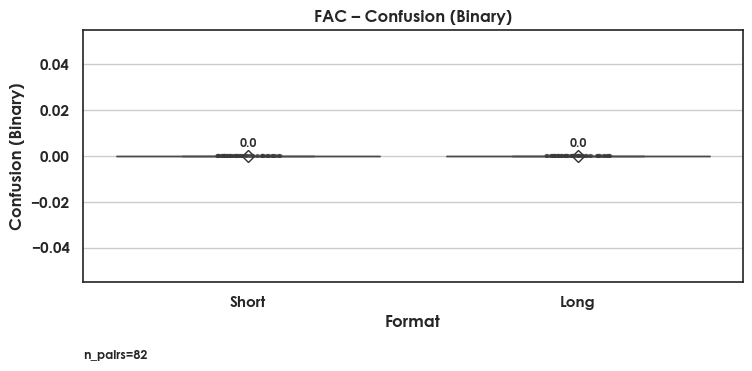

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


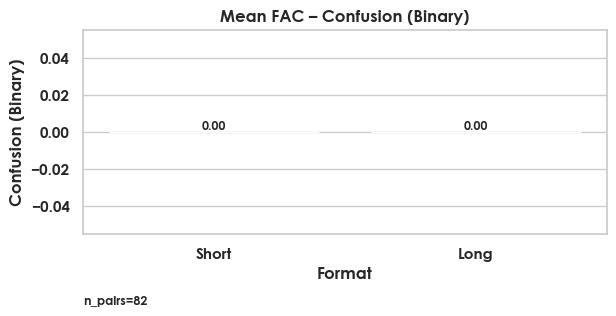

FAC – Confusion (Binary) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=82).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      30       30  
1      24       26  
2      29       26

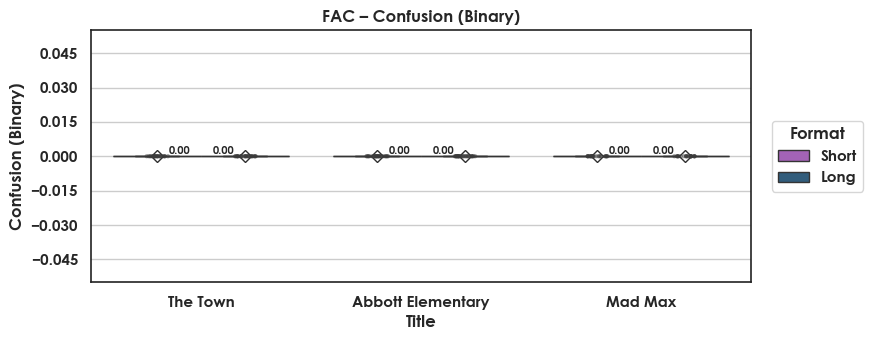

FAC – Confusion (Binary) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=30, n_short=30).
FAC – Confusion (Binary) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=24, n_short=26).
FAC – Confusion (Binary) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=29, n_short=26).
FAC – Confusion (Binary) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=83, n_short=82).

Analyzing FAC – Confusion (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.000066    0.000008    0.000059  1.930227  0.058742       56

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


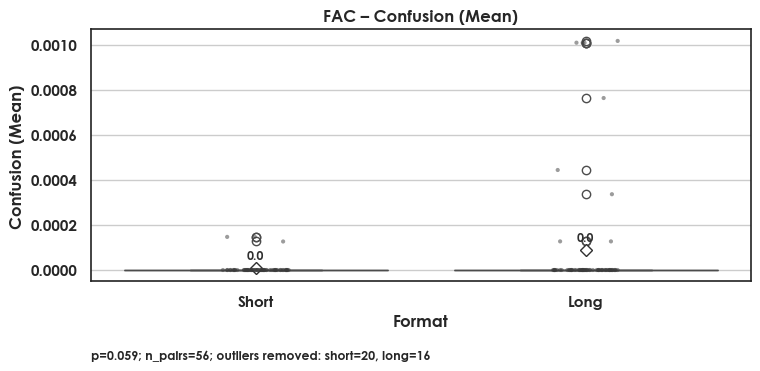

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


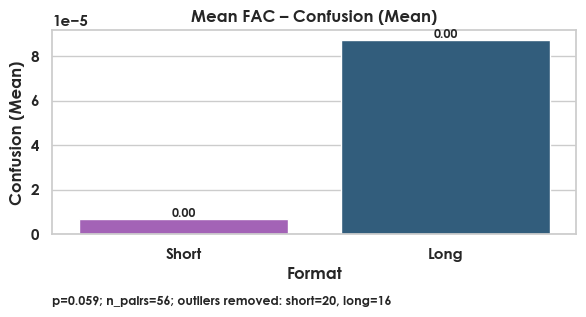

FAC – Confusion (Mean) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.059, n_pairs=56, outliers removed: short=20, long=16).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.000135    0.000000    0.000135  2.000050  0.056934   
1            Mad Max   0.000023    0.000014    0.000009  0.370114  0.714538   
2           The Town   0.000089    0.000007    0.000081  1.498319  0.147800   

   n_long  n_short  
0      25       23  
1      19       21  
2      23       18

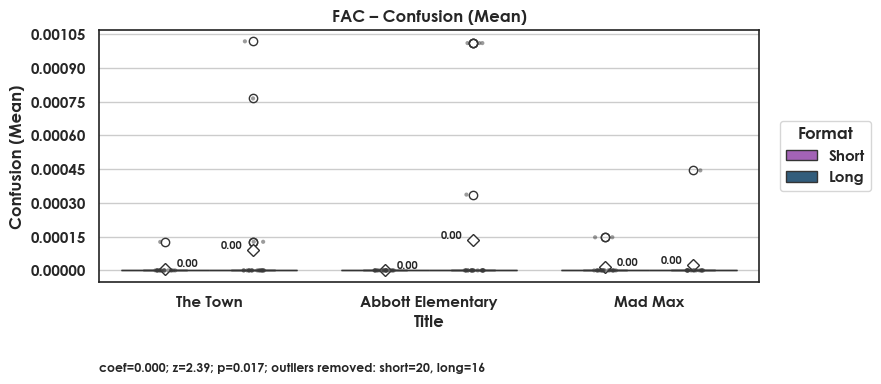

FAC – Confusion (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.057, n_long=25, n_short=23, overall mixed-model p=0.017).
FAC – Confusion (Mean) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (p=0.715, n_long=19, n_short=21, overall mixed-model p=0.017).
FAC – Confusion (Mean) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (p=0.148, n_long=23, n_short=18, overall mixed-model p=0.017).
FAC – Confusion (Mean) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=67, n_short=62, overall mixed-model p=0.017).

Analyzing FAC – Contempt (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.429422    0.197695    0.231727  2.373064  0.020705       64

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


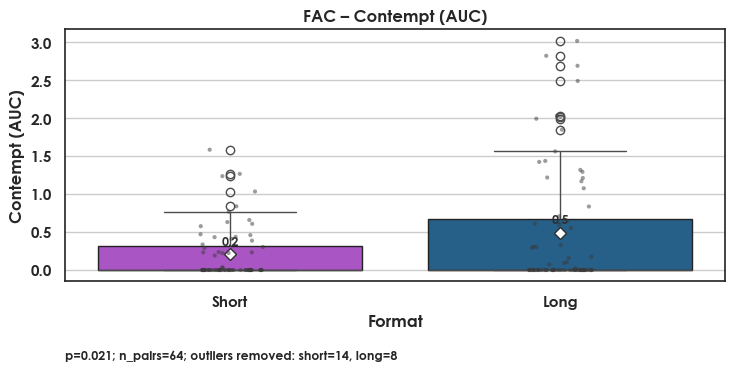

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


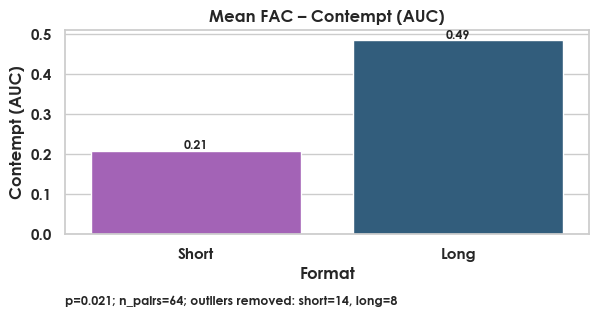

FAC – Contempt (AUC) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.021, n_pairs=64, outliers removed: short=14, long=8).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.491667    0.156217    0.335450  2.360997  0.022957   
1            Mad Max   0.583159    0.174500    0.408659  1.908594  0.068343   
2           The Town   0.397115    0.322789    0.074326  0.413782  0.681383   

   n_long  n_short  
0      27       30  
1      22       19  
2      26       19

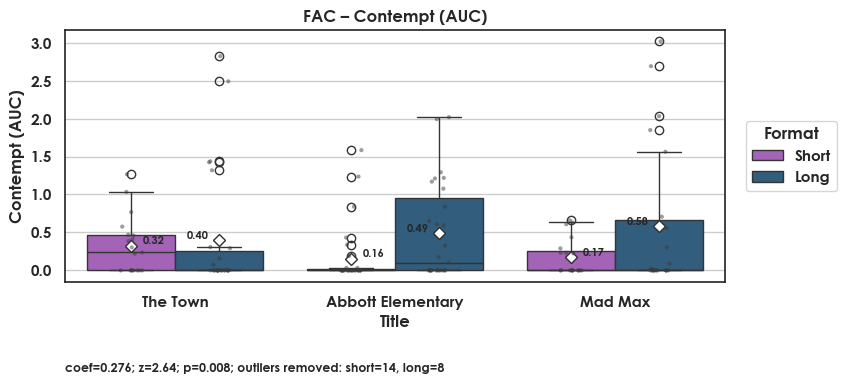

FAC – Contempt (AUC) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.023, n_long=27, n_short=30, overall mixed-model p=0.008).
FAC – Contempt (AUC) – Part 2 – Mad Max: Long form (1) showed 0 greater than short form (0) (p=0.068, n_long=22, n_short=19, overall mixed-model p=0.008).
FAC – Contempt (AUC) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (p=0.681, n_long=26, n_short=19, overall mixed-model p=0.008).
FAC – Contempt (AUC) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=75, n_short=68, overall mixed-model p=0.008).

Analyzing FAC – Contempt (Binary)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       82

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


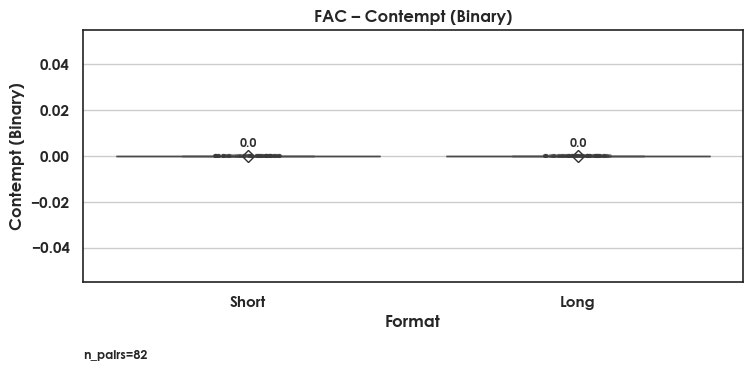

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


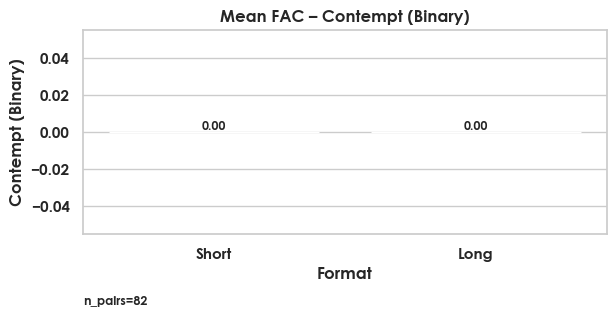

FAC – Contempt (Binary) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=82).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      30       30  
1      24       26  
2      29       26

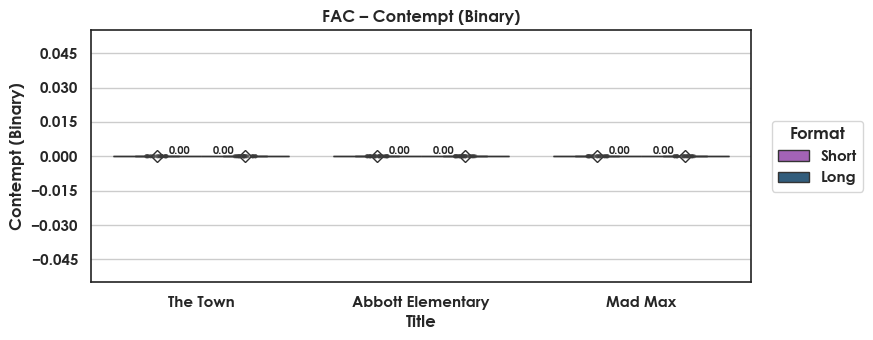

FAC – Contempt (Binary) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=30, n_short=30).
FAC – Contempt (Binary) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=24, n_short=26).
FAC – Contempt (Binary) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=29, n_short=26).
FAC – Contempt (Binary) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=83, n_short=82).

Analyzing FAC – Contempt (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.002844    0.000828    0.002016  3.222151  0.002002       65

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


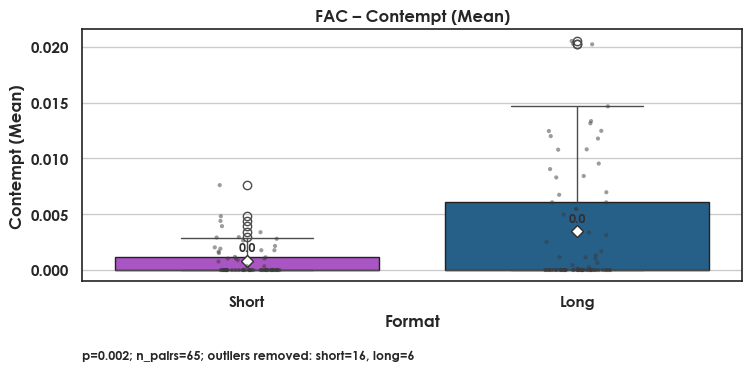

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


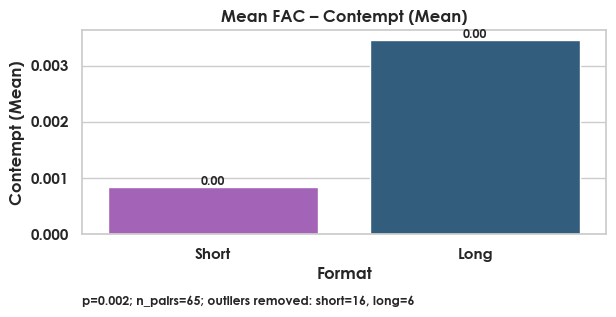

FAC – Contempt (Mean) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.002, n_pairs=65, outliers removed: short=16, long=6).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.004989    0.000389    0.004601  3.622553  0.001168   
1            Mad Max   0.003840    0.000767    0.003073  2.483353  0.020119   
2           The Town   0.001517    0.001546   -0.000029 -0.038596  0.969391   

   n_long  n_short  
0      27       27  
1      24       19  
2      26       20

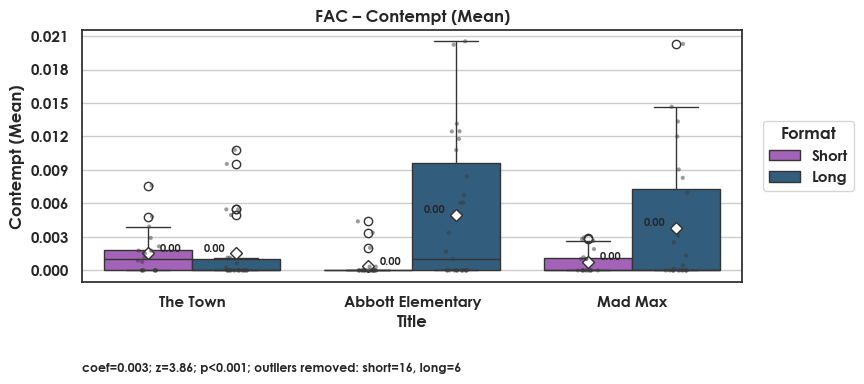

FAC – Contempt (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.001, n_long=27, n_short=27, overall mixed-model p<0.001).
FAC – Contempt (Mean) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (p=0.020, n_long=24, n_short=19, overall mixed-model p<0.001).
FAC – Contempt (Mean) – Part 2 – The Town: Long form (0) showed 0 lower than short form (0) (p=0.969, n_long=26, n_short=20, overall mixed-model p<0.001).
FAC – Contempt (Mean) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=77, n_short=66, overall mixed-model p<0.001).

Analyzing FAC – Disgust (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       57

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


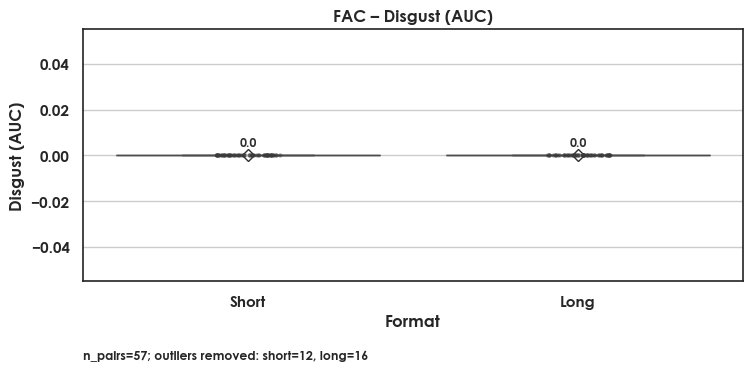

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


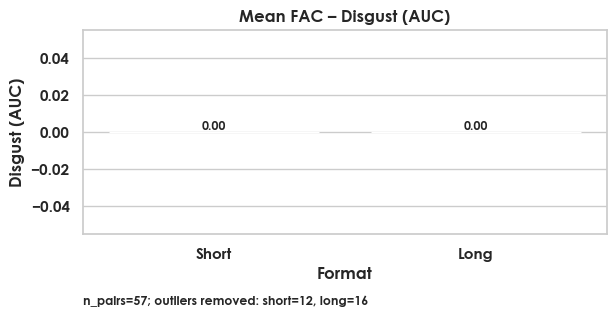

FAC – Disgust (AUC) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=57, outliers removed: short=12, long=16).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      24       28  
1      19       22  
2      24       20

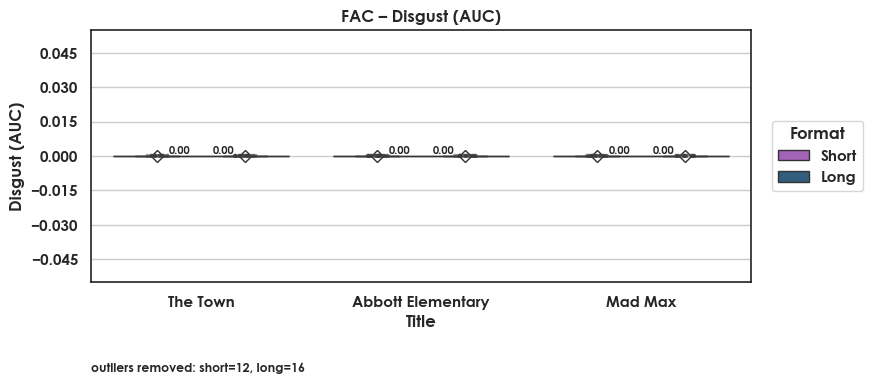

FAC – Disgust (AUC) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=24, n_short=28).
FAC – Disgust (AUC) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=19, n_short=22).
FAC – Disgust (AUC) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=24, n_short=20).
FAC – Disgust (AUC) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=67, n_short=70).

Analyzing FAC – Disgust (Binary)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       82

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


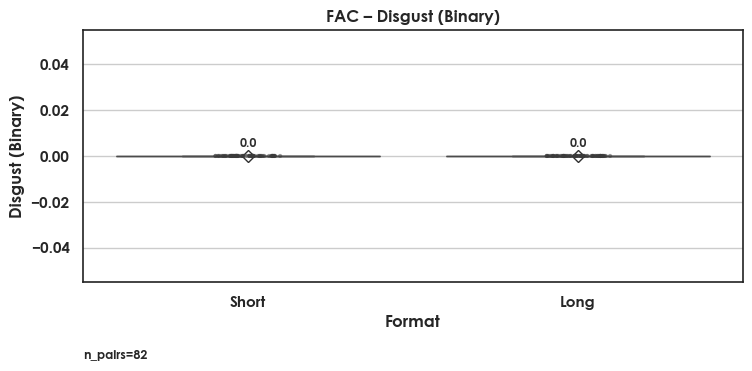

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


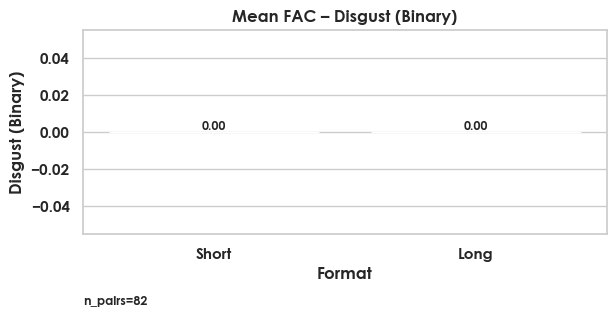

FAC – Disgust (Binary) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=82).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      30       30  
1      24       26  
2      29       26

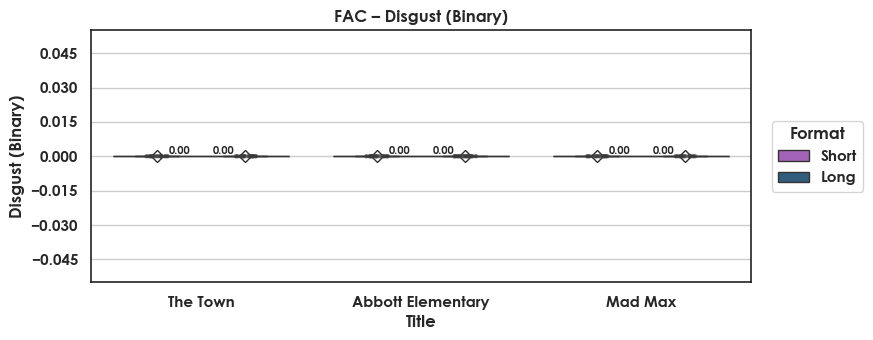

FAC – Disgust (Binary) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=30, n_short=30).
FAC – Disgust (Binary) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=24, n_short=26).
FAC – Disgust (Binary) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=29, n_short=26).
FAC – Disgust (Binary) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=83, n_short=82).

Analyzing FAC – Disgust (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       57

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


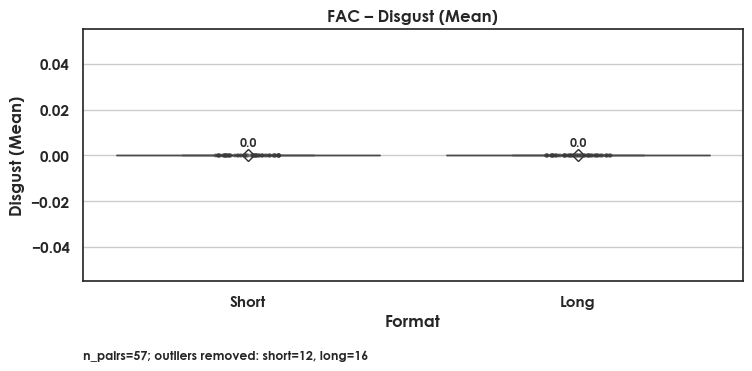

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


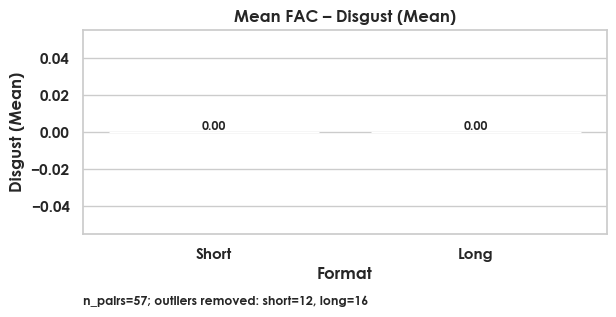

FAC – Disgust (Mean) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=57, outliers removed: short=12, long=16).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      24       28  
1      19       22  
2      24       20

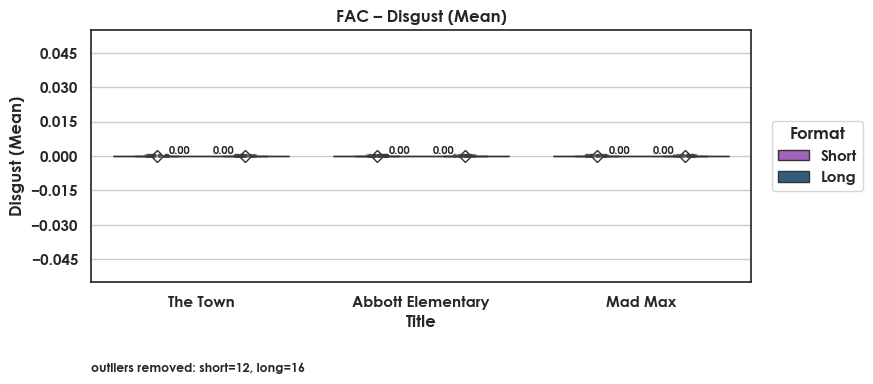

FAC – Disgust (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=24, n_short=28).
FAC – Disgust (Mean) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=19, n_short=22).
FAC – Disgust (Mean) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=24, n_short=20).
FAC – Disgust (Mean) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=67, n_short=70).

Analyzing FAC – Engagement (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   28.82459   21.860784    6.963806  1.377447  0.173027       67

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


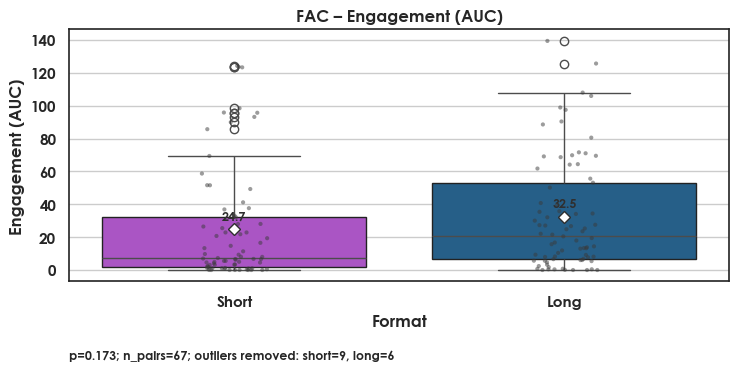

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


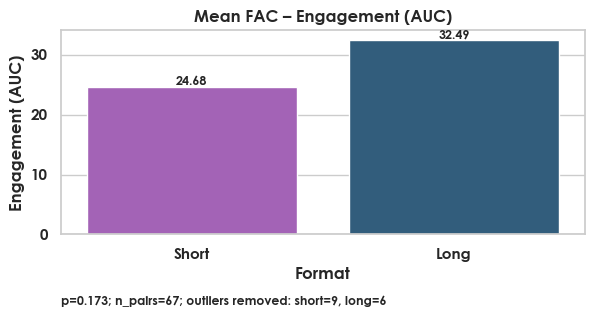

FAC – Engagement (AUC) – Part 1: Long form (29) showed 7 greater than short form (22) (p=0.173, n_pairs=67, outliers removed: short=9, long=6).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary  41.998617   27.844217   14.154400  1.633418  0.107818   
1            Mad Max  24.530955   16.445042    8.085913  1.013815  0.317018   
2           The Town  28.092920   30.072553   -1.979633 -0.158473  0.874991   

   n_long  n_short  
0      30       30  
1      22       24  
2      25       19

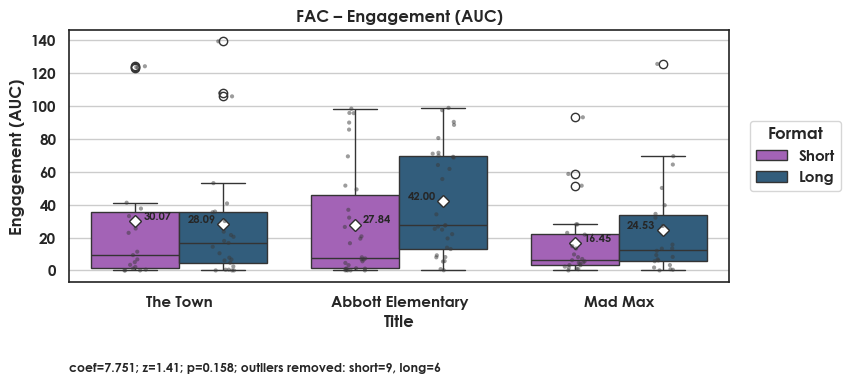

FAC – Engagement (AUC) – Part 2 – Abbott Elementary: Long form (42) showed 14 greater than short form (28) (p=0.108, n_long=30, n_short=30, overall mixed-model p=0.158).
FAC – Engagement (AUC) – Part 2 – Mad Max: Long form (25) showed 8 greater than short form (16) (p=0.317, n_long=22, n_short=24, overall mixed-model p=0.158).
FAC – Engagement (AUC) – Part 2 – The Town: Long form (28) showed 2 lower than short form (30) (p=0.875, n_long=25, n_short=19, overall mixed-model p=0.158).
FAC – Engagement (AUC) – Part 2 (Overall): Long form (32) showed 7 greater than short form (25) (n_long=77, n_short=73, overall mixed-model p=0.158).

Analyzing FAC – Engagement (Binary)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       82

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


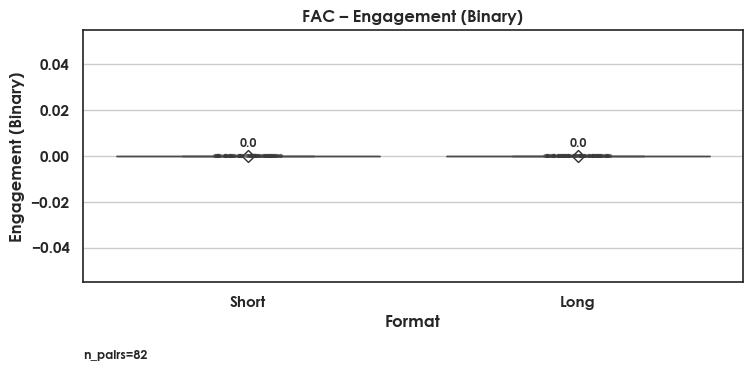

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


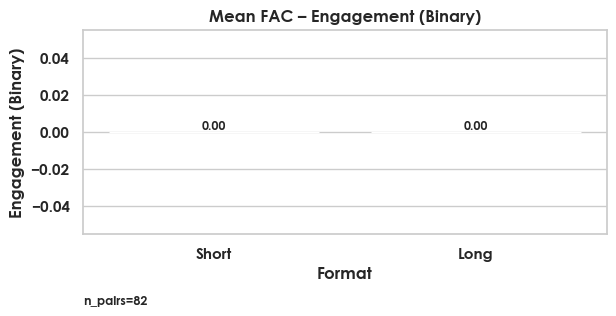

FAC – Engagement (Binary) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=82).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      30       30  
1      24       26  
2      29       26

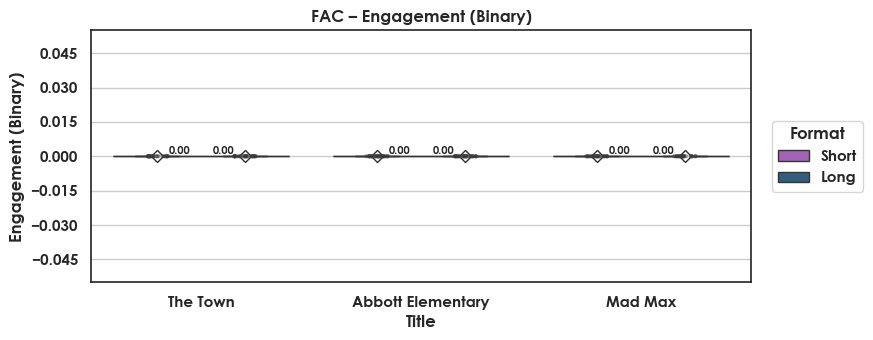

FAC – Engagement (Binary) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=30, n_short=30).
FAC – Engagement (Binary) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=24, n_short=26).
FAC – Engagement (Binary) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=29, n_short=26).
FAC – Engagement (Binary) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=83, n_short=82).

Analyzing FAC – Engagement (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.273001    0.207746    0.065256  1.902406  0.060762       80

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


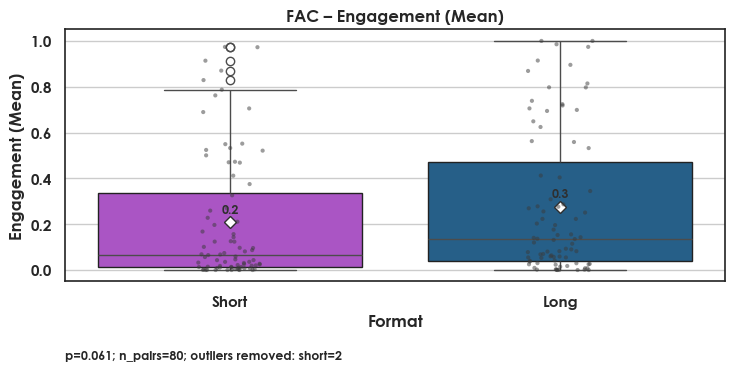

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


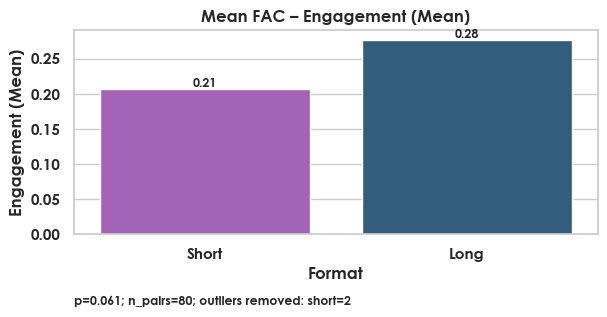

FAC – Engagement (Mean) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.061, n_pairs=80, outliers removed: short=2).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.424330    0.258011    0.166319  1.940676  0.057256   
1            Mad Max   0.172385    0.118542    0.053843  0.842116  0.404424   
2           The Town   0.210944    0.242210   -0.031265 -0.398472  0.691929   

   n_long  n_short  
0      30       29  
1      24       26  
2      29       25

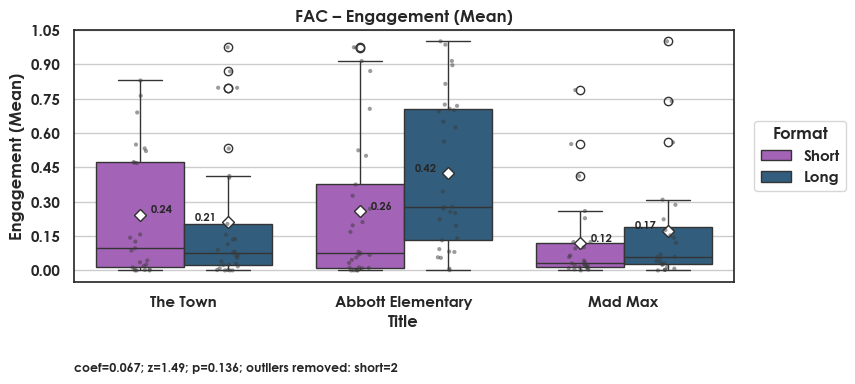

FAC – Engagement (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.057, n_long=30, n_short=29, overall mixed-model p=0.136).
FAC – Engagement (Mean) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (p=0.404, n_long=24, n_short=26, overall mixed-model p=0.136).
FAC – Engagement (Mean) – Part 2 – The Town: Long form (0) showed 0 lower than short form (0) (p=0.692, n_long=29, n_short=25, overall mixed-model p=0.136).
FAC – Engagement (Mean) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=83, n_short=80, overall mixed-model p=0.136).

Analyzing FAC – Fear (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.005187         0.0    0.005187  1.764191  0.083253       56

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


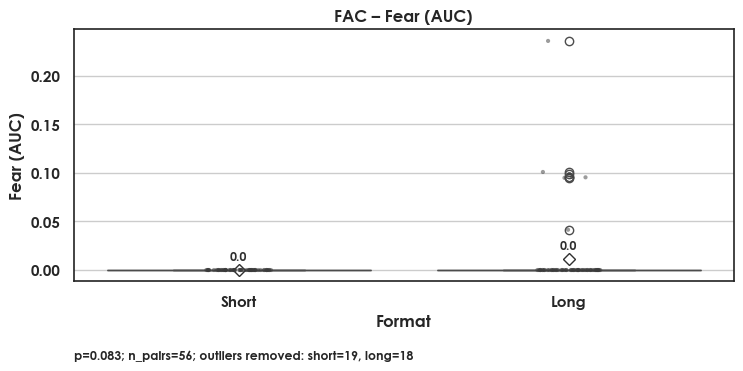

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


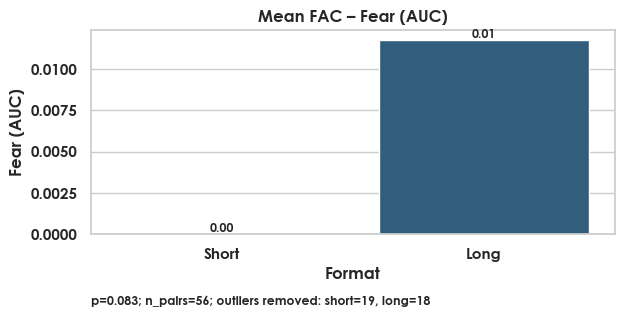

FAC – Fear (AUC) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.083, n_pairs=56, outliers removed: short=19, long=18).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.010727         0.0    0.010727  1.000000  0.328695   
1            Mad Max   0.025412         0.0    0.025412  2.465661  0.025364   
2           The Town   0.003692         0.0    0.003692  1.000000  0.326892   

   n_long  n_short  
0      22       24  
1      17       22  
2      26       17

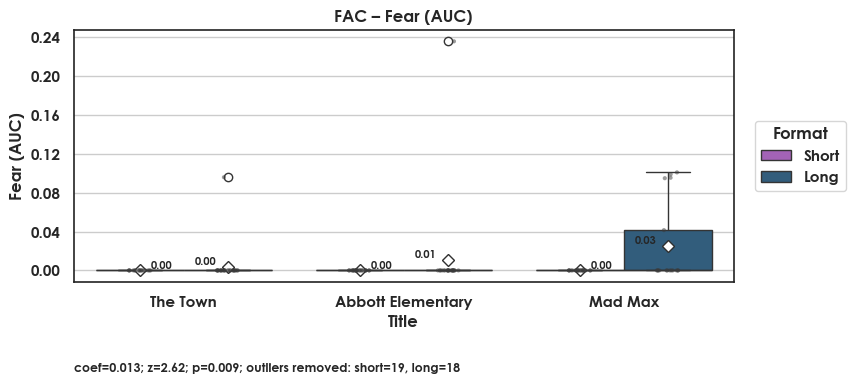

FAC – Fear (AUC) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.329, n_long=22, n_short=24, overall mixed-model p=0.009).
FAC – Fear (AUC) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (p=0.025, n_long=17, n_short=22, overall mixed-model p=0.009).
FAC – Fear (AUC) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (p=0.327, n_long=26, n_short=17, overall mixed-model p=0.009).
FAC – Fear (AUC) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=65, n_short=63, overall mixed-model p=0.009).

Analyzing FAC – Fear (Binary)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       82

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


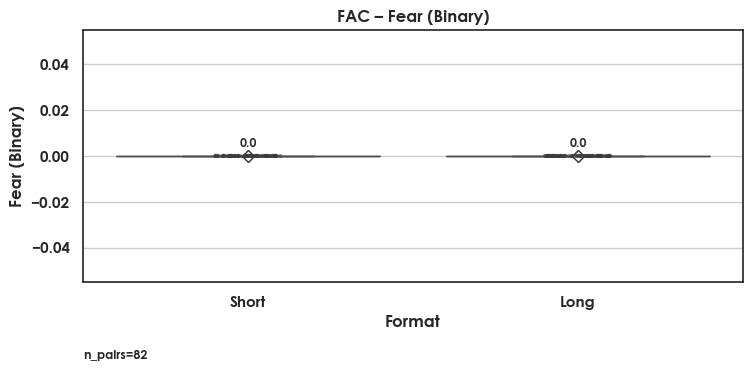

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


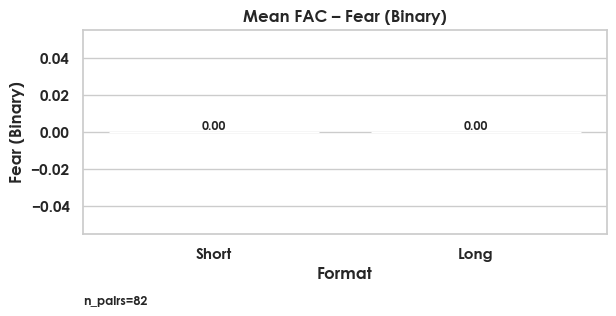

FAC – Fear (Binary) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=82).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      30       30  
1      24       26  
2      29       26

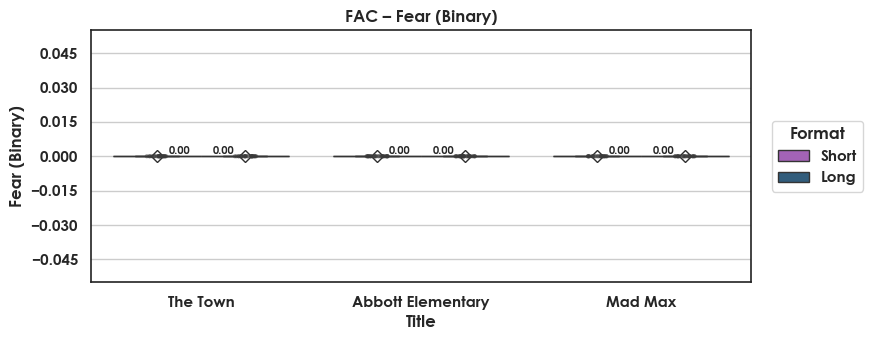

FAC – Fear (Binary) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=30, n_short=30).
FAC – Fear (Binary) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=24, n_short=26).
FAC – Fear (Binary) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=29, n_short=26).
FAC – Fear (Binary) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=83, n_short=82).

Analyzing FAC – Fear (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.000023         0.0    0.000023  1.759903  0.083985       56

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


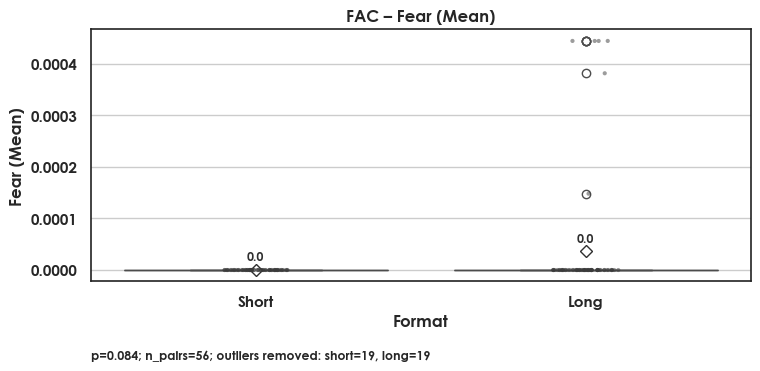

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


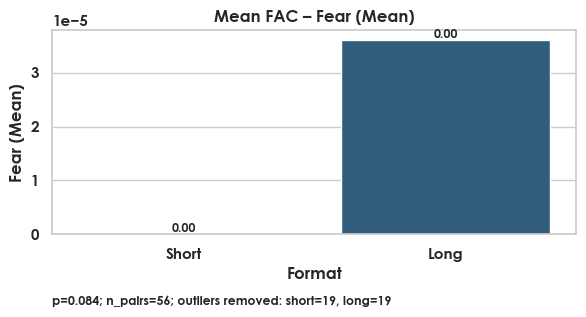

FAC – Fear (Mean) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.084, n_pairs=56, outliers removed: short=19, long=19).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.000000         0.0    0.000000       NaN       NaN   
1            Mad Max   0.000113         0.0    0.000113  2.424524  0.027540   
2           The Town   0.000015         0.0    0.000015  1.000000  0.326892   

   n_long  n_short  
0      21       24  
1      17       22  
2      26       17

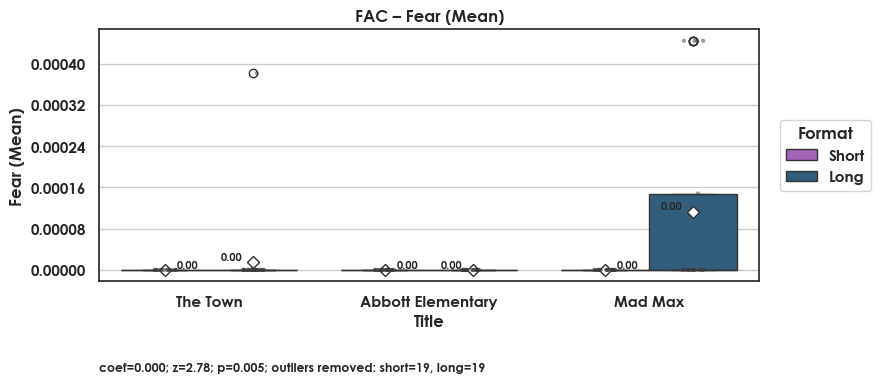

FAC – Fear (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=21, n_short=24, overall mixed-model p=0.005).
FAC – Fear (Mean) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (p=0.028, n_long=17, n_short=22, overall mixed-model p=0.005).
FAC – Fear (Mean) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (p=0.327, n_long=26, n_short=17, overall mixed-model p=0.005).
FAC – Fear (Mean) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=64, n_short=63, overall mixed-model p=0.005).

Analyzing FAC – Joy (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   3.302187    0.874156    2.428031  2.976583  0.004132       64

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


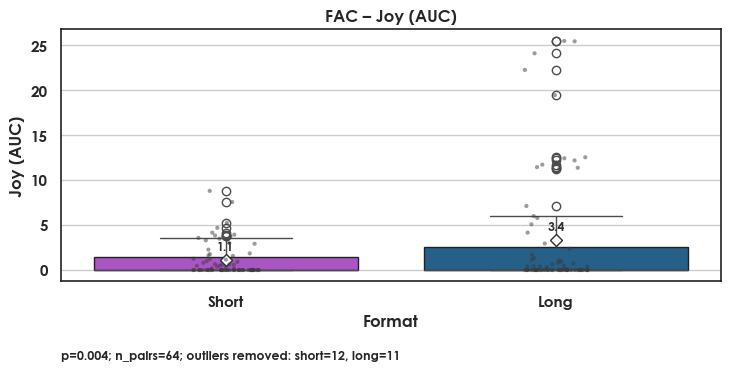

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


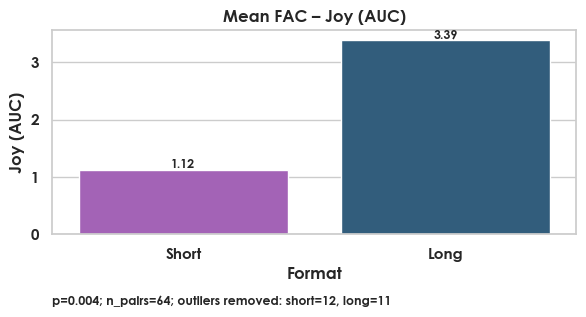

FAC – Joy (AUC) – Part 1: Long form (3) showed 2 greater than short form (1) (p=0.004, n_pairs=64, outliers removed: short=12, long=11).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   8.528227    0.922000    7.606227  4.130373  0.000424   
1            Mad Max   0.474783    1.003340   -0.528557 -1.287700  0.204500   
2           The Town   1.686241    1.405479    0.280762  0.253327  0.801356   

   n_long  n_short  
0      22       21  
1      23       25  
2      27       24

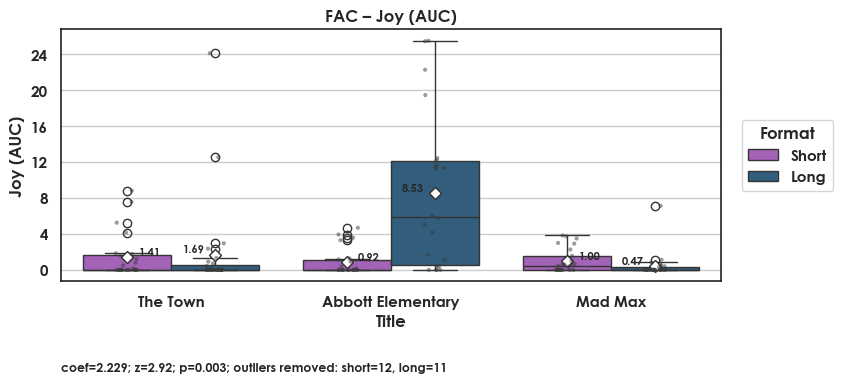

FAC – Joy (AUC) – Part 2 – Abbott Elementary: Long form (9) showed 8 greater than short form (1) (p<0.001, n_long=22, n_short=21, overall mixed-model p=0.003).
FAC – Joy (AUC) – Part 2 – Mad Max: Long form (0) showed 1 lower than short form (1) (p=0.205, n_long=23, n_short=25, overall mixed-model p=0.003).
FAC – Joy (AUC) – Part 2 – The Town: Long form (2) showed 0 greater than short form (1) (p=0.801, n_long=27, n_short=24, overall mixed-model p=0.003).
FAC – Joy (AUC) – Part 2 (Overall): Long form (4) showed 2 greater than short form (1) (n_long=72, n_short=70, overall mixed-model p=0.003).

Analyzing FAC – Joy (Binary)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       82

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


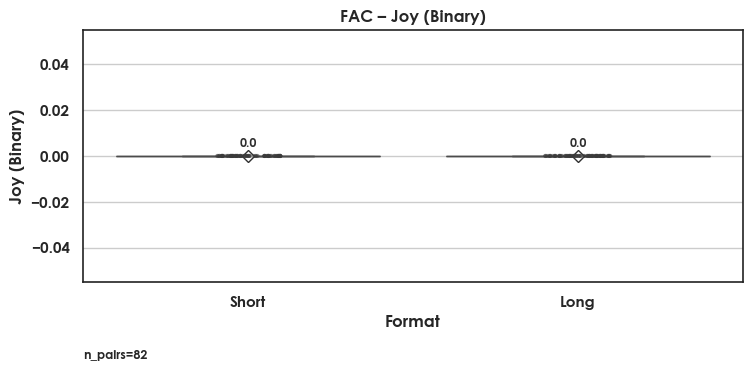

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


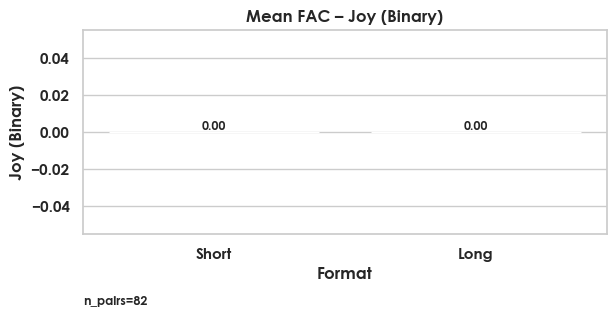

FAC – Joy (Binary) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=82).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      30       30  
1      24       26  
2      29       26

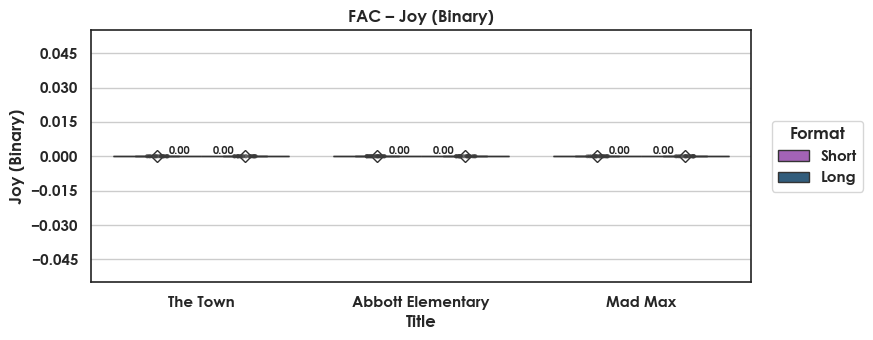

FAC – Joy (Binary) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=30, n_short=30).
FAC – Joy (Binary) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=24, n_short=26).
FAC – Joy (Binary) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=29, n_short=26).
FAC – Joy (Binary) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=83, n_short=82).

Analyzing FAC – Joy (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.022782    0.004441    0.018342  2.834022  0.006253       61

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


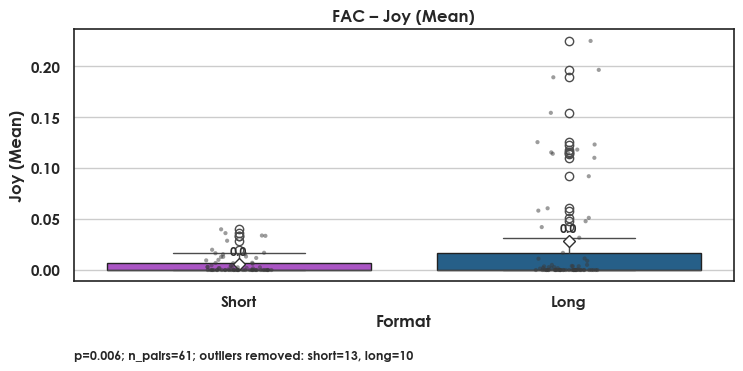

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


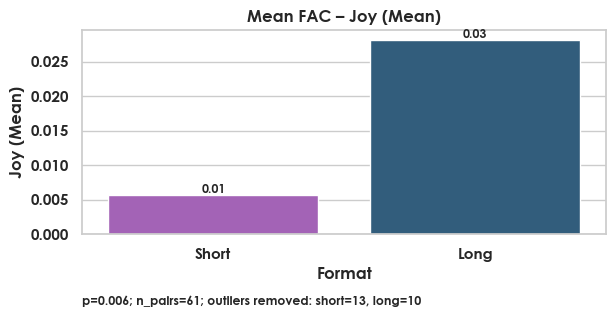

FAC – Joy (Mean) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.006, n_pairs=61, outliers removed: short=13, long=10).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.069025    0.007481    0.061544  3.922617  0.000817   
1            Mad Max   0.009900    0.004434    0.005466  0.683813  0.500631   
2           The Town   0.015114    0.005346    0.009768  1.336273  0.190831   

   n_long  n_short  
0      20       20  
1      24       25  
2      29       24

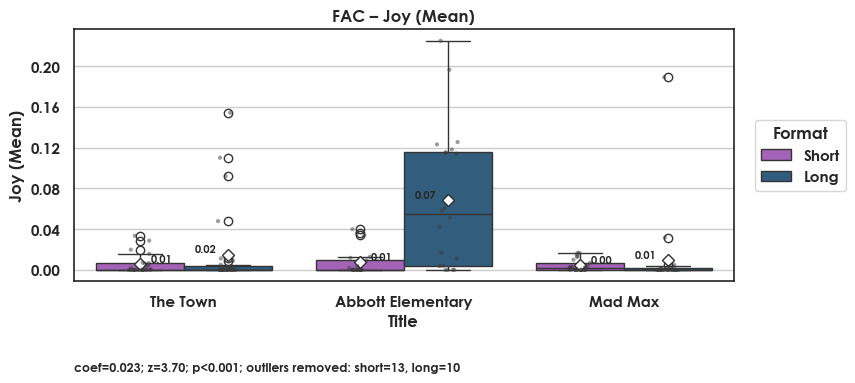

FAC – Joy (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p<0.001, n_long=20, n_short=20, overall mixed-model p<0.001).
FAC – Joy (Mean) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (p=0.501, n_long=24, n_short=25, overall mixed-model p<0.001).
FAC – Joy (Mean) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (p=0.191, n_long=29, n_short=24, overall mixed-model p<0.001).
FAC – Joy (Mean) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=73, n_short=69, overall mixed-model p<0.001).

Analyzing FAC – NegativeAdaptiveValence (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       72

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


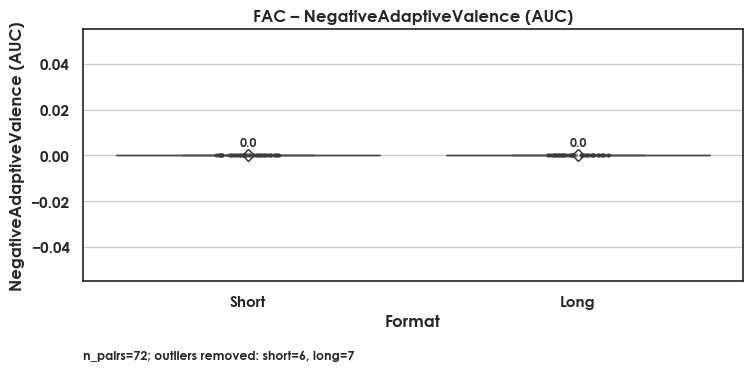

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


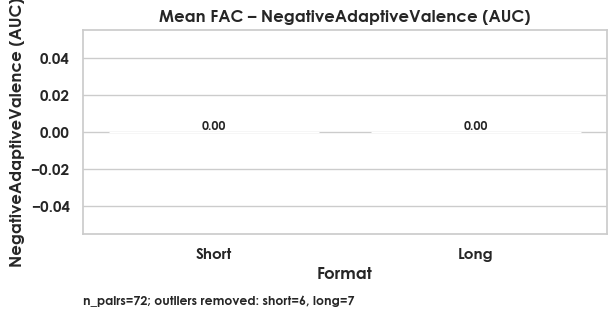

FAC – NegativeAdaptiveValence (AUC) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=72, outliers removed: short=6, long=7).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      28       29  
1      23       23  
2      25       24

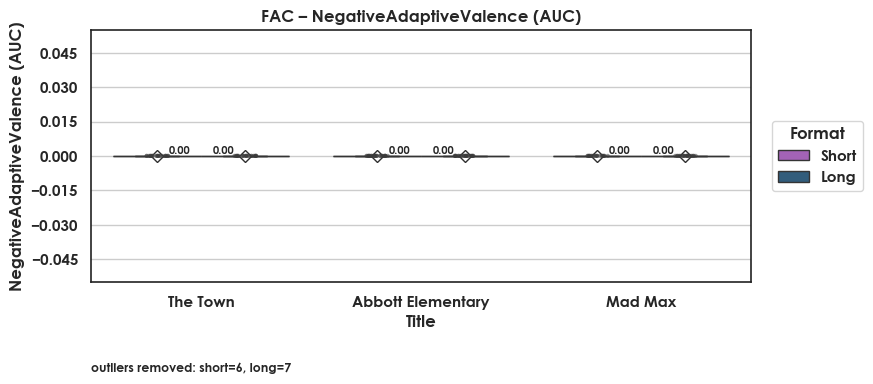

FAC – NegativeAdaptiveValence (AUC) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=28, n_short=29).
FAC – NegativeAdaptiveValence (AUC) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=23, n_short=23).
FAC – NegativeAdaptiveValence (AUC) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=25, n_short=24).
FAC – NegativeAdaptiveValence (AUC) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=76, n_short=76).

Analyzing FAC – NegativeAdaptiveValence (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       72

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


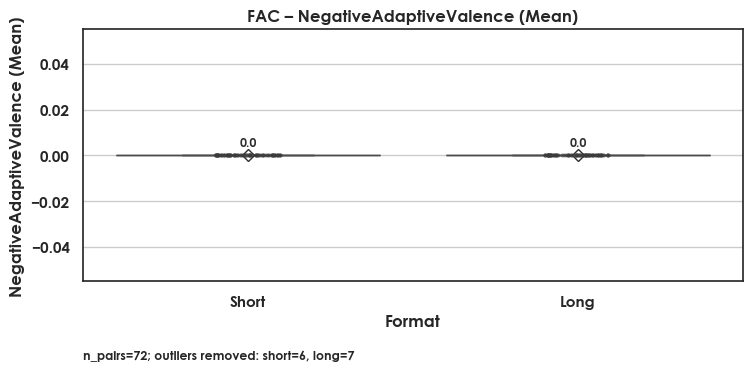

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


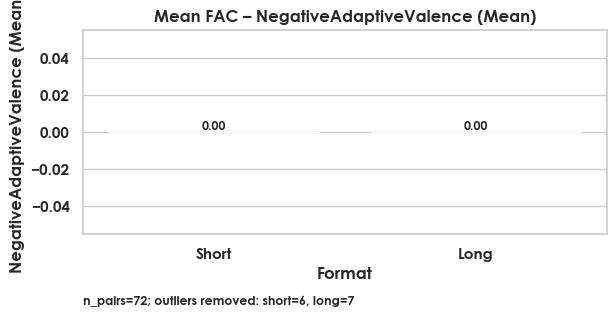

FAC – NegativeAdaptiveValence (Mean) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=72, outliers removed: short=6, long=7).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      28       29  
1      23       23  
2      25       24

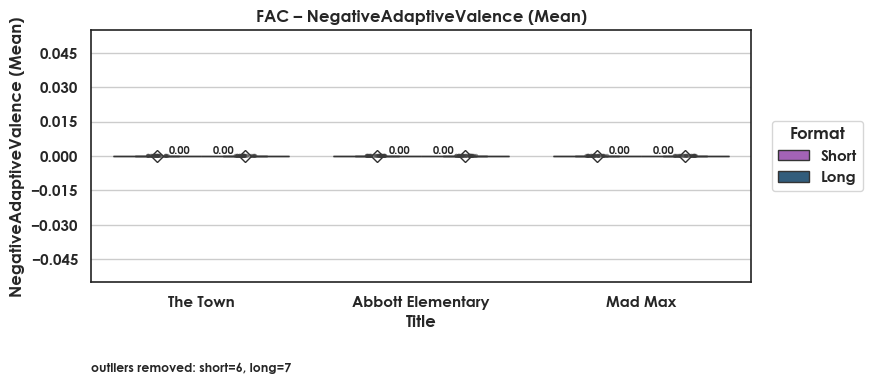

FAC – NegativeAdaptiveValence (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=28, n_short=29).
FAC – NegativeAdaptiveValence (Mean) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=23, n_short=23).
FAC – NegativeAdaptiveValence (Mean) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=25, n_short=24).
FAC – NegativeAdaptiveValence (Mean) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=76, n_short=76).

Analyzing FAC – Neutral (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference   t_stat   p_value  n_pairs
0  157.94072  159.676037   -1.735317 -0.13042  0.896558       82

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


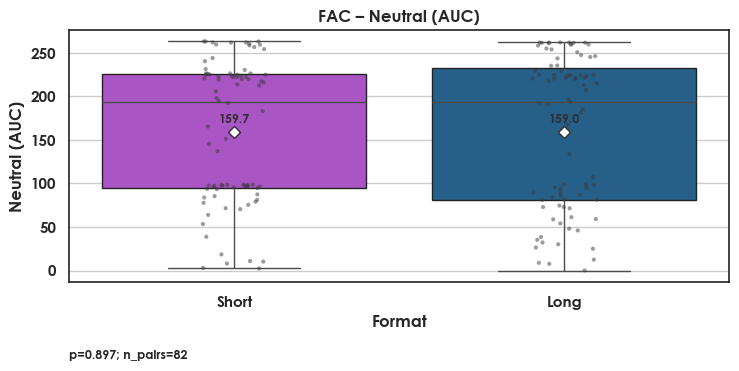

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


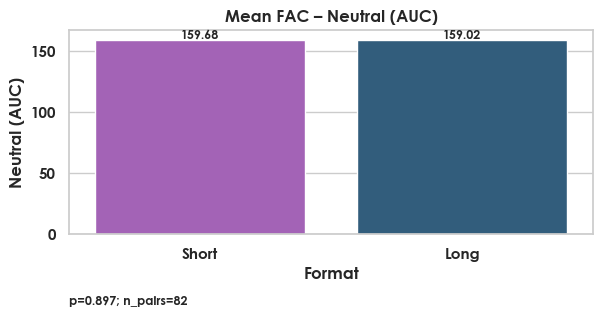

FAC – Neutral (AUC) – Part 1: Long form (158) showed 2 lower than short form (160) (p=0.897, n_pairs=82).


Title   Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   62.239883   75.297583  -13.057700 -1.620605  0.110601   
1            Mad Max  197.757563  209.830558  -12.072995 -1.020696  0.313403   
2           The Town  227.077931  206.881269   20.196662  1.099054  0.277238   

   n_long  n_short  
0      30       30  
1      24       26  
2      29       26

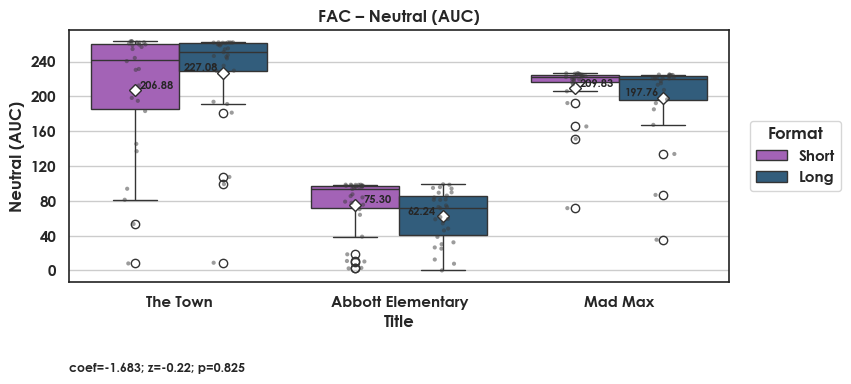

FAC – Neutral (AUC) – Part 2 – Abbott Elementary: Long form (62) showed 13 lower than short form (75) (p=0.111, n_long=30, n_short=30, overall mixed-model p=0.825).
FAC – Neutral (AUC) – Part 2 – Mad Max: Long form (198) showed 12 lower than short form (210) (p=0.313, n_long=24, n_short=26, overall mixed-model p=0.825).
FAC – Neutral (AUC) – Part 2 – The Town: Long form (227) showed 20 greater than short form (207) (p=0.277, n_long=29, n_short=26, overall mixed-model p=0.825).
FAC – Neutral (AUC) – Part 2 (Overall): Long form (162) showed 2 lower than short form (164) (n_long=83, n_short=82, overall mixed-model p=0.825).

Analyzing FAC – Neutral (Binary)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       82

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


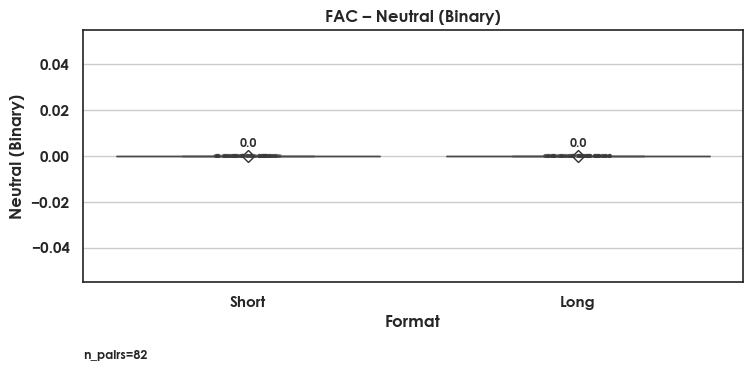

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


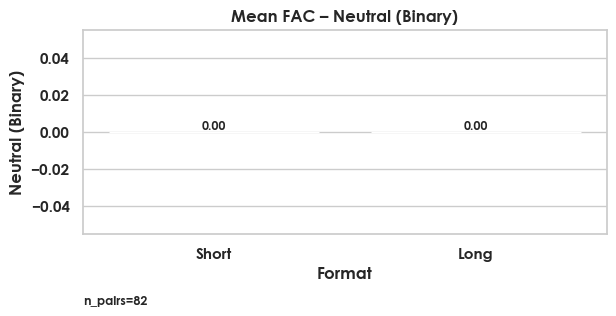

FAC – Neutral (Binary) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=82).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      30       30  
1      24       26  
2      29       26

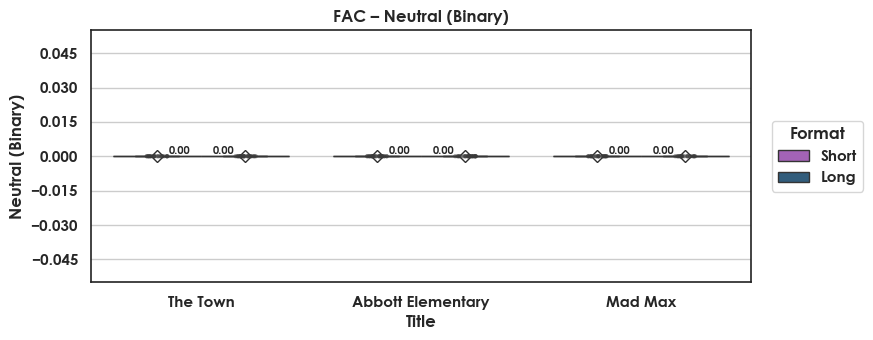

FAC – Neutral (Binary) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=30, n_short=30).
FAC – Neutral (Binary) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=24, n_short=26).
FAC – Neutral (Binary) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=29, n_short=26).
FAC – Neutral (Binary) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=83, n_short=82).

Analyzing FAC – Neutral (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.851896    0.927183   -0.075288 -3.630953  0.000547       68

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


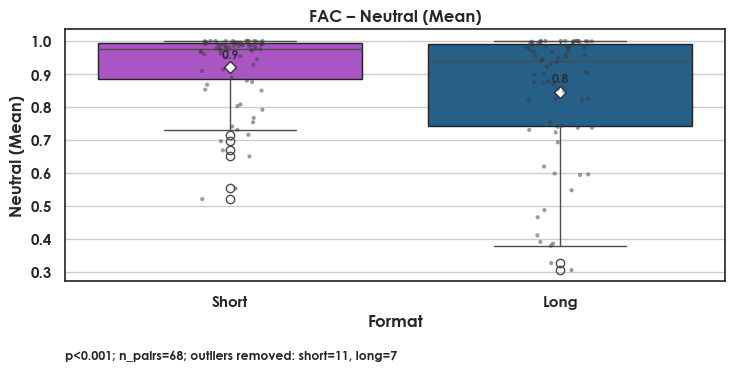

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


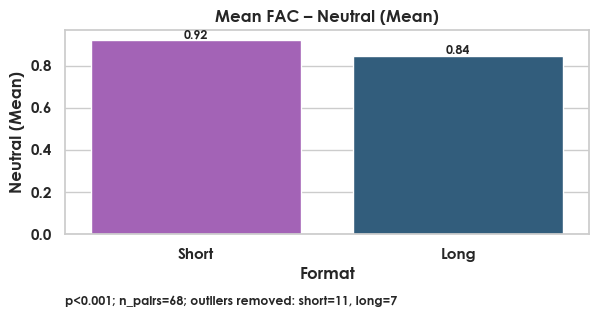

FAC – Neutral (Mean) – Part 1: Long form (1) showed 0 lower than short form (1) (p<0.001, n_pairs=68, outliers removed: short=11, long=7).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.725587    0.920192   -0.194606 -4.088934  0.000241   
1            Mad Max   0.910395    0.951095   -0.040700 -1.139237  0.262688   
2           The Town   0.896601    0.888188    0.008413  0.189376  0.850611   

   n_long  n_short  
0      25       24  
1      23       25  
2      28       22

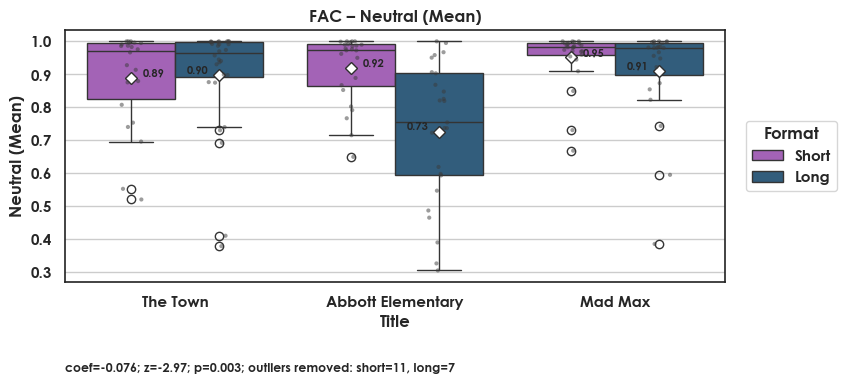

FAC – Neutral (Mean) – Part 2 – Abbott Elementary: Long form (1) showed 0 lower than short form (1) (p<0.001, n_long=25, n_short=24, overall mixed-model p=0.003).
FAC – Neutral (Mean) – Part 2 – Mad Max: Long form (1) showed 0 lower than short form (1) (p=0.263, n_long=23, n_short=25, overall mixed-model p=0.003).
FAC – Neutral (Mean) – Part 2 – The Town: Long form (1) showed 0 greater than short form (1) (p=0.851, n_long=28, n_short=22, overall mixed-model p=0.003).
FAC – Neutral (Mean) – Part 2 (Overall): Long form (1) showed 0 lower than short form (1) (n_long=76, n_short=71, overall mixed-model p=0.003).

Analyzing FAC – NeutralAdaptiveValence (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0  180.210067   181.68264   -1.472573 -0.094941  0.924597       82

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


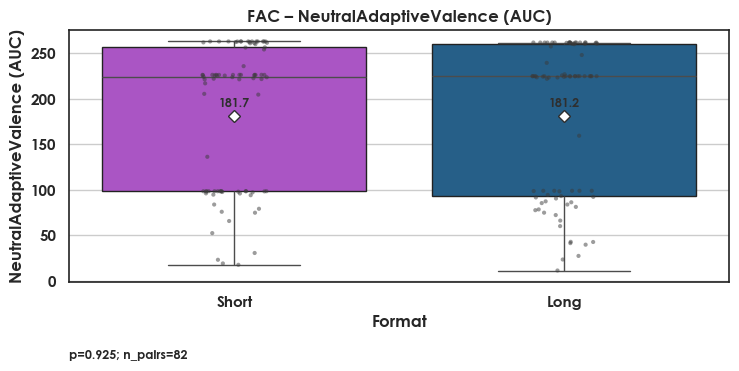

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


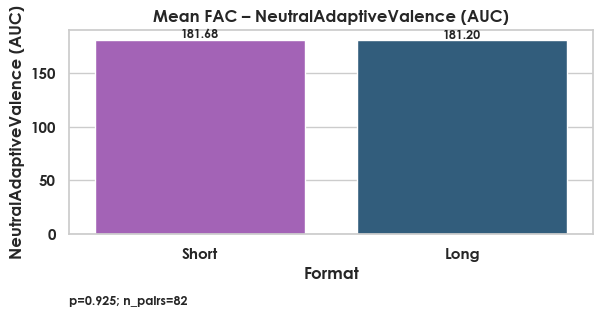

FAC – NeutralAdaptiveValence (AUC) – Part 1: Long form (180) showed 1 lower than short form (182) (p=0.925, n_pairs=82).


Title   Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   74.560983   82.543467   -7.982483 -1.174838  0.244862   
1            Mad Max  221.885625  224.020827   -2.135202 -0.748436  0.460503   
2           The Town  257.831655  253.735808    4.095847  0.732895  0.469126   

   n_long  n_short  
0      30       30  
1      24       26  
2      29       26

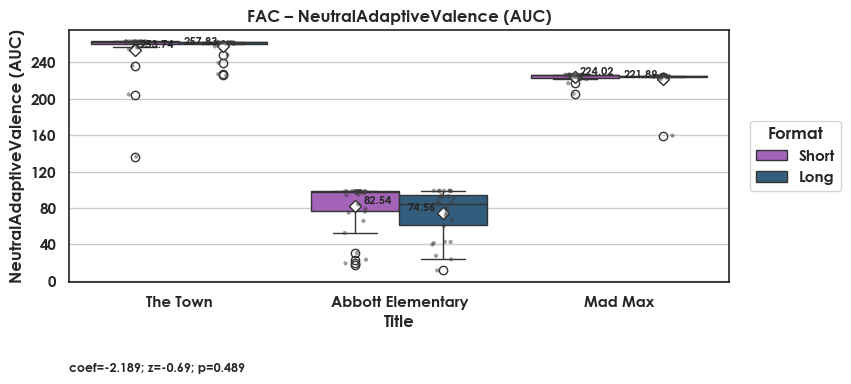

FAC – NeutralAdaptiveValence (AUC) – Part 2 – Abbott Elementary: Long form (75) showed 8 lower than short form (83) (p=0.245, n_long=30, n_short=30, overall mixed-model p=0.489).
FAC – NeutralAdaptiveValence (AUC) – Part 2 – Mad Max: Long form (222) showed 2 lower than short form (224) (p=0.461, n_long=24, n_short=26, overall mixed-model p=0.489).
FAC – NeutralAdaptiveValence (AUC) – Part 2 – The Town: Long form (258) showed 4 greater than short form (254) (p=0.469, n_long=29, n_short=26, overall mixed-model p=0.489).
FAC – NeutralAdaptiveValence (AUC) – Part 2 (Overall): Long form (185) showed 2 lower than short form (187) (n_long=83, n_short=82, overall mixed-model p=0.489).

Analyzing FAC – NeutralAdaptiveValence (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.973805    0.994833   -0.021028 -2.769632  0.007491       60

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


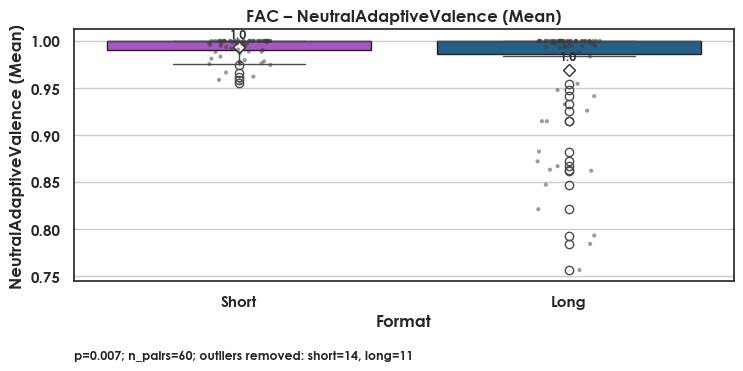

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


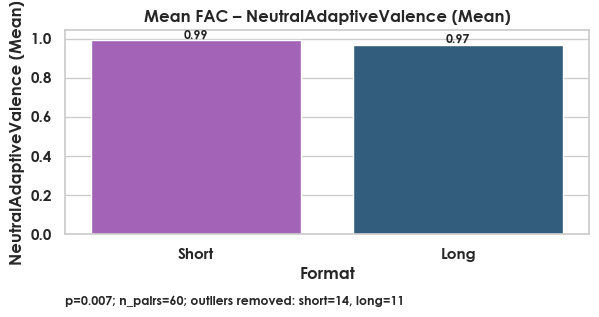

FAC – NeutralAdaptiveValence (Mean) – Part 1: Long form (1) showed 0 lower than short form (1) (p=0.007, n_pairs=60, outliers removed: short=14, long=11).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.914076    0.991876   -0.077800 -4.185121  0.000454   
1            Mad Max   0.998338    0.992593    0.005745  2.570946  0.015582   
2           The Town   0.984214    0.994603   -0.010389 -1.425118  0.163673   

   n_long  n_short  
0      20       20  
1      23       25  
2      29       23

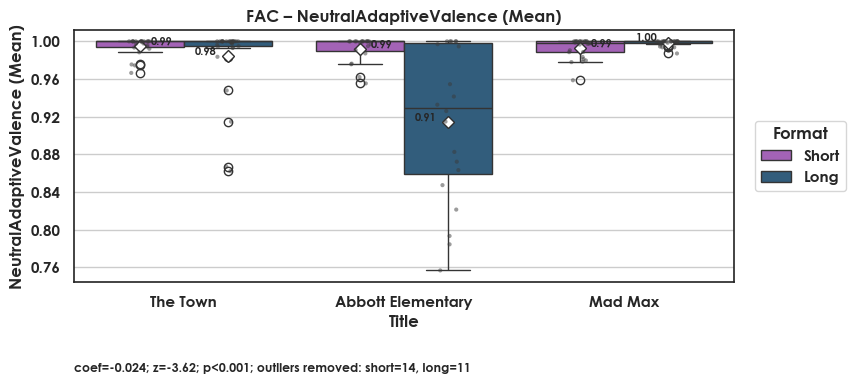

FAC – NeutralAdaptiveValence (Mean) – Part 2 – Abbott Elementary: Long form (1) showed 0 lower than short form (1) (p<0.001, n_long=20, n_short=20, overall mixed-model p<0.001).
FAC – NeutralAdaptiveValence (Mean) – Part 2 – Mad Max: Long form (1) showed 0 greater than short form (1) (p=0.016, n_long=23, n_short=25, overall mixed-model p<0.001).
FAC – NeutralAdaptiveValence (Mean) – Part 2 – The Town: Long form (1) showed 0 lower than short form (1) (p=0.164, n_long=29, n_short=23, overall mixed-model p<0.001).
FAC – NeutralAdaptiveValence (Mean) – Part 2 (Overall): Long form (1) showed 0 lower than short form (1) (n_long=72, n_short=68, overall mixed-model p<0.001).

Analyzing FAC – PositiveAdaptiveValence (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   2.999048    0.886516    2.112532  2.623898  0.010968       62

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


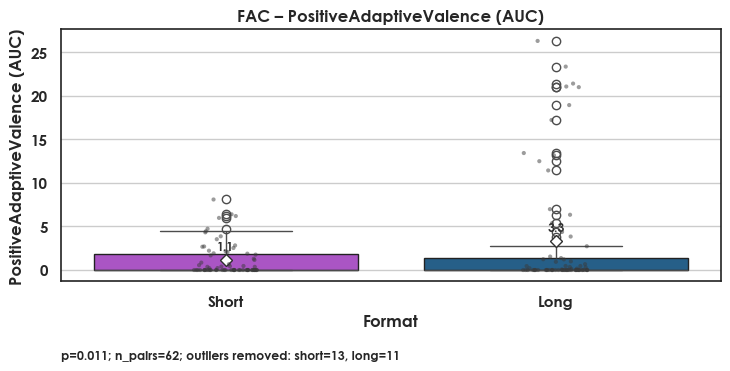

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


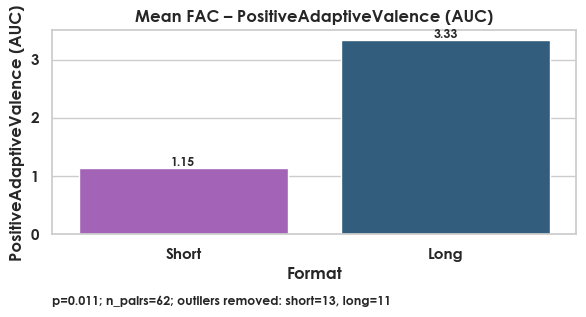

FAC – PositiveAdaptiveValence (AUC) – Part 1: Long form (3) showed 2 greater than short form (1) (p=0.011, n_pairs=62, outliers removed: short=13, long=11).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   8.030881    0.703475    7.327406  3.743336  0.001215   
1            Mad Max   0.280109    1.253580   -0.973471 -2.579656  0.014881   
2           The Town   2.321589    1.400125    0.921464  0.752778  0.456392   

   n_long  n_short  
0      21       20  
1      23       25  
2      28       24

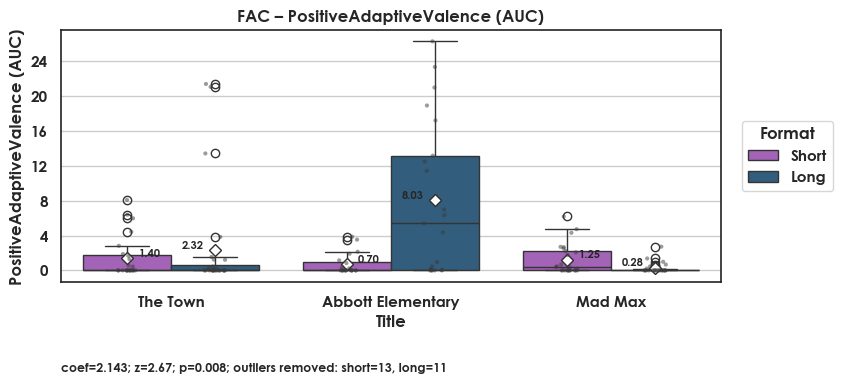

FAC – PositiveAdaptiveValence (AUC) – Part 2 – Abbott Elementary: Long form (8) showed 7 greater than short form (1) (p=0.001, n_long=21, n_short=20, overall mixed-model p=0.008).
FAC – PositiveAdaptiveValence (AUC) – Part 2 – Mad Max: Long form (0) showed 1 lower than short form (1) (p=0.015, n_long=23, n_short=25, overall mixed-model p=0.008).
FAC – PositiveAdaptiveValence (AUC) – Part 2 – The Town: Long form (2) showed 1 greater than short form (1) (p=0.456, n_long=28, n_short=24, overall mixed-model p=0.008).
FAC – PositiveAdaptiveValence (AUC) – Part 2 (Overall): Long form (4) showed 2 greater than short form (1) (n_long=72, n_short=69, overall mixed-model p=0.008).

Analyzing FAC – PositiveAdaptiveValence (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.013493     0.00455    0.008943  1.864553  0.067396       58

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


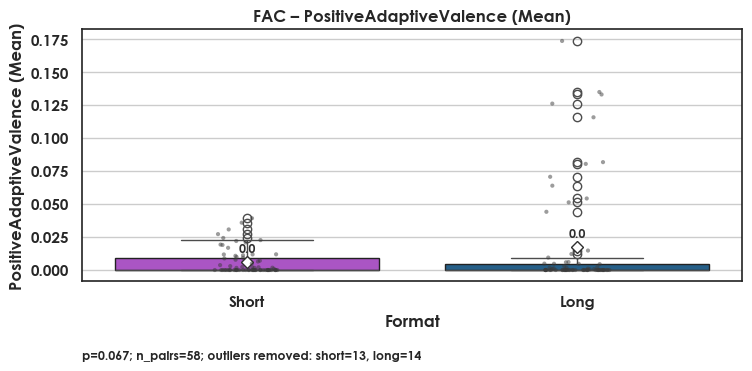

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


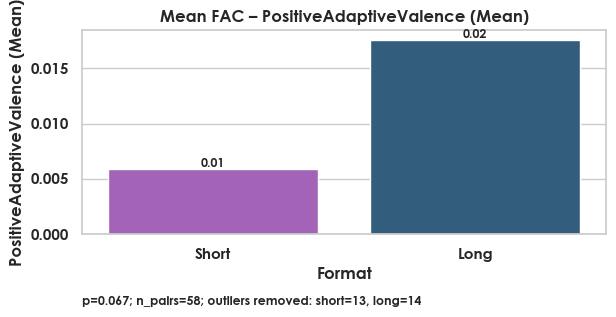

FAC – PositiveAdaptiveValence (Mean) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.067, n_pairs=58, outliers removed: short=13, long=14).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.046957    0.007160    0.039797  2.776425  0.012811   
1            Mad Max   0.001243    0.005529   -0.004285 -2.576151  0.014983   
2           The Town   0.013220    0.005319    0.007900  1.257892  0.217199   

   n_long  n_short  
0      17       20  
1      23       25  
2      29       24

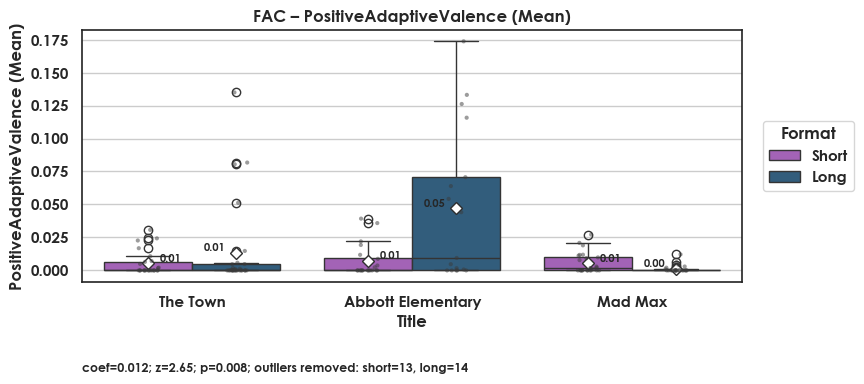

FAC – PositiveAdaptiveValence (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.013, n_long=17, n_short=20, overall mixed-model p=0.008).
FAC – PositiveAdaptiveValence (Mean) – Part 2 – Mad Max: Long form (0) showed 0 lower than short form (0) (p=0.015, n_long=23, n_short=25, overall mixed-model p=0.008).
FAC – PositiveAdaptiveValence (Mean) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (p=0.217, n_long=29, n_short=24, overall mixed-model p=0.008).
FAC – PositiveAdaptiveValence (Mean) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=69, n_short=69, overall mixed-model p=0.008).

Analyzing FAC – Sadness (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.234221    0.178582    0.055639  0.669325  0.505856       61

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


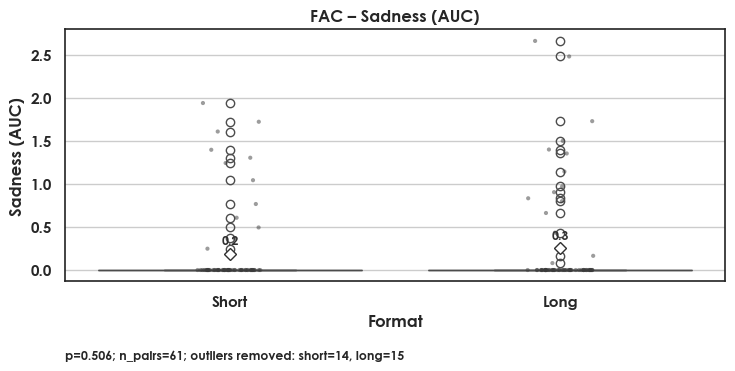

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


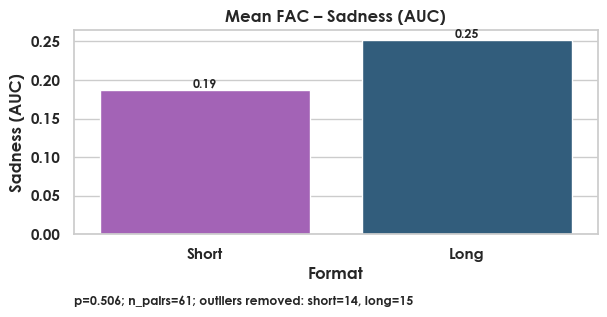

FAC – Sadness (AUC) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.506, n_pairs=61, outliers removed: short=14, long=15).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.344580    0.084685    0.259895  1.865647  0.070708   
1            Mad Max   0.072333    0.333826   -0.261493 -1.759131  0.088253   
2           The Town   0.317659    0.154417    0.163242  0.930556  0.358923   

   n_long  n_short  
0      25       27  
1      21       23  
2      22       18

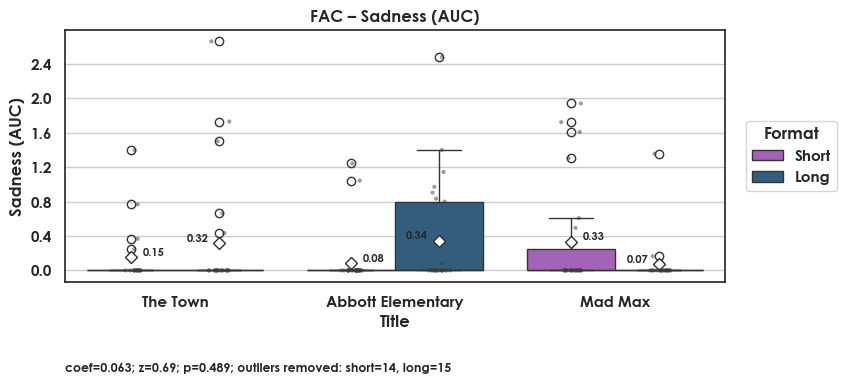

FAC – Sadness (AUC) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.071, n_long=25, n_short=27, overall mixed-model p=0.489).
FAC – Sadness (AUC) – Part 2 – Mad Max: Long form (0) showed 0 lower than short form (0) (p=0.088, n_long=21, n_short=23, overall mixed-model p=0.489).
FAC – Sadness (AUC) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (p=0.359, n_long=22, n_short=18, overall mixed-model p=0.489).
FAC – Sadness (AUC) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=68, n_short=68, overall mixed-model p=0.489).

Analyzing FAC – Sadness (Binary)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       82

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


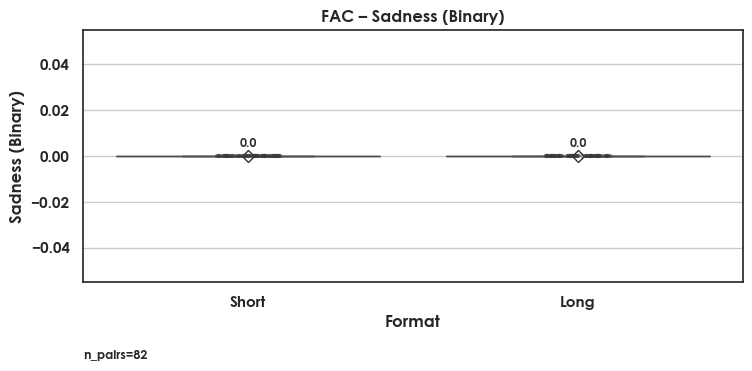

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


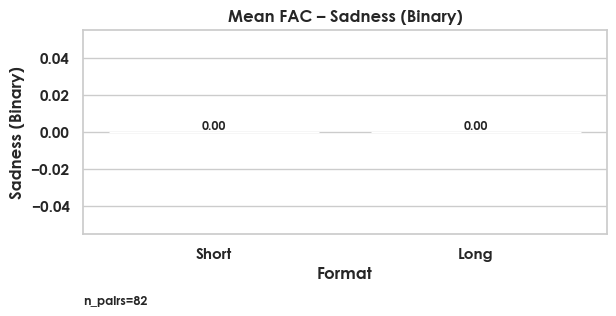

FAC – Sadness (Binary) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=82).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      30       30  
1      24       26  
2      29       26

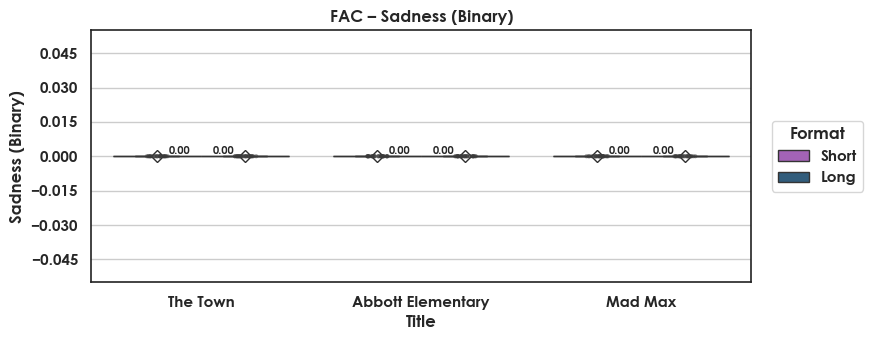

FAC – Sadness (Binary) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=30, n_short=30).
FAC – Sadness (Binary) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=24, n_short=26).
FAC – Sadness (Binary) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=29, n_short=26).
FAC – Sadness (Binary) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=83, n_short=82).

Analyzing FAC – Sadness (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.001243    0.000786    0.000457  1.032108  0.306234       60

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


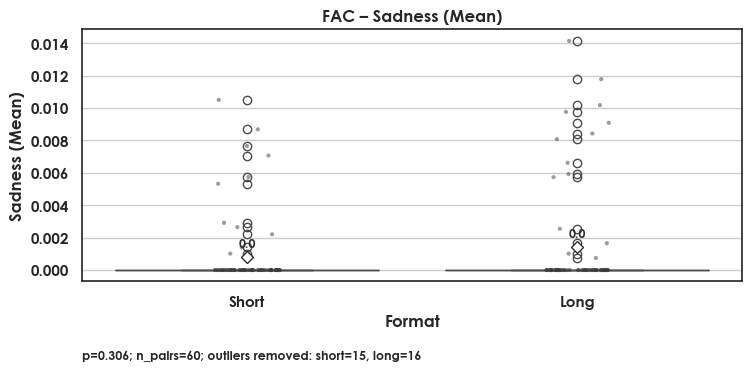

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


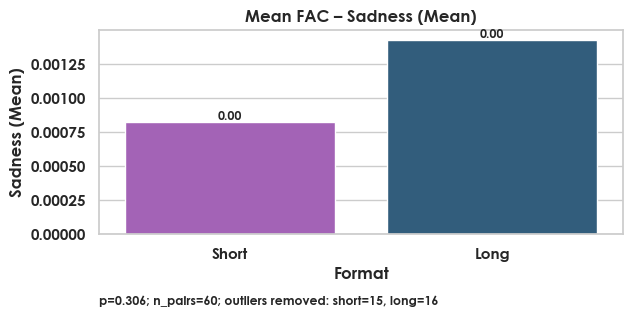

FAC – Sadness (Mean) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.306, n_pairs=60, outliers removed: short=15, long=16).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.058048
  warnings.warn(msg, Con

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.002595    0.000404    0.002191  2.133410  0.040853   
1            Mad Max   0.000317    0.001478   -0.001160 -1.764935  0.087324   
2           The Town   0.001215    0.000591    0.000623  0.930115  0.359161   

   n_long  n_short  
0      24       26  
1      21       23  
2      22       18

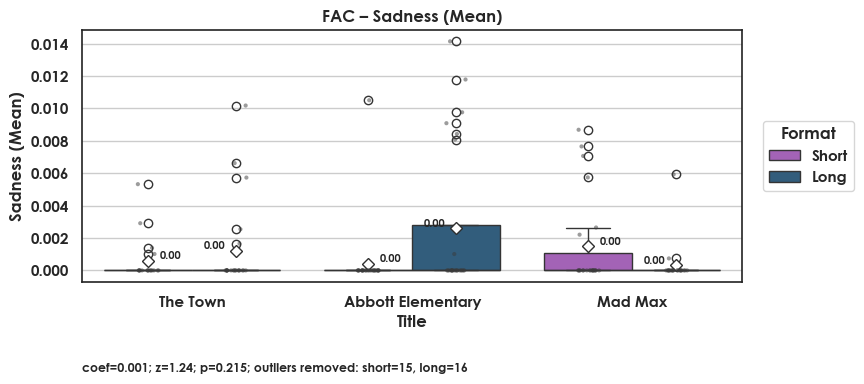

FAC – Sadness (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.041, n_long=24, n_short=26, overall mixed-model p=0.215).
FAC – Sadness (Mean) – Part 2 – Mad Max: Long form (0) showed 0 lower than short form (0) (p=0.087, n_long=21, n_short=23, overall mixed-model p=0.215).
FAC – Sadness (Mean) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (p=0.359, n_long=22, n_short=18, overall mixed-model p=0.215).
FAC – Sadness (Mean) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=67, n_short=67, overall mixed-model p=0.215).

Analyzing FAC – Sentimentality (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.529362    0.205192    0.324169  2.948288  0.004456       65

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


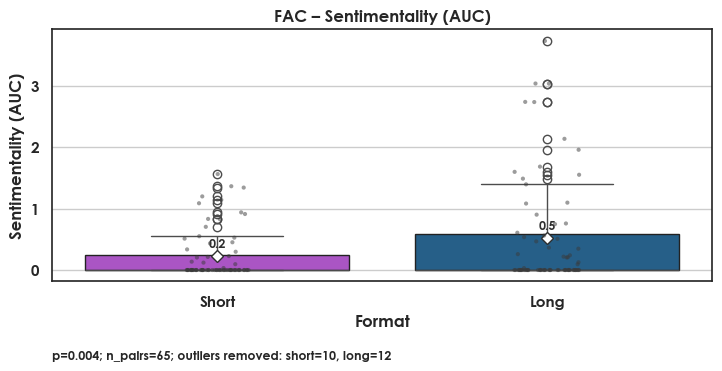

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


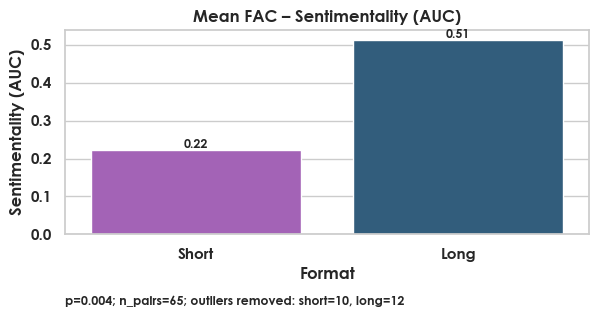

FAC – Sentimentality (AUC) – Part 1: Long form (1) showed 0 greater than short form (0) (p=0.004, n_pairs=65, outliers removed: short=10, long=12).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.999386    0.211080    0.788306  2.852788  0.008438   
1            Mad Max   0.232413    0.324250   -0.091837 -0.662071  0.511316   
2           The Town   0.349615    0.129457    0.220159  1.581121  0.123305   

   n_long  n_short  
0      22       25  
1      23       24  
2      26       23

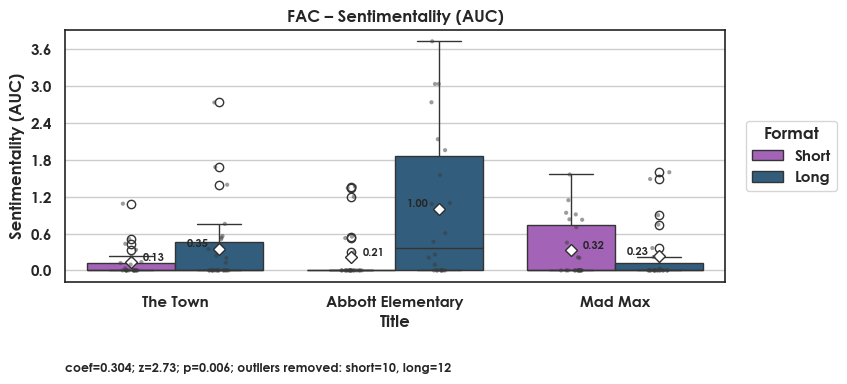

FAC – Sentimentality (AUC) – Part 2 – Abbott Elementary: Long form (1) showed 1 greater than short form (0) (p=0.008, n_long=22, n_short=25, overall mixed-model p=0.006).
FAC – Sentimentality (AUC) – Part 2 – Mad Max: Long form (0) showed 0 lower than short form (0) (p=0.511, n_long=23, n_short=24, overall mixed-model p=0.006).
FAC – Sentimentality (AUC) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (p=0.123, n_long=26, n_short=23, overall mixed-model p=0.006).
FAC – Sentimentality (AUC) – Part 2 (Overall): Long form (1) showed 0 greater than short form (0) (n_long=71, n_short=72, overall mixed-model p=0.006).

Analyzing FAC – Sentimentality (Binary)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       82

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


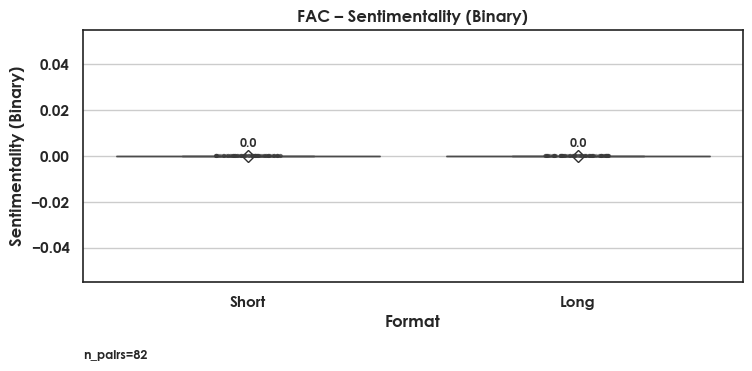

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


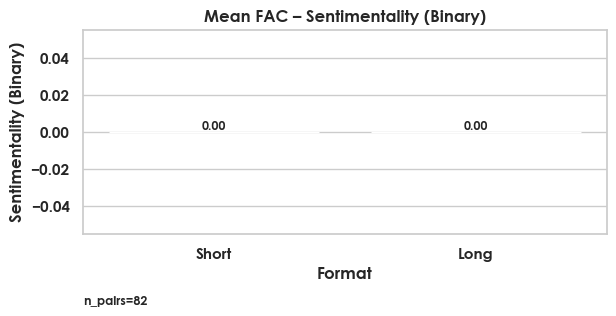

FAC – Sentimentality (Binary) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=82).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      30       30  
1      24       26  
2      29       26

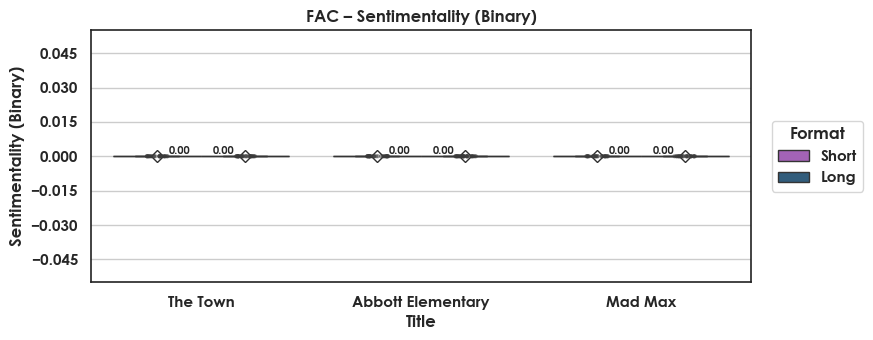

FAC – Sentimentality (Binary) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=30, n_short=30).
FAC – Sentimentality (Binary) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=24, n_short=26).
FAC – Sentimentality (Binary) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=29, n_short=26).
FAC – Sentimentality (Binary) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=83, n_short=82).

Analyzing FAC – Sentimentality (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.002479    0.000839    0.001641  2.302416  0.024797       61

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


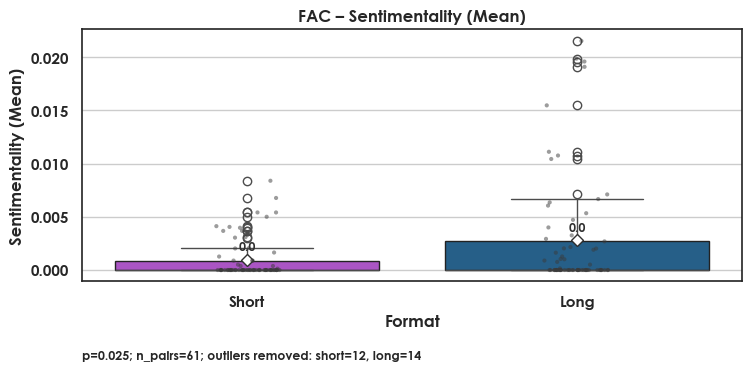

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


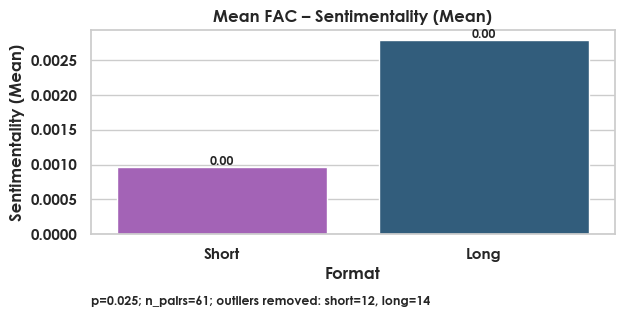

FAC – Sentimentality (Mean) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.025, n_pairs=61, outliers removed: short=12, long=14).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.005294    0.000631    0.004663  2.654203  0.015907   
1            Mad Max   0.001790    0.001702    0.000088  0.088382  0.930056   
2           The Town   0.002008    0.000490    0.001518  1.786891  0.084380   

   n_long  n_short  
0      18       22  
1      24       25  
2      27       23

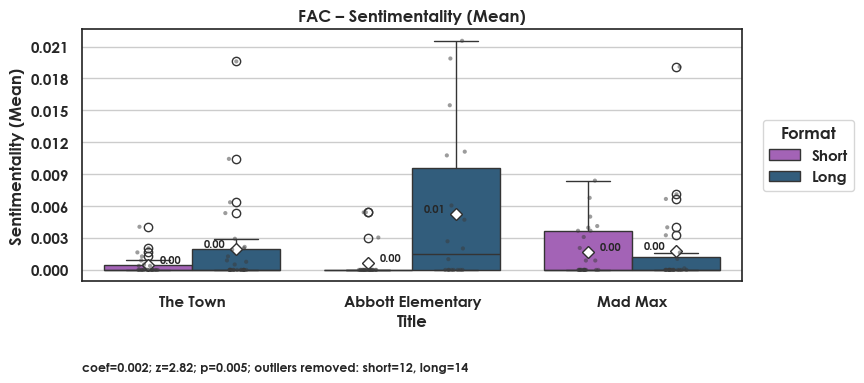

FAC – Sentimentality (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.016, n_long=18, n_short=22, overall mixed-model p=0.005).
FAC – Sentimentality (Mean) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (p=0.930, n_long=24, n_short=25, overall mixed-model p=0.005).
FAC – Sentimentality (Mean) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (p=0.084, n_long=27, n_short=23, overall mixed-model p=0.005).
FAC – Sentimentality (Mean) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=69, n_short=70, overall mixed-model p=0.005).

Analyzing FAC – Surprise (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.055198    0.005095    0.050103  2.194404  0.032297       58

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


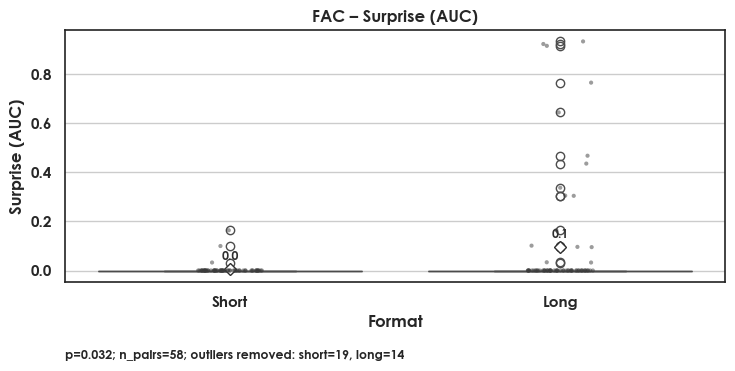

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


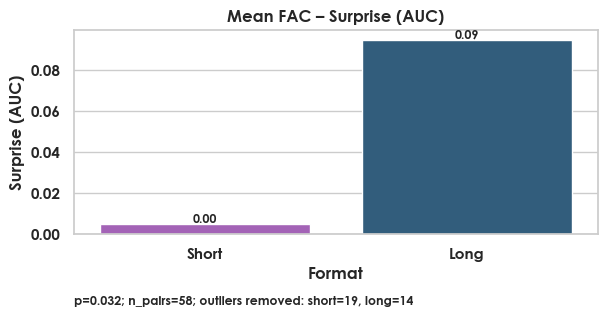

FAC – Surprise (AUC) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.032, n_pairs=58, outliers removed: short=19, long=14).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.143500    0.006812    0.136687  2.291798  0.031148   
1            Mad Max   0.070583    0.000000    0.070583  2.170210  0.044449   
2           The Town   0.067556    0.007333    0.060222  1.368358  0.182527   

   n_long  n_short  
0      24       24  
1      18       21  
2      27       18

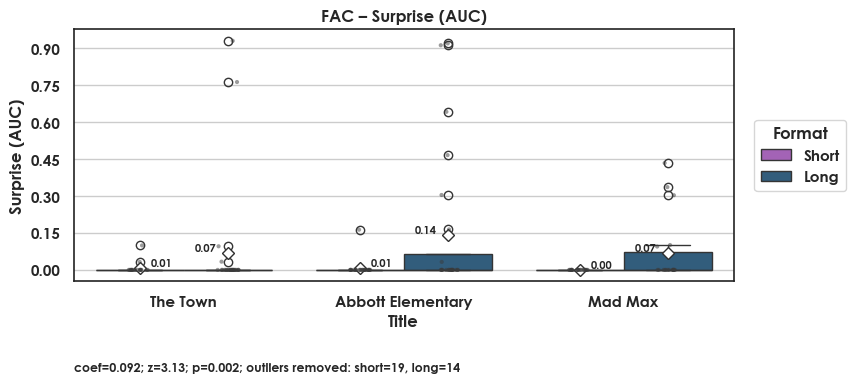

FAC – Surprise (AUC) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.031, n_long=24, n_short=24, overall mixed-model p=0.002).
FAC – Surprise (AUC) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (p=0.044, n_long=18, n_short=21, overall mixed-model p=0.002).
FAC – Surprise (AUC) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (p=0.183, n_long=27, n_short=18, overall mixed-model p=0.002).
FAC – Surprise (AUC) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=69, n_short=63, overall mixed-model p=0.002).

Analyzing FAC – Surprise (Binary)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference  t_stat  p_value  n_pairs
0        0.0         0.0         0.0     NaN      NaN       82

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


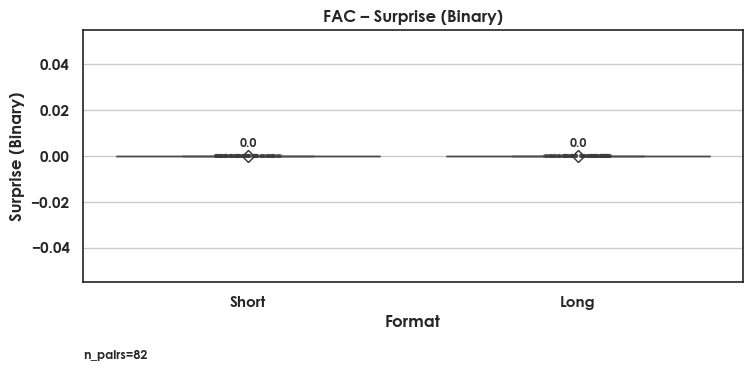

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


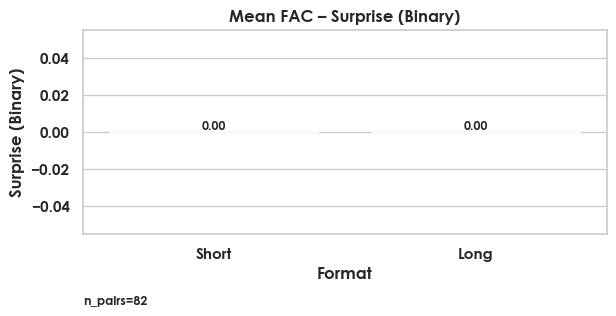

FAC – Surprise (Binary) – Part 1: Long form (0) showed 0 greater than short form (0) (n_pairs=82).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1564: RuntimeWarning: divide by zero encountered in log
  likeval -= self.n_totobs * np.log(qf) / 2.
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

Title  Long mean  Short mean  Difference  t_stat  p_value  \
0  Abbott Elementary        0.0         0.0         0.0     NaN      NaN   
1            Mad Max        0.0         0.0         0.0     NaN      NaN   
2           The Town        0.0         0.0         0.0     NaN      NaN   

   n_long  n_short  
0      30       30  
1      24       26  
2      29       26

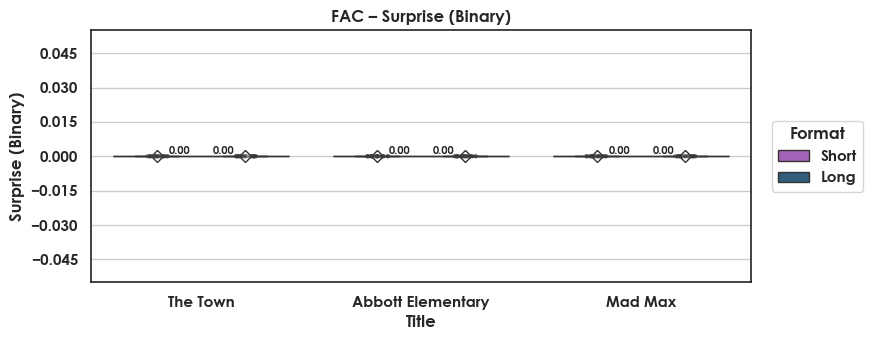

FAC – Surprise (Binary) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (n_long=30, n_short=30).
FAC – Surprise (Binary) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (n_long=24, n_short=26).
FAC – Surprise (Binary) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (n_long=29, n_short=26).
FAC – Surprise (Binary) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=83, n_short=82).

Analyzing FAC – Surprise (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.000209    0.000009      0.0002  1.875111  0.066189       55

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


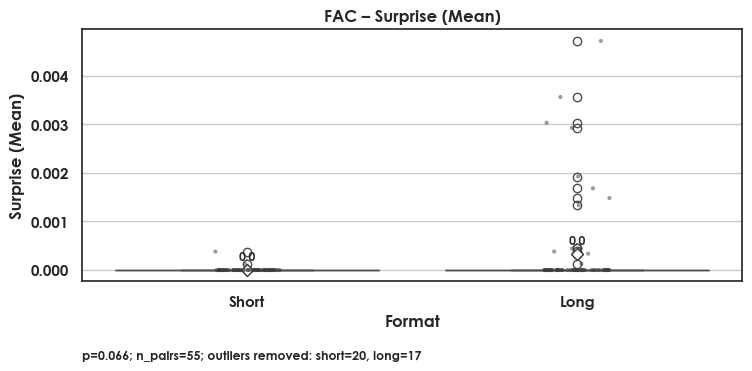

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


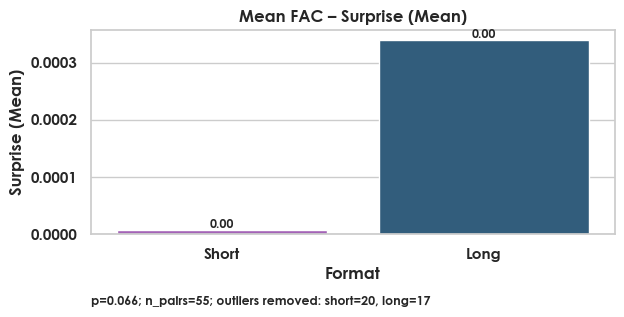

FAC – Surprise (Mean) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.066, n_pairs=55, outliers removed: short=20, long=17).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.000465    0.000000    0.000465  1.744951  0.096341   
1            Mad Max   0.000313    0.000000    0.000313  2.176942  0.043867   
2           The Town   0.000259    0.000028    0.000231  1.370830  0.181764   

   n_long  n_short  
0      21       23  
1      18       21  
2      27       18

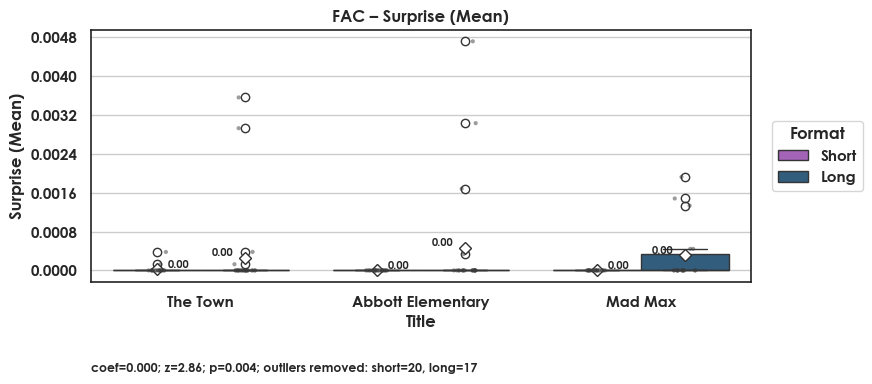

FAC – Surprise (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.096, n_long=21, n_short=23, overall mixed-model p=0.004).
FAC – Surprise (Mean) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (p=0.044, n_long=18, n_short=21, overall mixed-model p=0.004).
FAC – Surprise (Mean) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (p=0.182, n_long=27, n_short=18, overall mixed-model p=0.004).
FAC – Surprise (Mean) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=66, n_short=62, overall mixed-model p=0.004).

##########################################################################################
Running analyses for sensor: GSR
##########################################################################################

Analyzing GSR – PeakDetected (Binary)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.740741    0.716049    0.024691  0.532152  0.596096       81

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


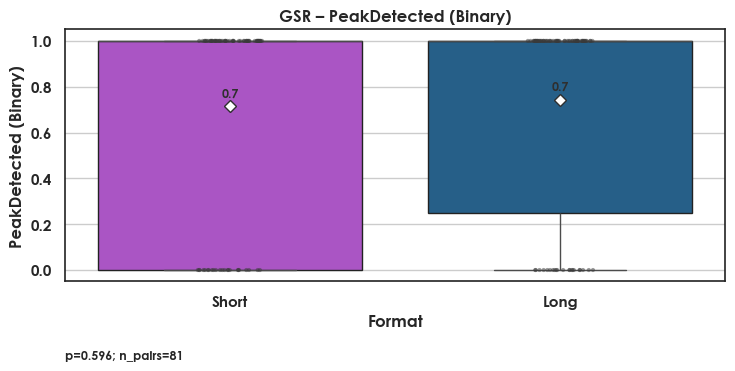

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


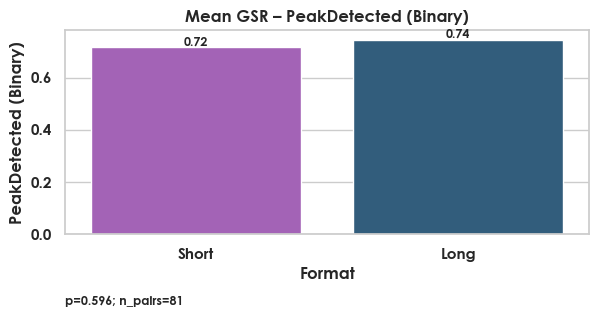

GSR – PeakDetected (Binary) – Part 1: Long form (1) showed 0 greater than short form (1) (p=0.596, n_pairs=81).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.600000    0.666667   -0.066667 -0.528059  0.599476   
1            Mad Max   0.782609    0.730769    0.051839  0.415007  0.680031   
2           The Town   0.862069    0.760000    0.102069  0.937769  0.353261   

   n_long  n_short  
0      30       30  
1      23       26  
2      29       25

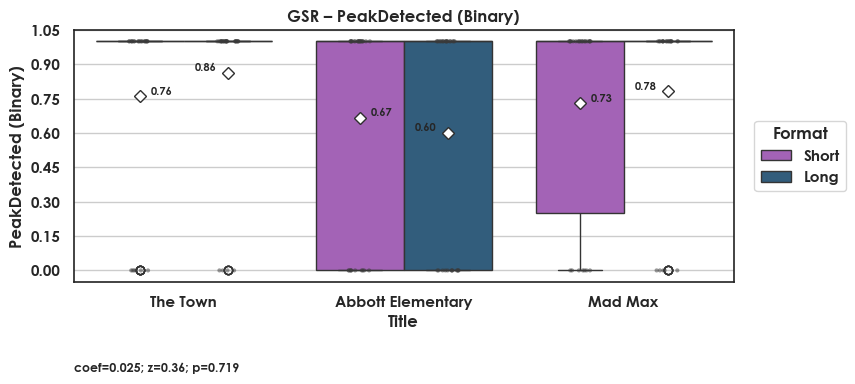

GSR – PeakDetected (Binary) – Part 2 – Abbott Elementary: Long form (1) showed 0 lower than short form (1) (p=0.599, n_long=30, n_short=30, overall mixed-model p=0.719).
GSR – PeakDetected (Binary) – Part 2 – Mad Max: Long form (1) showed 0 greater than short form (1) (p=0.680, n_long=23, n_short=26, overall mixed-model p=0.719).
GSR – PeakDetected (Binary) – Part 2 – The Town: Long form (1) showed 0 greater than short form (1) (p=0.353, n_long=29, n_short=25, overall mixed-model p=0.719).
GSR – PeakDetected (Binary) – Part 2 (Overall): Long form (1) showed 0 greater than short form (1) (n_long=82, n_short=81, overall mixed-model p=0.719).

Analyzing GSR – Peaks (Count)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean   Short mean  Difference    t_stat   p_value  n_pairs
0  2224.509804  1812.176471  412.333333  1.542166  0.129339       51

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


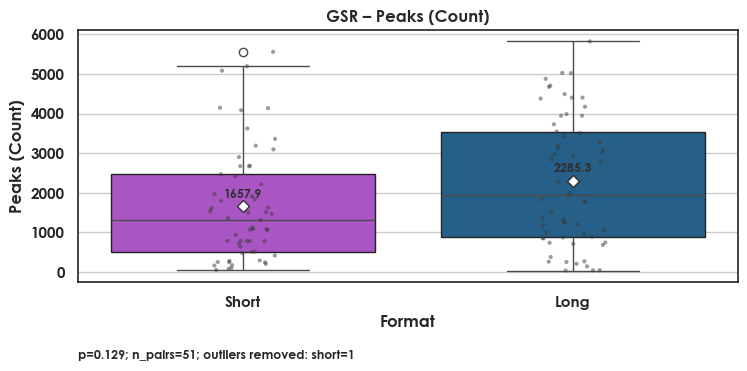

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


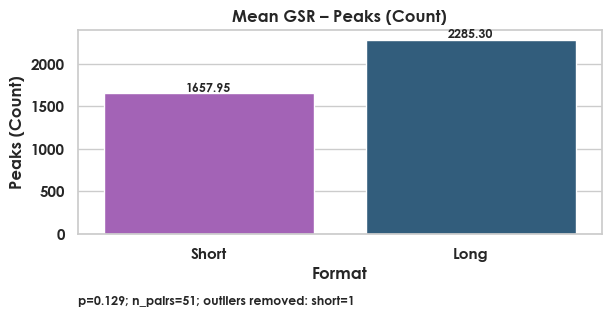

GSR – Peaks (Count) – Part 1: Long form (2225) showed 412 greater than short form (1812) (p=0.129, n_pairs=51, outliers removed: short=1).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


Title    Long mean   Short mean  Difference    t_stat  \
0  Abbott Elementary  1039.000000   891.650000   147.35000  0.793071   
1            Mad Max  3582.111111  1882.368421  1699.74269  4.505322   
2           The Town  2248.920000  2272.500000   -23.58000 -0.041916   

    p_value  n_long  n_short  
0  0.433616      18       20  
1  0.000080      18       19  
2  0.966795      25       18

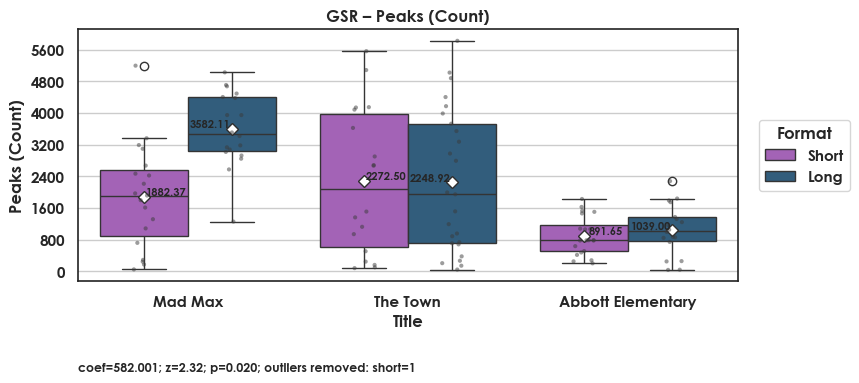

GSR – Peaks (Count) – Part 2 – Abbott Elementary: Long form (1039) showed 147 greater than short form (892) (p=0.434, n_long=18, n_short=20, overall mixed-model p=0.020).
GSR – Peaks (Count) – Part 2 – Mad Max: Long form (3582) showed 1700 greater than short form (1882) (p<0.001, n_long=18, n_short=19, overall mixed-model p=0.020).
GSR – Peaks (Count) – Part 2 – The Town: Long form (2249) showed 24 lower than short form (2272) (p=0.967, n_long=25, n_short=18, overall mixed-model p=0.020).
GSR – Peaks (Count) – Part 2 (Overall): Long form (2290) showed 608 greater than short form (1682) (n_long=61, n_short=57, overall mixed-model p=0.020).

Analyzing GSR – Peaks (PerMinute)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0  694.001385  587.864162  106.137223  2.060411  0.044478       52

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


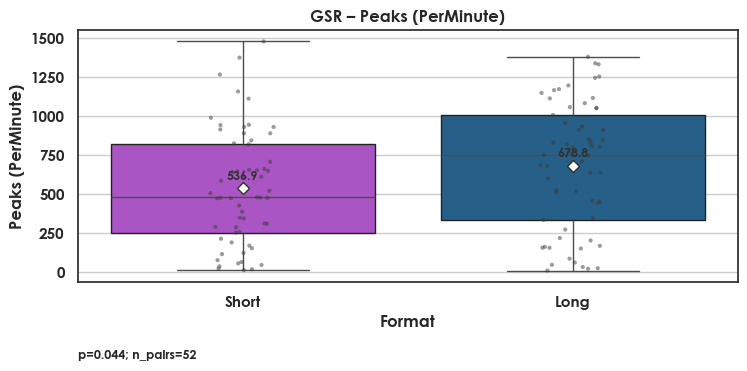

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


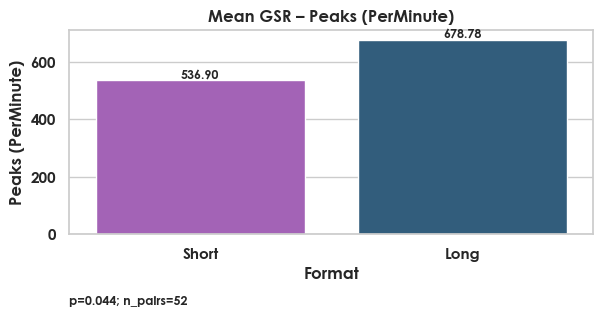

GSR – Peaks (PerMinute) – Part 1: Long form (694) showed 106 greater than short form (588) (p=0.044, n_pairs=52).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


Title   Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary  629.730129  543.003326   86.726803  0.768908  0.447608   
1            Mad Max  955.248335  498.710943  456.537392  4.557226  0.000069   
2           The Town  515.027671  568.666302  -53.638630 -0.399276  0.692025   

   n_long  n_short  
0      18       20  
1      18       19  
2      25       19

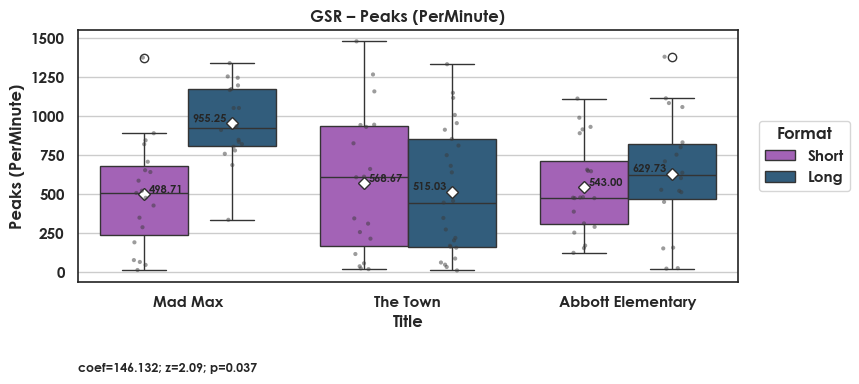

GSR – Peaks (PerMinute) – Part 2 – Abbott Elementary: Long form (630) showed 87 greater than short form (543) (p=0.448, n_long=18, n_short=20, overall mixed-model p=0.037).
GSR – Peaks (PerMinute) – Part 2 – Mad Max: Long form (955) showed 457 greater than short form (499) (p<0.001, n_long=18, n_short=19, overall mixed-model p=0.037).
GSR – Peaks (PerMinute) – Part 2 – The Town: Long form (515) showed 54 lower than short form (569) (p=0.692, n_long=25, n_short=19, overall mixed-model p=0.037).
GSR – Peaks (PerMinute) – Part 2 (Overall): Long form (700) showed 163 greater than short form (537) (n_long=61, n_short=58, overall mixed-model p=0.037).

##########################################################################################
Running analyses for sensor: ET
##########################################################################################

Analyzing ET – Blink (Count)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0  250.275862       242.0    8.275862  0.312109  0.756096       58

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


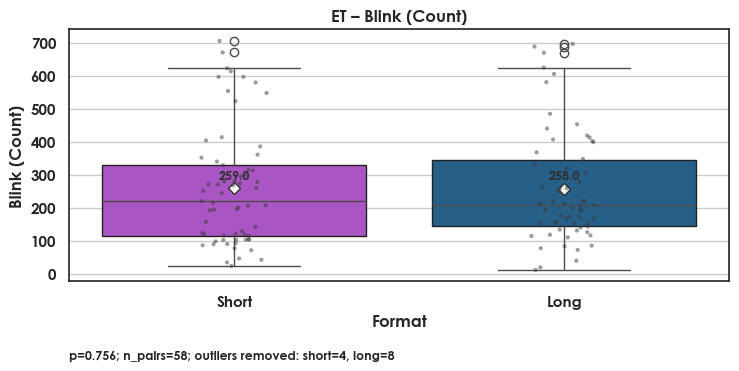

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


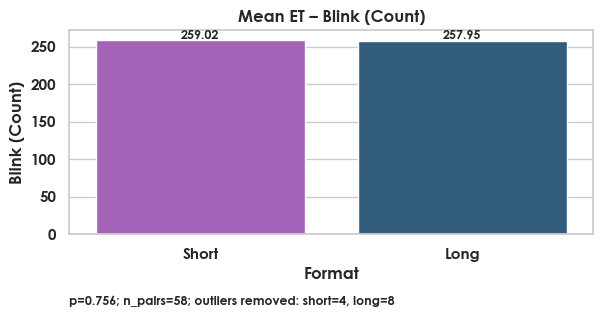

ET – Blink (Count) – Part 1: Long form (250) showed 8 greater than short form (242) (p=0.756, n_pairs=58, outliers removed: short=4, long=8).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title   Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary  203.545455  196.266667    7.278788  0.220252  0.826573   
1            Mad Max  272.250000  322.904762  -50.654762 -0.795071  0.431410   
2           The Town  303.500000  297.642857    5.857143  0.096724  0.923561   

   n_long  n_short  
0      22       30  
1      20       21  
2      20       14

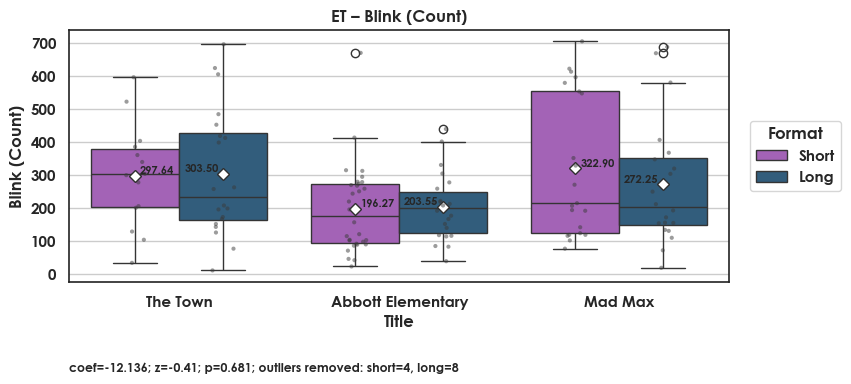

ET – Blink (Count) – Part 2 – Abbott Elementary: Long form (204) showed 7 greater than short form (196) (p=0.827, n_long=22, n_short=30, overall mixed-model p=0.681).
ET – Blink (Count) – Part 2 – Mad Max: Long form (272) showed 51 lower than short form (323) (p=0.431, n_long=20, n_short=21, overall mixed-model p=0.681).
ET – Blink (Count) – Part 2 – The Town: Long form (304) showed 6 greater than short form (298) (p=0.924, n_long=20, n_short=14, overall mixed-model p=0.681).
ET – Blink (Count) – Part 2 (Overall): Long form (260) showed 13 lower than short form (272) (n_long=62, n_short=65, overall mixed-model p=0.681).

Analyzing ET – Blink (Rate)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0  100.731164    95.94569    4.785474  0.795702  0.429146       65

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


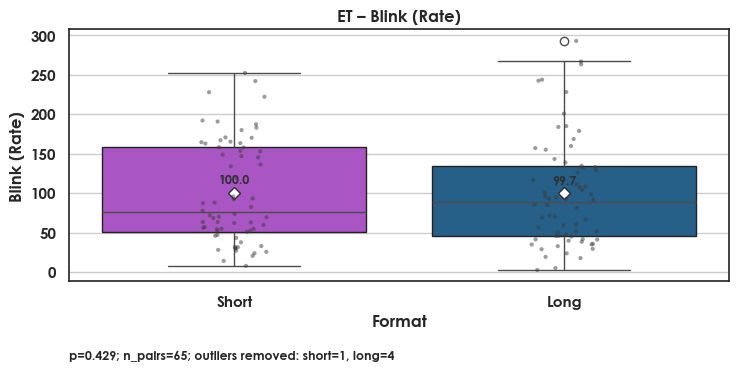

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


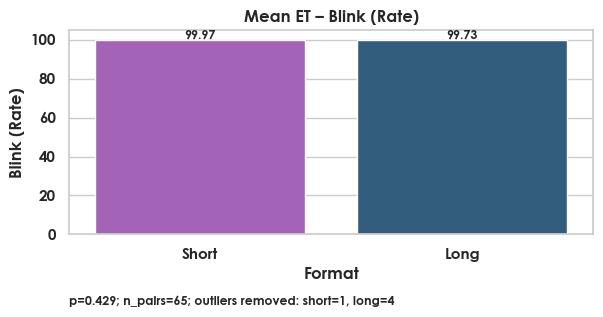

ET – Blink (Rate) – Part 1: Long form (101) showed 5 greater than short form (96) (p=0.429, n_pairs=65, outliers removed: short=1, long=4).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title   Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary  123.367485  109.563148   13.804337  0.779862  0.439469   
1            Mad Max   80.002119   85.550128   -5.548009 -0.305875  0.761290   
2           The Town   95.139405  101.352932   -6.213527 -0.260590  0.795813   

   n_long  n_short  
0      22       29  
1      21       21  
2      23       18

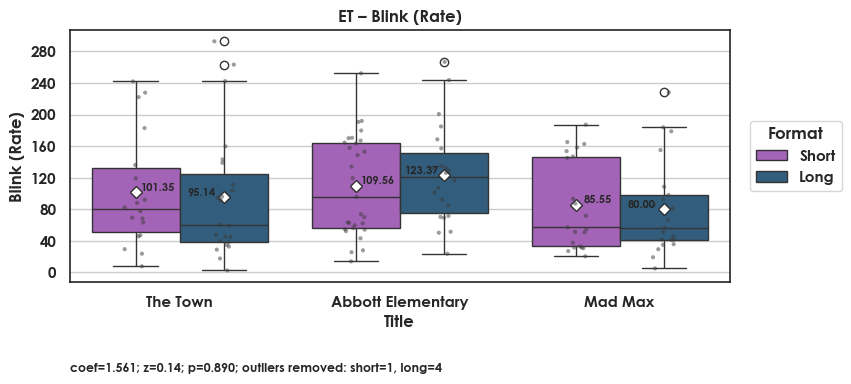

ET – Blink (Rate) – Part 2 – Abbott Elementary: Long form (123) showed 14 greater than short form (110) (p=0.439, n_long=22, n_short=29, overall mixed-model p=0.890).
ET – Blink (Rate) – Part 2 – Mad Max: Long form (80) showed 6 lower than short form (86) (p=0.761, n_long=21, n_short=21, overall mixed-model p=0.890).
ET – Blink (Rate) – Part 2 – The Town: Long form (95) showed 6 lower than short form (101) (p=0.796, n_long=23, n_short=18, overall mixed-model p=0.890).
ET – Blink (Rate) – Part 2 (Overall): Long form (100) showed 1 greater than short form (99) (n_long=66, n_short=68, overall mixed-model p=0.890).

Analyzing ET – Fixation (Count)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference   t_stat   p_value  n_pairs
0  440.743902  438.560976    2.182927  0.07015  0.944247       82

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


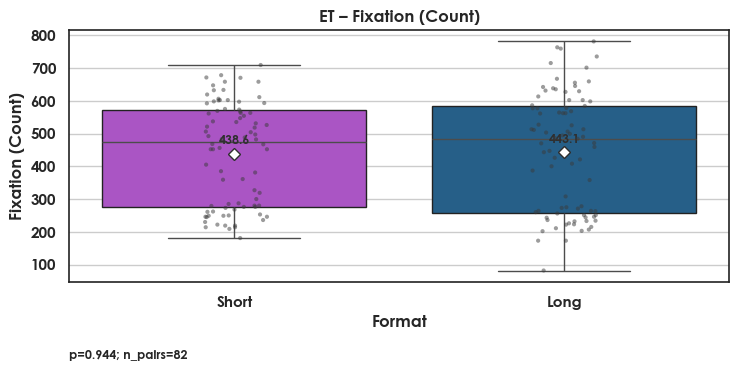

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


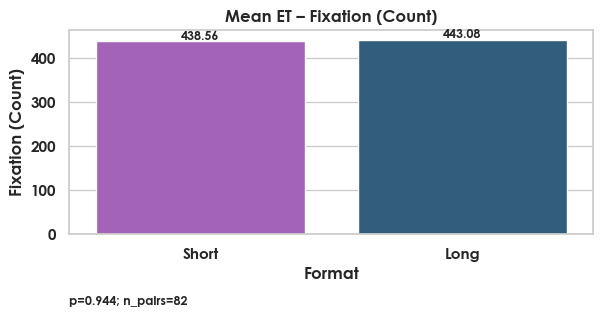

ET – Fixation (Count) – Part 1: Long form (441) showed 2 greater than short form (439) (p=0.944, n_pairs=82).


Title   Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary  233.966667  255.166667  -21.200000 -2.161735  0.034987   
1            Mad Max  506.041667  500.269231    5.772436  0.270654  0.787830   
2           The Town  607.310345  588.461538   18.848806  0.830468  0.410419   

   n_long  n_short  
0      30       30  
1      24       26  
2      29       26

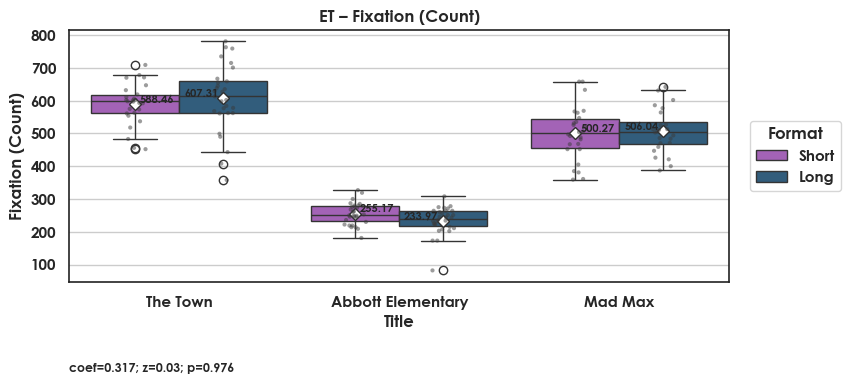

ET – Fixation (Count) – Part 2 – Abbott Elementary: Long form (234) showed 21 lower than short form (255) (p=0.035, n_long=30, n_short=30, overall mixed-model p=0.976).
ET – Fixation (Count) – Part 2 – Mad Max: Long form (506) showed 6 greater than short form (500) (p=0.788, n_long=24, n_short=26, overall mixed-model p=0.976).
ET – Fixation (Count) – Part 2 – The Town: Long form (607) showed 19 greater than short form (588) (p=0.410, n_long=29, n_short=26, overall mixed-model p=0.976).
ET – Fixation (Count) – Part 2 (Overall): Long form (449) showed 1 greater than short form (448) (n_long=83, n_short=82, overall mixed-model p=0.976).

Analyzing ET – Fixation (PerMinute)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0  139.731759  140.448197   -0.716438 -0.345183  0.730898       78

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


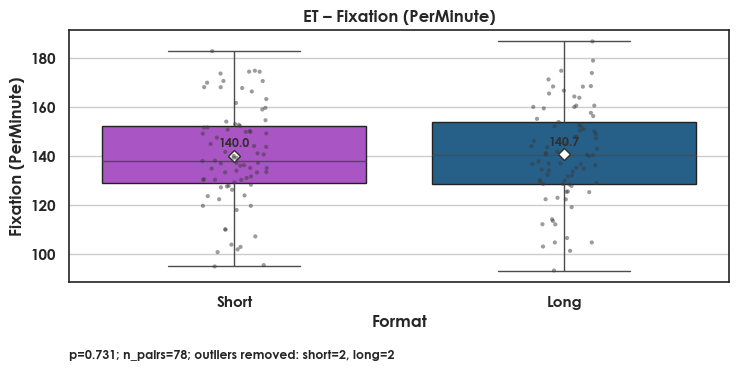

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


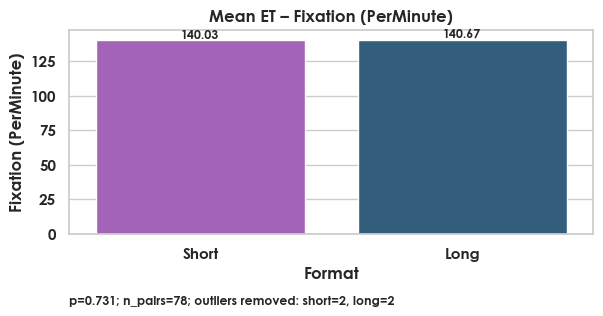

ET – Fixation (PerMinute) – Part 1: Long form (140) showed 1 lower than short form (140) (p=0.731, n_pairs=78, outliers removed: short=2, long=2).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title   Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary  144.981200  152.446586   -7.465386 -1.541820  0.128859   
1            Mad Max  134.947668  132.539441    2.408228  0.424946  0.672793   
2           The Town  141.120146  134.148208    6.971938  1.426903  0.160052   

   n_long  n_short  
0      29       28  
1      24       26  
2      28       26

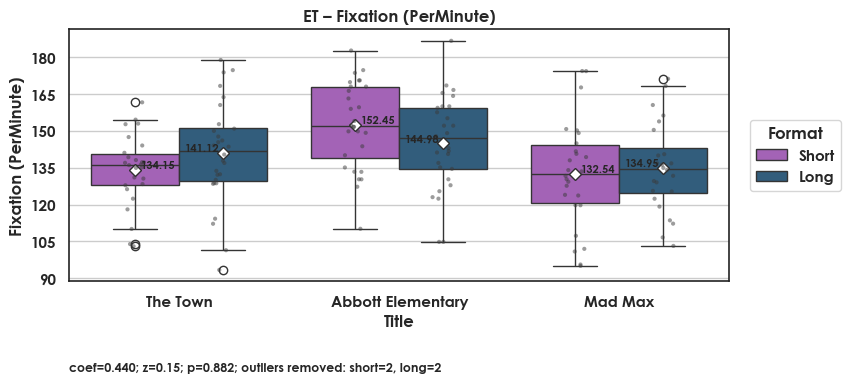

ET – Fixation (PerMinute) – Part 2 – Abbott Elementary: Long form (145) showed 7 lower than short form (152) (p=0.129, n_long=29, n_short=28, overall mixed-model p=0.882).
ET – Fixation (PerMinute) – Part 2 – Mad Max: Long form (135) showed 2 greater than short form (133) (p=0.673, n_long=24, n_short=26, overall mixed-model p=0.882).
ET – Fixation (PerMinute) – Part 2 – The Town: Long form (141) showed 7 greater than short form (134) (p=0.160, n_long=28, n_short=26, overall mixed-model p=0.882).
ET – Fixation (PerMinute) – Part 2 (Overall): Long form (140) showed 1 greater than short form (140) (n_long=81, n_short=80, overall mixed-model p=0.882).

Analyzing ET – FixationDispersion (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.471971     0.47635    -0.00438 -0.426943  0.670628       77

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


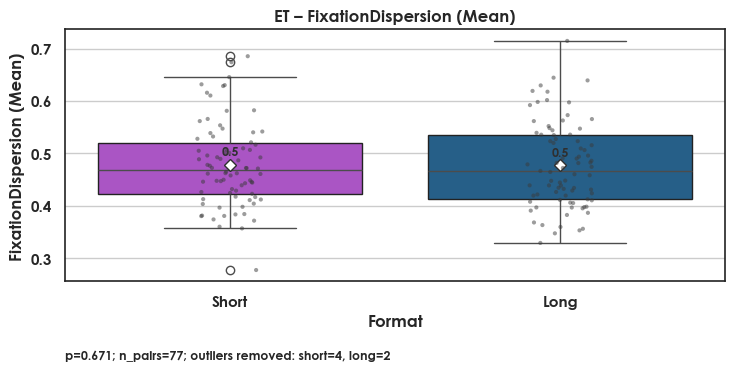

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


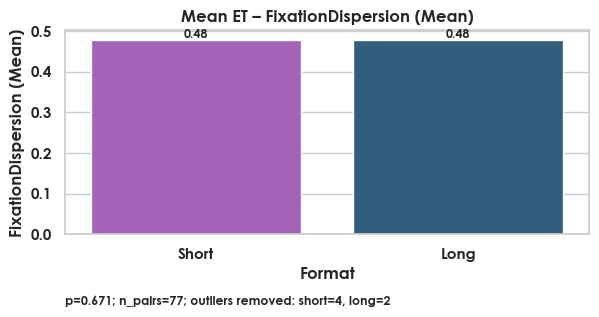

ET – FixationDispersion (Mean) – Part 1: Long form (0) showed 0 lower than short form (0) (p=0.671, n_pairs=77, outliers removed: short=4, long=2).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.465366    0.438750    0.026616  1.508638  0.136944   
1            Mad Max   0.442349    0.507345   -0.064995 -2.699872  0.009698   
2           The Town   0.521628    0.497946    0.023682  1.128726  0.264512   

   n_long  n_short  
0      30       30  
1      24       24  
2      27       24

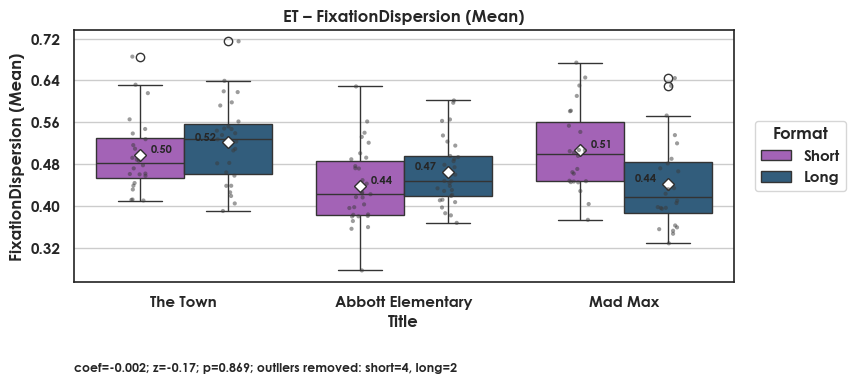

ET – FixationDispersion (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.137, n_long=30, n_short=30, overall mixed-model p=0.869).
ET – FixationDispersion (Mean) – Part 2 – Mad Max: Long form (0) showed 0 lower than short form (1) (p=0.010, n_long=24, n_short=24, overall mixed-model p=0.869).
ET – FixationDispersion (Mean) – Part 2 – The Town: Long form (1) showed 0 greater than short form (0) (p=0.265, n_long=27, n_short=24, overall mixed-model p=0.869).
ET – FixationDispersion (Mean) – Part 2 (Overall): Long form (0) showed 0 lower than short form (0) (n_long=81, n_short=78, overall mixed-model p=0.869).

Analyzing ET – FixationDuration (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0  563.342334  575.557679  -12.215345 -0.705324  0.482853       74

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


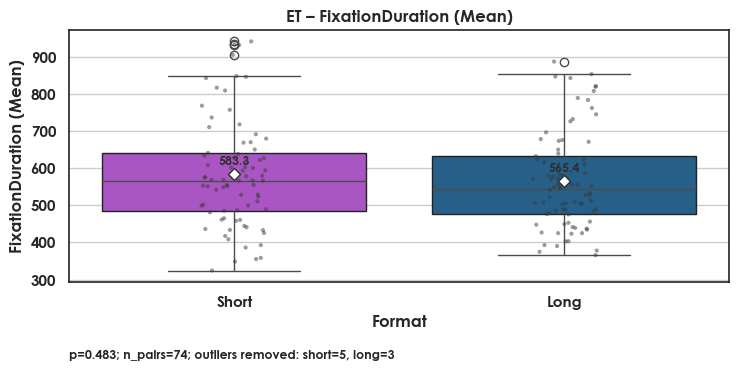

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


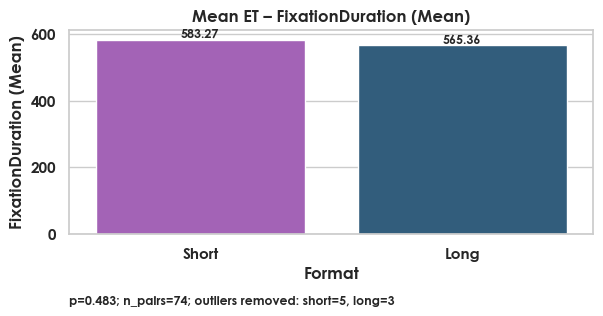

ET – FixationDuration (Mean) – Part 1: Long form (563) showed 12 lower than short form (576) (p=0.483, n_pairs=74, outliers removed: short=5, long=3).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title   Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary  528.943535  525.083322    3.860213  0.119018  0.905710   
1            Mad Max  593.253354  632.928122  -39.674768 -0.849916  0.400383   
2           The Town  582.047537  610.310014  -28.262477 -0.823846  0.414009   

   n_long  n_short  
0      30       30  
1      23       21  
2      27       26

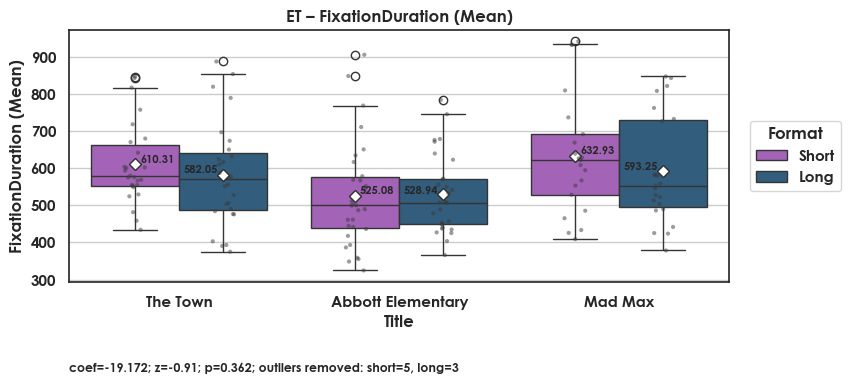

ET – FixationDuration (Mean) – Part 2 – Abbott Elementary: Long form (529) showed 4 greater than short form (525) (p=0.906, n_long=30, n_short=30, overall mixed-model p=0.362).
ET – FixationDuration (Mean) – Part 2 – Mad Max: Long form (593) showed 40 lower than short form (633) (p=0.400, n_long=23, n_short=21, overall mixed-model p=0.362).
ET – FixationDuration (Mean) – Part 2 – The Town: Long form (582) showed 28 lower than short form (610) (p=0.414, n_long=27, n_short=26, overall mixed-model p=0.362).
ET – FixationDuration (Mean) – Part 2 (Overall): Long form (568) showed 21 lower than short form (589) (n_long=80, n_short=77, overall mixed-model p=0.362).

##########################################################################################
Running analyses for sensor: EEG
##########################################################################################

Analyzing EEG – Distraction (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0  13.903122   21.402778   -7.499656 -2.847114  0.006342       52

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


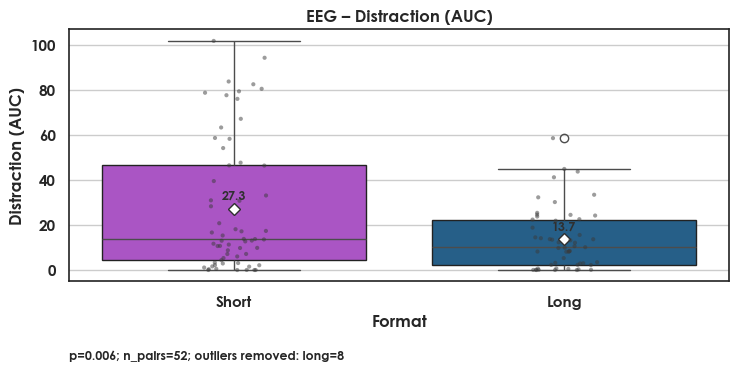

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


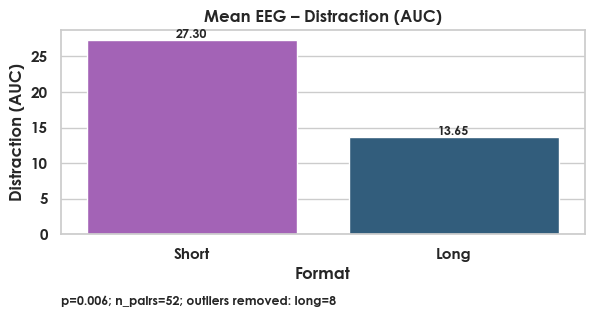

EEG – Distraction (AUC) – Part 1: Long form (14) showed 7 lower than short form (21) (p=0.006, n_pairs=52, outliers removed: long=8).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary  15.876494   15.877193   -0.000699 -0.000134  0.999894   
1            Mad Max   6.537926   33.310293  -26.772366 -3.572251  0.001872   
2           The Town  18.608103   36.190721  -17.582618 -1.966312  0.059138   

   n_long  n_short  
0      21       24  
1      17       19  
2      15       18

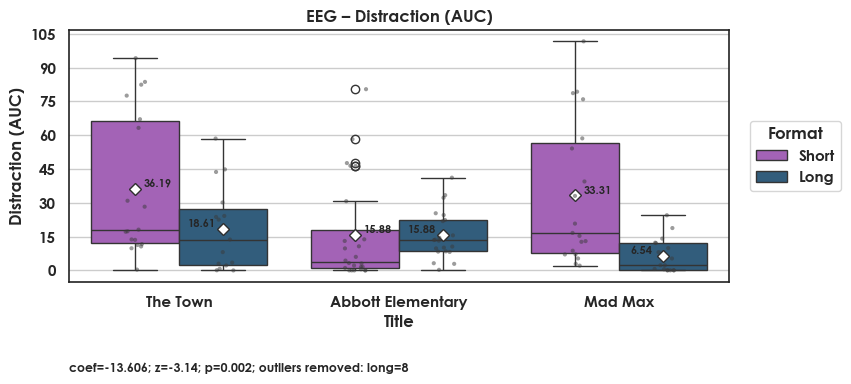

EEG – Distraction (AUC) – Part 2 – Abbott Elementary: Long form (16) showed 0 lower than short form (16) (p=1.000, n_long=21, n_short=24, overall mixed-model p=0.002).
EEG – Distraction (AUC) – Part 2 – Mad Max: Long form (7) showed 27 lower than short form (33) (p=0.002, n_long=17, n_short=19, overall mixed-model p=0.002).
EEG – Distraction (AUC) – Part 2 – The Town: Long form (19) showed 18 lower than short form (36) (p=0.059, n_long=15, n_short=18, overall mixed-model p=0.002).
EEG – Distraction (AUC) – Part 2 (Overall): Long form (14) showed 15 lower than short form (28) (n_long=53, n_short=61, overall mixed-model p=0.002).

Analyzing EEG – Distraction (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.116681    0.125937   -0.009256 -1.145692  0.256795       57

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


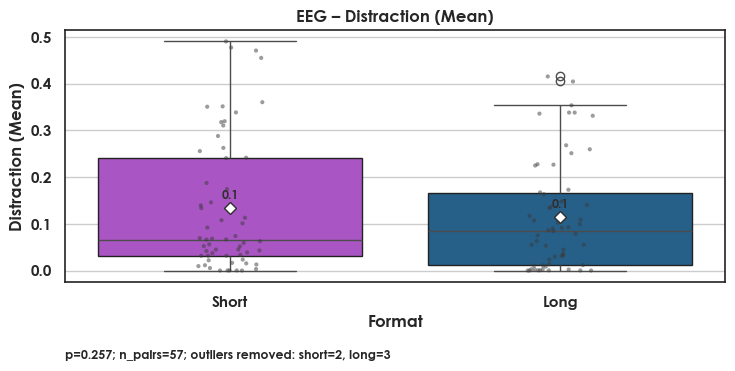

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


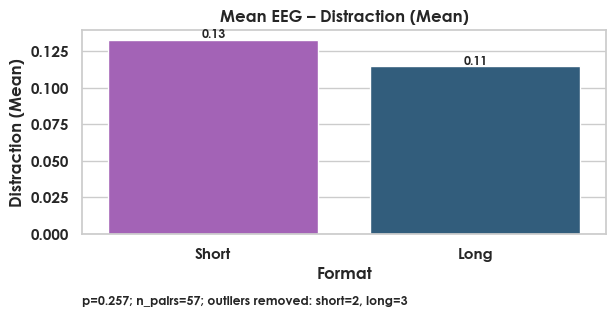

EEG – Distraction (Mean) – Part 1: Long form (0) showed 0 lower than short form (0) (p=0.257, n_pairs=57, outliers removed: short=2, long=3).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.161225    0.112944    0.048282  1.129474  0.266046   
1            Mad Max   0.058864    0.148061   -0.089197 -2.282843  0.029313   
2           The Town   0.119410    0.141376   -0.021965 -0.527301  0.601425   

   n_long  n_short  
0      21       22  
1      19       19  
2      18       18

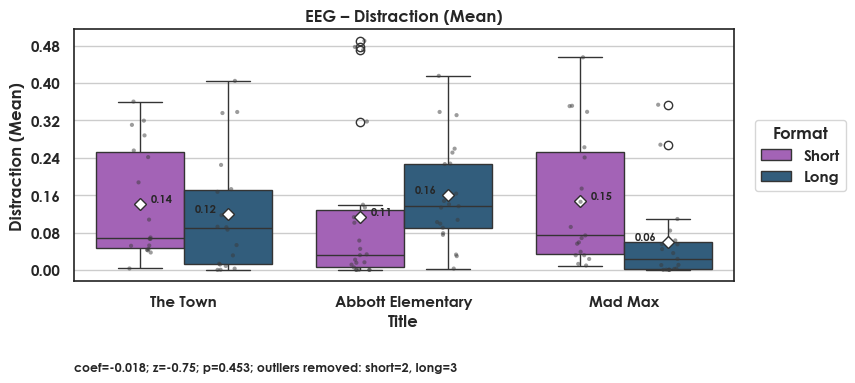

EEG – Distraction (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.266, n_long=21, n_short=22, overall mixed-model p=0.453).
EEG – Distraction (Mean) – Part 2 – Mad Max: Long form (0) showed 0 lower than short form (0) (p=0.029, n_long=19, n_short=19, overall mixed-model p=0.453).
EEG – Distraction (Mean) – Part 2 – The Town: Long form (0) showed 0 lower than short form (0) (p=0.601, n_long=18, n_short=18, overall mixed-model p=0.453).
EEG – Distraction (Mean) – Part 2 (Overall): Long form (0) showed 0 lower than short form (0) (n_long=58, n_short=59, overall mixed-model p=0.453).

Analyzing EEG – Drowsy (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference   t_stat   p_value  n_pairs
0   4.205841    3.608322    0.597518  0.92003  0.361889       52

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


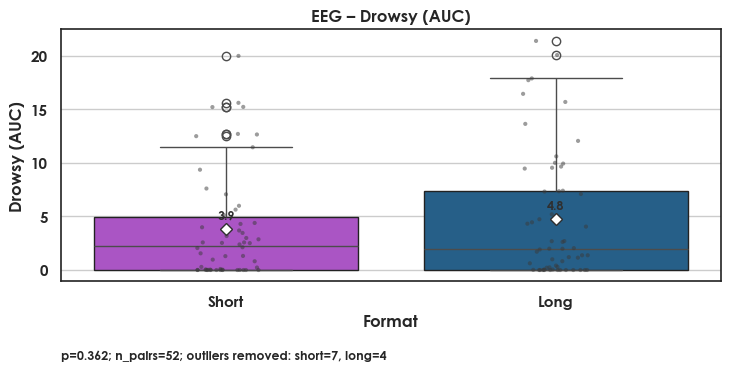

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


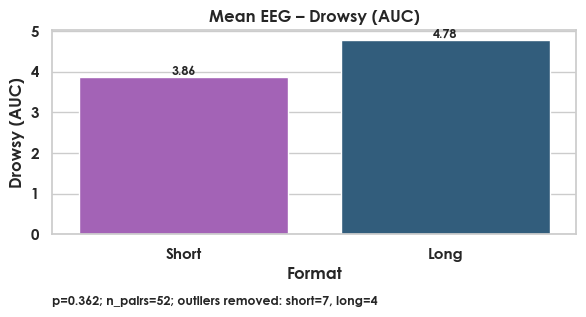

EEG – Drowsy (AUC) – Part 1: Long form (4) showed 1 greater than short form (4) (p=0.362, n_pairs=52, outliers removed: short=7, long=4).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   2.958563    3.570279   -0.611716 -0.454638  0.651724   
1            Mad Max   6.475047    3.255529    3.219518  1.541798  0.134143   
2           The Town   5.279465    5.073753    0.205712  0.097222  0.923203   

   n_long  n_short  
0      21       23  
1      17       17  
2      19       14

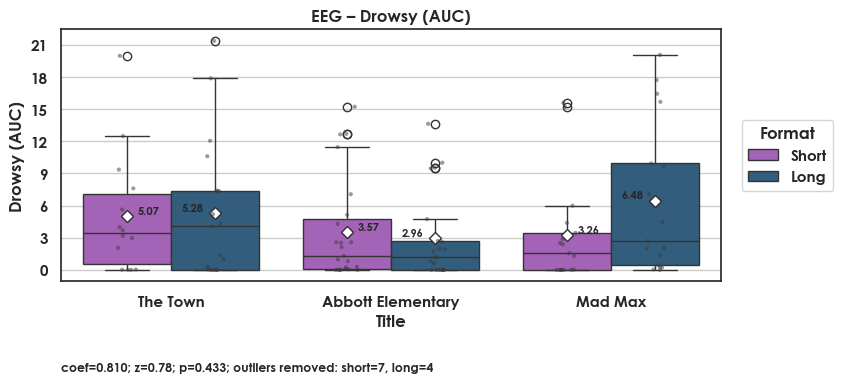

EEG – Drowsy (AUC) – Part 2 – Abbott Elementary: Long form (3) showed 1 lower than short form (4) (p=0.652, n_long=21, n_short=23, overall mixed-model p=0.433).
EEG – Drowsy (AUC) – Part 2 – Mad Max: Long form (6) showed 3 greater than short form (3) (p=0.134, n_long=17, n_short=17, overall mixed-model p=0.433).
EEG – Drowsy (AUC) – Part 2 – The Town: Long form (5) showed 0 greater than short form (5) (p=0.923, n_long=19, n_short=14, overall mixed-model p=0.433).
EEG – Drowsy (AUC) – Part 2 (Overall): Long form (5) showed 1 greater than short form (4) (n_long=57, n_short=54, overall mixed-model p=0.433).

Analyzing EEG – Drowsy (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.021776    0.024287   -0.002512 -0.682785  0.497773       53

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


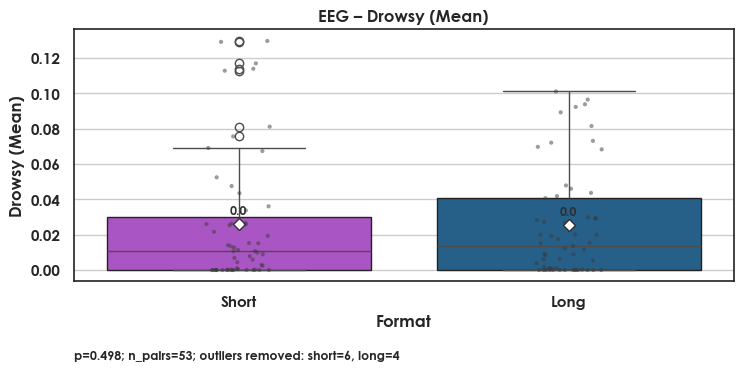

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


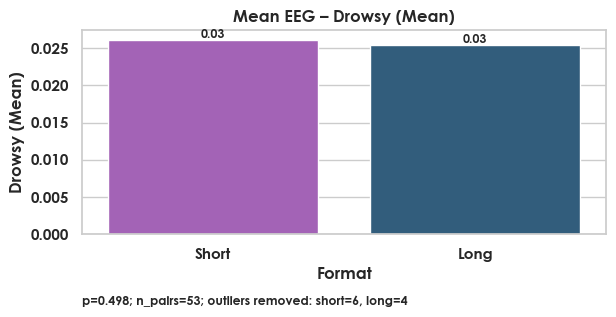

EEG – Drowsy (Mean) – Part 1: Long form (0) showed 0 lower than short form (0) (p=0.498, n_pairs=53, outliers removed: short=6, long=4).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.024350    0.030983   -0.006634 -0.558482  0.579700   
1            Mad Max   0.028279    0.014268    0.014012  1.535788  0.135487   
2           The Town   0.023906    0.031848   -0.007942 -0.686612  0.498128   

   n_long  n_short  
0      20       22  
1      17       17  
2      20       16

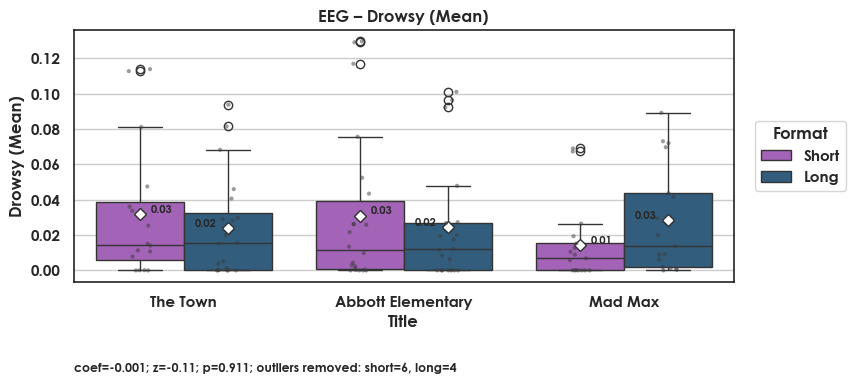

EEG – Drowsy (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 lower than short form (0) (p=0.580, n_long=20, n_short=22, overall mixed-model p=0.911).
EEG – Drowsy (Mean) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (p=0.135, n_long=17, n_short=17, overall mixed-model p=0.911).
EEG – Drowsy (Mean) – Part 2 – The Town: Long form (0) showed 0 lower than short form (0) (p=0.498, n_long=20, n_short=16, overall mixed-model p=0.911).
EEG – Drowsy (Mean) – Part 2 (Overall): Long form (0) showed 0 lower than short form (0) (n_long=57, n_short=55, overall mixed-model p=0.911).

Analyzing EEG – FrontalAlphaAsymmetry (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   2.842587     2.67775    0.164837  0.042496  0.966269       52

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


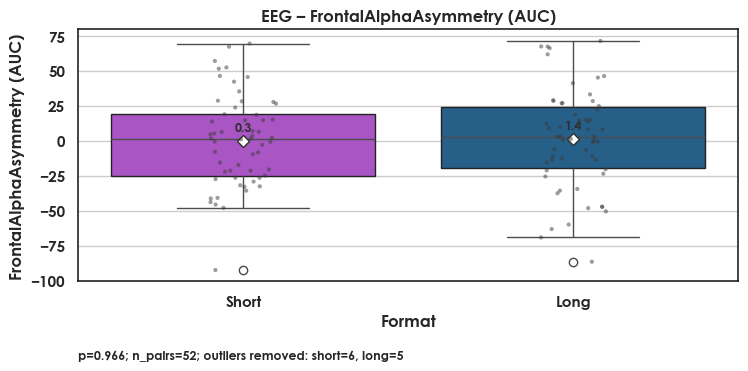

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


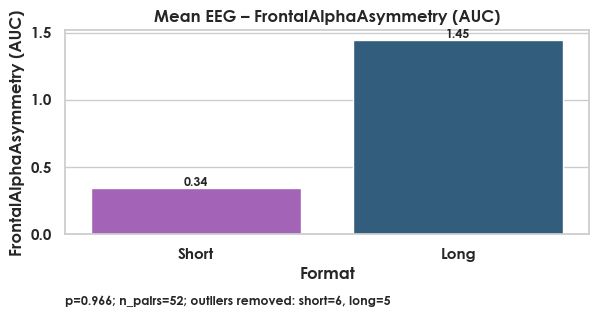

EEG – FrontalAlphaAsymmetry (AUC) – Part 1: Long form (3) showed 0 greater than short form (3) (p=0.966, n_pairs=52, outliers removed: short=6, long=5).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   5.440758   -4.396394    9.837152  1.678689  0.100596   
1            Mad Max   7.631640  -11.233590   18.865229  1.507868  0.141802   
2           The Town -10.637785   16.685438  -27.323223 -1.871794  0.071193   

   n_long  n_short  
0      22       23  
1      19       16  
2      17       18

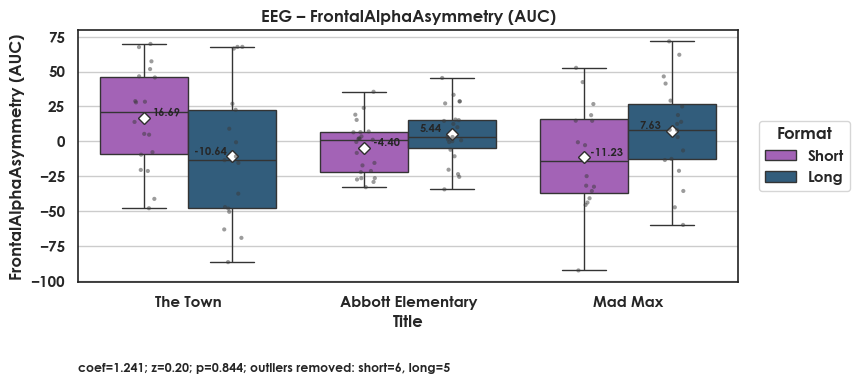

EEG – FrontalAlphaAsymmetry (AUC) – Part 2 – Abbott Elementary: Long form (5) showed 10 greater than short form (-4) (p=0.101, n_long=22, n_short=23, overall mixed-model p=0.844).
EEG – FrontalAlphaAsymmetry (AUC) – Part 2 – Mad Max: Long form (8) showed 19 greater than short form (-11) (p=0.142, n_long=19, n_short=16, overall mixed-model p=0.844).
EEG – FrontalAlphaAsymmetry (AUC) – Part 2 – The Town: Long form (-11) showed 27 lower than short form (17) (p=0.071, n_long=17, n_short=18, overall mixed-model p=0.844).
EEG – FrontalAlphaAsymmetry (AUC) – Part 2 (Overall): Long form (1) showed 0 greater than short form (0) (n_long=58, n_short=57, overall mixed-model p=0.844).

Analyzing EEG – FrontalAlphaAsymmetry (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0  -0.001015   -0.014788    0.013773  0.934178  0.354153       58

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


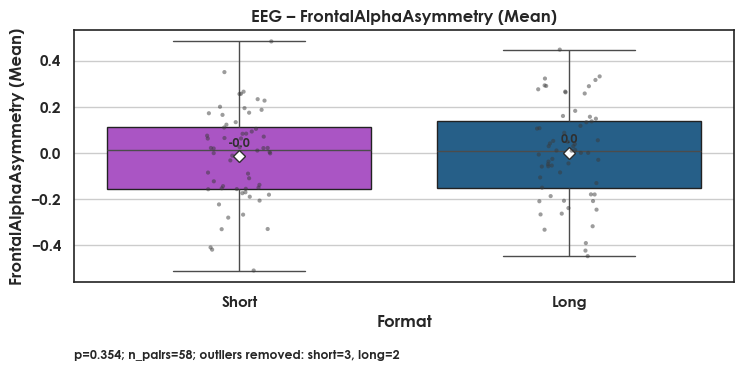

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


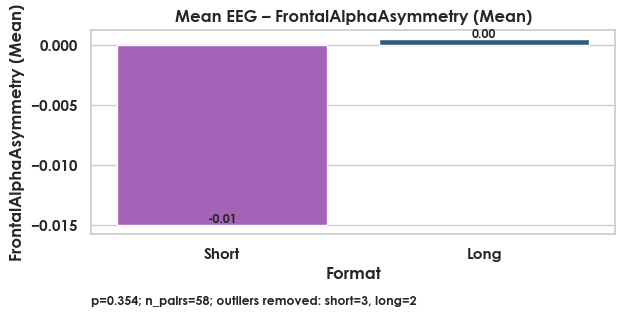

EEG – FrontalAlphaAsymmetry (Mean) – Part 1: Long form (-0) showed 0 greater than short form (-0) (p=0.354, n_pairs=58, outliers removed: short=3, long=2).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.054896   -0.035100    0.089996  1.533750  0.132535   
1            Mad Max   0.014048   -0.045868    0.059916  0.855177  0.398621   
2           The Town  -0.076702    0.038614   -0.115316 -1.827611  0.076168   

   n_long  n_short  
0      22       23  
1      20       18  
2      19       19

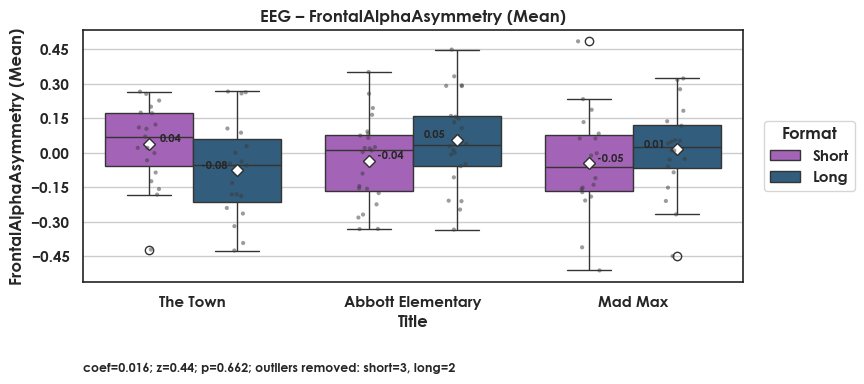

EEG – FrontalAlphaAsymmetry (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (-0) (p=0.133, n_long=22, n_short=23, overall mixed-model p=0.662).
EEG – FrontalAlphaAsymmetry (Mean) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (-0) (p=0.399, n_long=20, n_short=18, overall mixed-model p=0.662).
EEG – FrontalAlphaAsymmetry (Mean) – Part 2 – The Town: Long form (-0) showed 0 lower than short form (0) (p=0.076, n_long=19, n_short=19, overall mixed-model p=0.662).
EEG – FrontalAlphaAsymmetry (Mean) – Part 2 (Overall): Long form (-0) showed 0 greater than short form (-0) (n_long=61, n_short=60, overall mixed-model p=0.662).

Analyzing EEG – HighEngagement (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0  86.424377   81.800736    4.623641  0.538857  0.592013       60

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


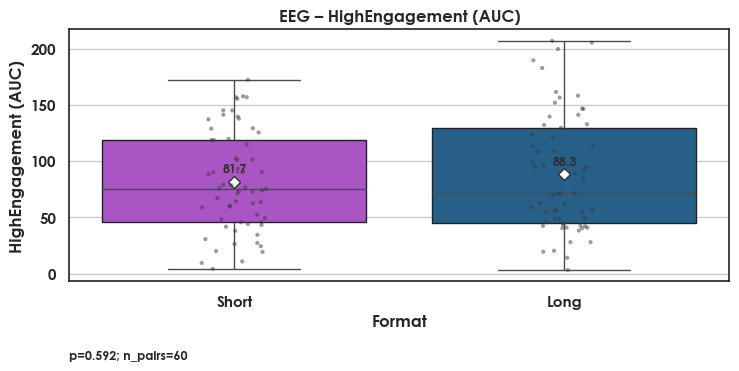

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


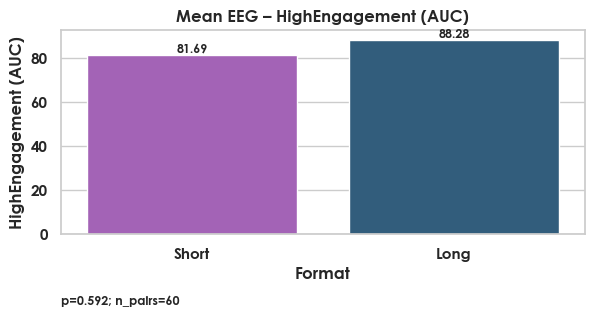

EEG – HighEngagement (AUC) – Part 1: Long form (86) showed 5 greater than short form (82) (p=0.592, n_pairs=60).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title   Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   43.985932   44.138198   -0.152266 -0.029378  0.976723   
1            Mad Max  106.518351  107.243166   -0.724814 -0.049613  0.960735   
2           The Town  116.552782  104.802315   11.750466  0.807573  0.424647   

   n_long  n_short  
0      21       24  
1      20       19  
2      20       18

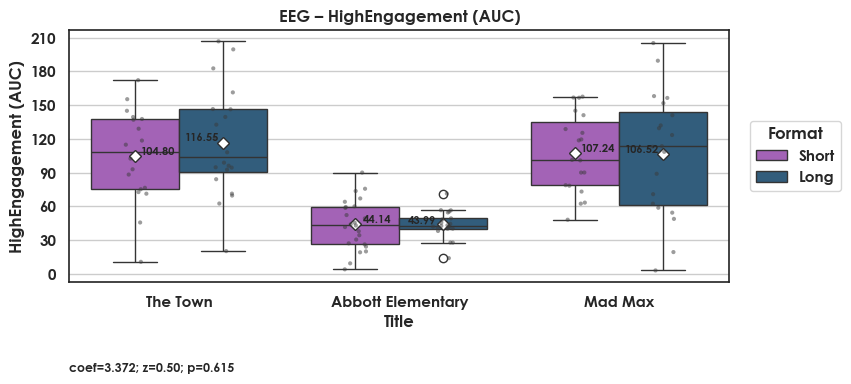

EEG – HighEngagement (AUC) – Part 2 – Abbott Elementary: Long form (44) showed 0 lower than short form (44) (p=0.977, n_long=21, n_short=24, overall mixed-model p=0.615).
EEG – HighEngagement (AUC) – Part 2 – Mad Max: Long form (107) showed 1 lower than short form (107) (p=0.961, n_long=20, n_short=19, overall mixed-model p=0.615).
EEG – HighEngagement (AUC) – Part 2 – The Town: Long form (117) showed 12 greater than short form (105) (p=0.425, n_long=20, n_short=18, overall mixed-model p=0.615).
EEG – HighEngagement (AUC) – Part 2 (Overall): Long form (89) showed 4 greater than short form (85) (n_long=61, n_short=61, overall mixed-model p=0.615).

Analyzing EEG – HighEngagement (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat  p_value  n_pairs
0   0.451461    0.445463    0.005998  0.393688  0.69528       58

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


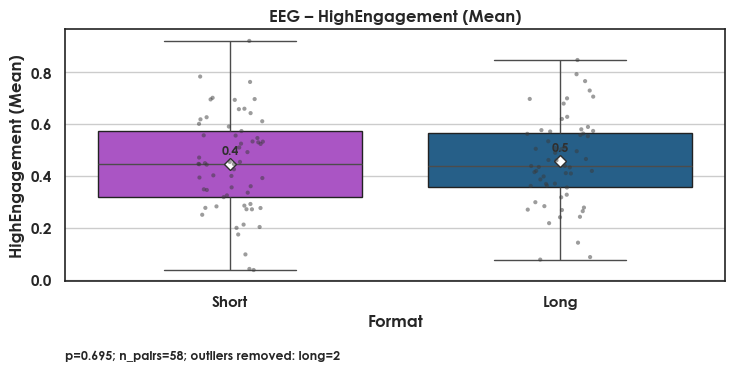

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


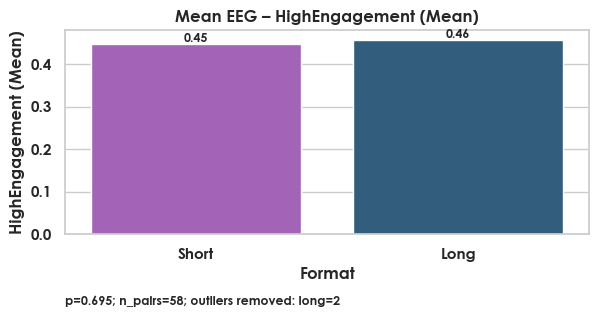

EEG – HighEngagement (Mean) – Part 1: Long form (0) showed 0 greater than short form (0) (p=0.695, n_pairs=58, outliers removed: long=2).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.450064    0.454108   -0.004045 -0.075994  0.939842   
1            Mad Max   0.476820    0.475650    0.001170  0.019412  0.984634   
2           The Town   0.445812    0.409594    0.036218  0.654861  0.516732   

   n_long  n_short  
0      21       24  
1      18       19  
2      20       18

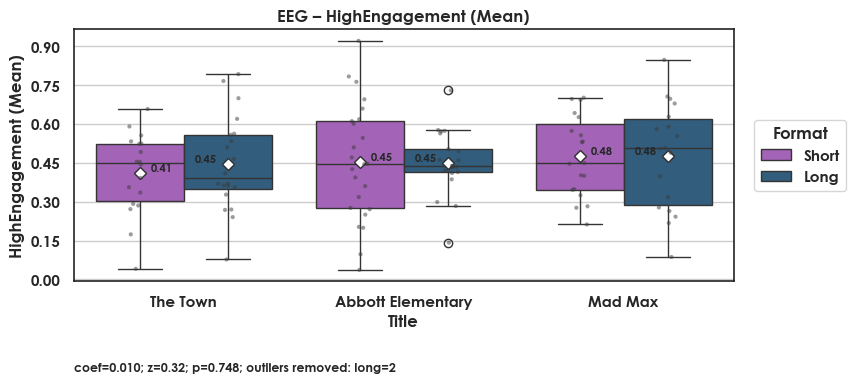

EEG – HighEngagement (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 lower than short form (0) (p=0.940, n_long=21, n_short=24, overall mixed-model p=0.748).
EEG – HighEngagement (Mean) – Part 2 – Mad Max: Long form (0) showed 0 greater than short form (0) (p=0.985, n_long=18, n_short=19, overall mixed-model p=0.748).
EEG – HighEngagement (Mean) – Part 2 – The Town: Long form (0) showed 0 greater than short form (0) (p=0.517, n_long=20, n_short=18, overall mixed-model p=0.748).
EEG – HighEngagement (Mean) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=59, n_short=61, overall mixed-model p=0.748).

Analyzing EEG – LowEngagement (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference   t_stat  p_value  n_pairs
0  68.515607   65.747451    2.768155  0.39196   0.6965       60

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


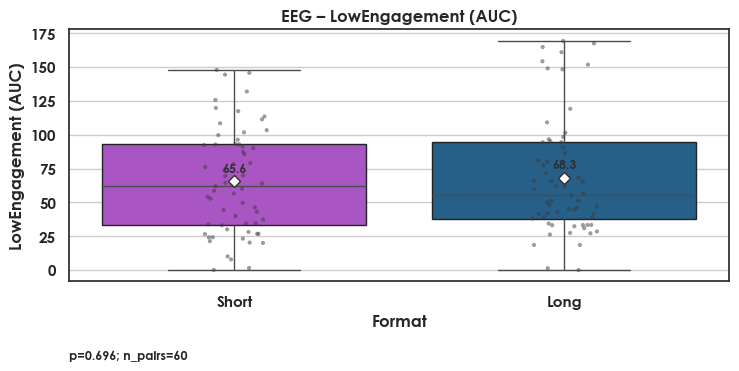

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


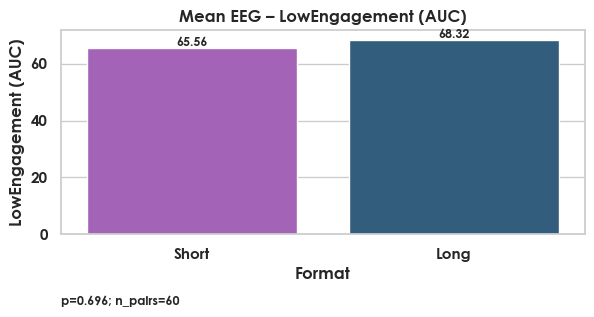

EEG – LowEngagement (AUC) – Part 1: Long form (69) showed 3 greater than short form (66) (p=0.696, n_pairs=60).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary  35.179011   31.672644    3.506367  0.855885  0.397194   
1            Mad Max  78.093384   77.505579    0.587805  0.046814  0.962923   
2           The Town  93.344104   98.121590   -4.777486 -0.395087  0.695338   

   n_long  n_short  
0      21       24  
1      20       19  
2      20       18

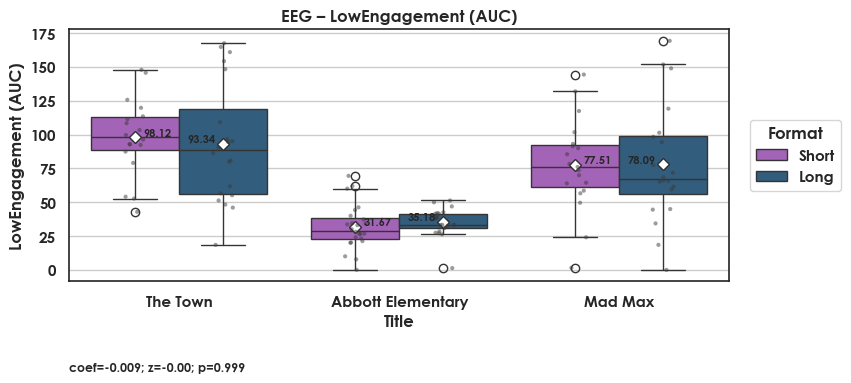

EEG – LowEngagement (AUC) – Part 2 – Abbott Elementary: Long form (35) showed 4 greater than short form (32) (p=0.397, n_long=21, n_short=24, overall mixed-model p=0.999).
EEG – LowEngagement (AUC) – Part 2 – Mad Max: Long form (78) showed 1 greater than short form (78) (p=0.963, n_long=20, n_short=19, overall mixed-model p=0.999).
EEG – LowEngagement (AUC) – Part 2 – The Town: Long form (93) showed 5 lower than short form (98) (p=0.695, n_long=20, n_short=18, overall mixed-model p=0.999).
EEG – LowEngagement (AUC) – Part 2 (Overall): Long form (69) showed 0 lower than short form (69) (n_long=61, n_short=61, overall mixed-model p=0.999).

Analyzing EEG – LowEngagement (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.336123    0.337233   -0.001111 -0.105166  0.916657       52

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


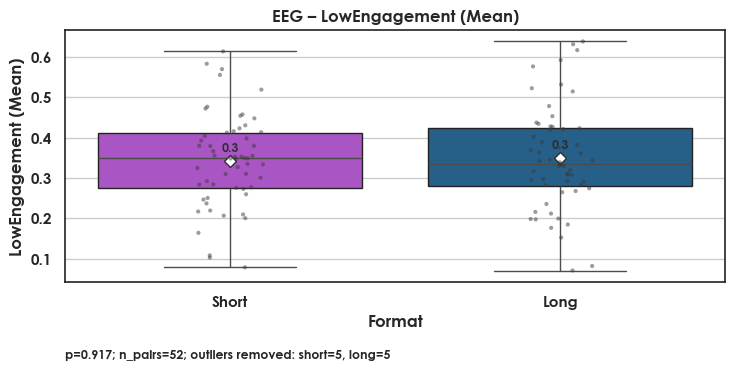

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


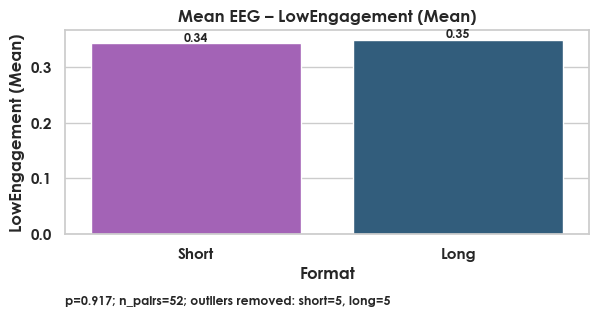

EEG – LowEngagement (Mean) – Part 1: Long form (0) showed 0 lower than short form (0) (p=0.917, n_pairs=52, outliers removed: short=5, long=5).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.376218    0.307874    0.068344  2.161130  0.037903   
1            Mad Max   0.304986    0.345866   -0.040880 -1.013960  0.318512   
2           The Town   0.357658    0.380656   -0.022997 -0.506154  0.616268   

   n_long  n_short  
0      20       21  
1      16       17  
2      20       18

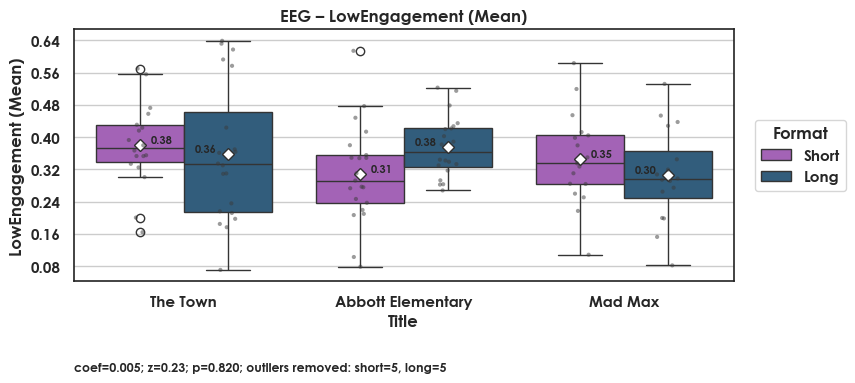

EEG – LowEngagement (Mean) – Part 2 – Abbott Elementary: Long form (0) showed 0 greater than short form (0) (p=0.038, n_long=20, n_short=21, overall mixed-model p=0.820).
EEG – LowEngagement (Mean) – Part 2 – Mad Max: Long form (0) showed 0 lower than short form (0) (p=0.319, n_long=16, n_short=17, overall mixed-model p=0.820).
EEG – LowEngagement (Mean) – Part 2 – The Town: Long form (0) showed 0 lower than short form (0) (p=0.616, n_long=20, n_short=18, overall mixed-model p=0.820).
EEG – LowEngagement (Mean) – Part 2 (Overall): Long form (0) showed 0 greater than short form (0) (n_long=56, n_short=56, overall mixed-model p=0.820).

Analyzing EEG – Workload (AUC)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0  103.149427   98.790323    4.359104  0.475174  0.636417       60

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


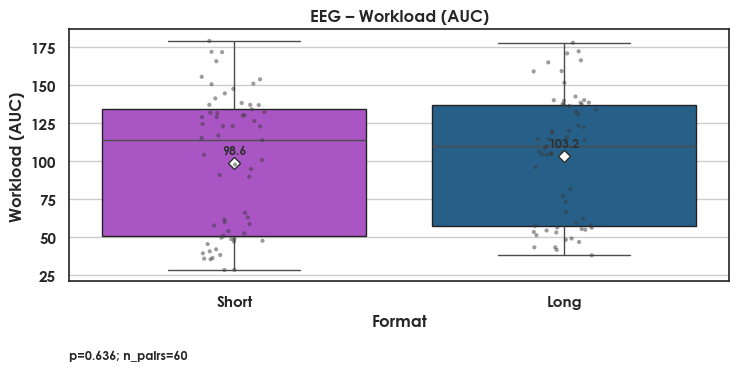

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


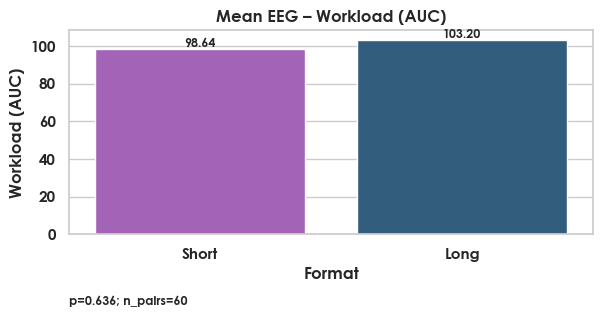

EEG – Workload (AUC) – Part 1: Long form (103) showed 4 greater than short form (99) (p=0.636, n_pairs=60).


Title   Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   53.498504   47.420672    6.077833  2.135372  0.038529   
1            Mad Max  120.872359  126.392237   -5.519878 -0.799731  0.429002   
2           The Town  137.725034  137.649010    0.076024  0.010033  0.992051   

   n_long  n_short  
0      21       24  
1      20       19  
2      20       18

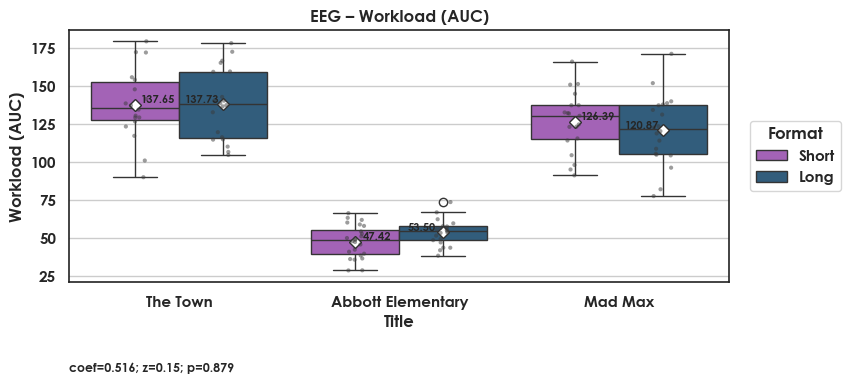

EEG – Workload (AUC) – Part 2 – Abbott Elementary: Long form (53) showed 6 greater than short form (47) (p=0.039, n_long=21, n_short=24, overall mixed-model p=0.879).
EEG – Workload (AUC) – Part 2 – Mad Max: Long form (121) showed 6 lower than short form (126) (p=0.429, n_long=20, n_short=19, overall mixed-model p=0.879).
EEG – Workload (AUC) – Part 2 – The Town: Long form (138) showed 0 greater than short form (138) (p=0.992, n_long=20, n_short=18, overall mixed-model p=0.879).
EEG – Workload (AUC) – Part 2 (Overall): Long form (104) showed 0 greater than short form (104) (n_long=61, n_short=61, overall mixed-model p=0.879).

Analyzing EEG – Workload (Mean)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0   0.544818    0.535018      0.0098  1.631438  0.108217       59

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


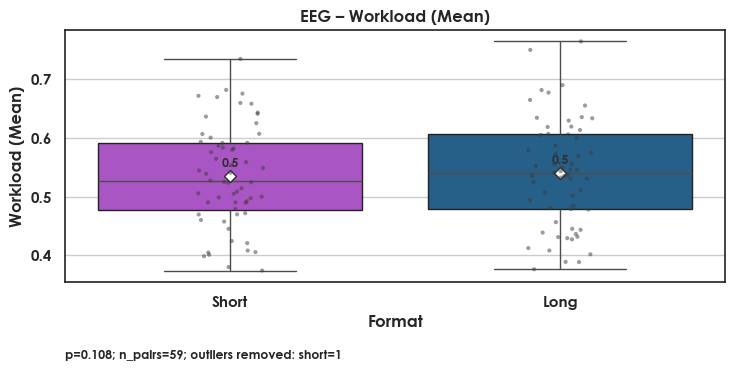

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


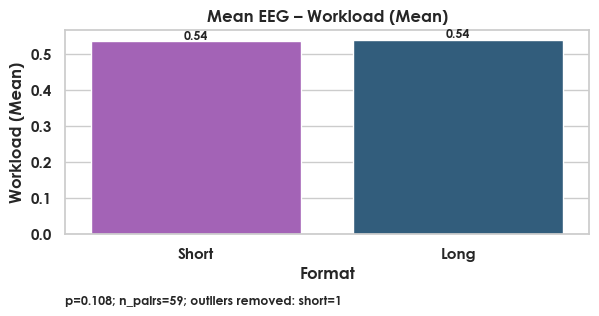

EEG – Workload (Mean) – Part 1: Long form (1) showed 0 greater than short form (1) (p=0.108, n_pairs=59, outliers removed: short=1).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary   0.549130    0.514413    0.034717  1.293404  0.202991   
1            Mad Max   0.541123    0.559676   -0.018553 -0.613549  0.543271   
2           The Town   0.528956    0.535639   -0.006683 -0.249350  0.804517   

   n_long  n_short  
0      21       23  
1      20       19  
2      20       18

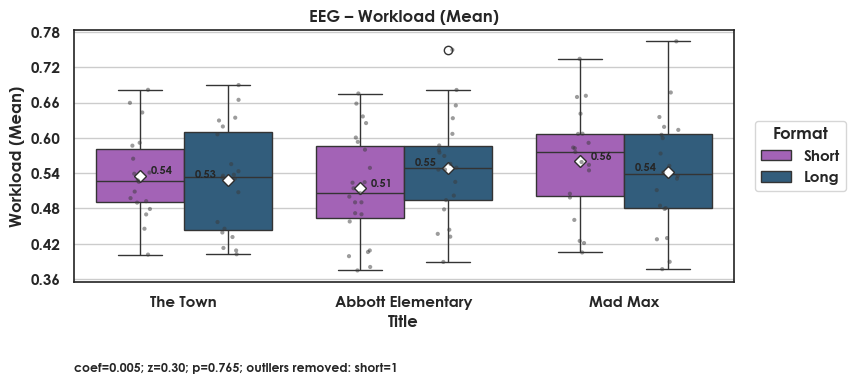

EEG – Workload (Mean) – Part 2 – Abbott Elementary: Long form (1) showed 0 greater than short form (1) (p=0.203, n_long=21, n_short=23, overall mixed-model p=0.765).
EEG – Workload (Mean) – Part 2 – Mad Max: Long form (1) showed 0 lower than short form (1) (p=0.543, n_long=20, n_short=19, overall mixed-model p=0.765).
EEG – Workload (Mean) – Part 2 – The Town: Long form (1) showed 0 lower than short form (1) (p=0.805, n_long=20, n_short=18, overall mixed-model p=0.765).
EEG – Workload (Mean) – Part 2 (Overall): Long form (1) showed 0 greater than short form (1) (n_long=61, n_short=60, overall mixed-model p=0.765).

##########################################################################################
Running analyses for sensor: FAC_EMOTION
##########################################################################################

Analyzing FAC_EMOTION – EmotionComposite (AUC_SUM)


C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  frame.pivot_table(index=id_col, columns=form_col, values=value_col, aggfunc="mean")


Long mean  Short mean  Difference    t_stat   p_value  n_pairs
0  12.879258    6.078461    6.800797  3.143065  0.002549       64

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{form}" for form in FORM_ORDER])


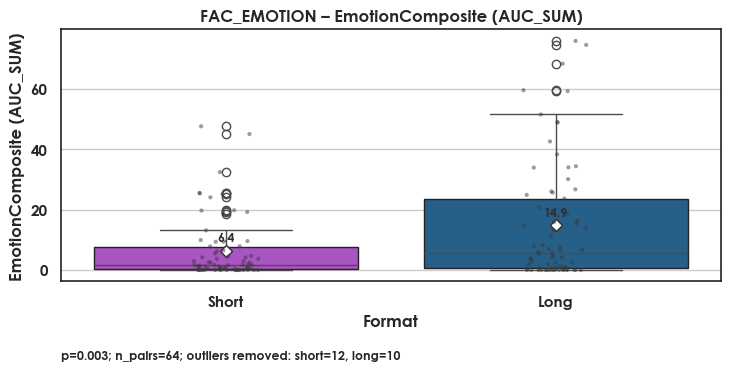

C:\Users\ashra\AppData\Local\Temp\ipykernel_38052\599052837.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="mean_value", order=FORM_ORDER, palette=palette, ax=ax_bar)


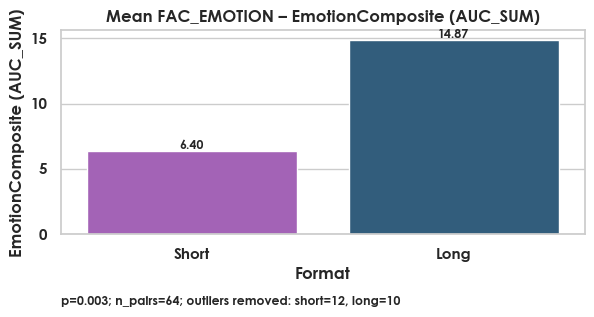

FAC_EMOTION – EmotionComposite (AUC_SUM) – Part 1: Long form (13) showed 7 greater than short form (6) (p=0.003, n_pairs=64, outliers removed: short=12, long=10).


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

Title  Long mean  Short mean  Difference    t_stat   p_value  \
0  Abbott Elementary  25.038442     7.58244   17.456002  3.527407  0.001119   
1            Mad Max   6.594024     4.66496    1.929064  0.675196  0.504077   
2           The Town  11.381577     7.10330    4.278277  0.934562  0.355291   

   n_long  n_short  
0      26       25  
1      21       25  
2      26       20

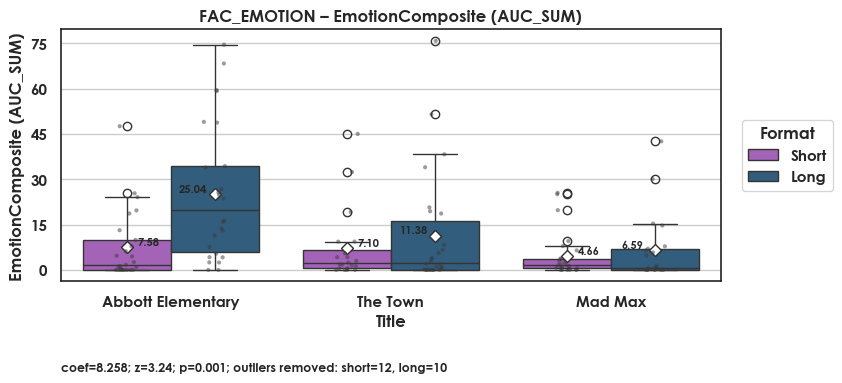

FAC_EMOTION – EmotionComposite (AUC_SUM) – Part 2 – Abbott Elementary: Long form (25) showed 17 greater than short form (8) (p=0.001, n_long=26, n_short=25, overall mixed-model p=0.001).
FAC_EMOTION – EmotionComposite (AUC_SUM) – Part 2 – Mad Max: Long form (7) showed 2 greater than short form (5) (p=0.504, n_long=21, n_short=25, overall mixed-model p=0.001).
FAC_EMOTION – EmotionComposite (AUC_SUM) – Part 2 – The Town: Long form (11) showed 4 greater than short form (7) (p=0.355, n_long=26, n_short=20, overall mixed-model p=0.001).
FAC_EMOTION – EmotionComposite (AUC_SUM) – Part 2 (Overall): Long form (14) showed 8 greater than short form (6) (n_long=73, n_short=70, overall mixed-model p=0.001).


In [ ]:
sensors = biometric_long["sensor"].dropna().unique().tolist()
for sensor in sensors:
    print("\n" + "#" * 90)
    print(f"Running analyses for sensor: {sensor}")
    print("#" * 90)
    analyze_sensor(sensor)

## Export Summary Tables
Aggregate Part 1 and Part 2 summaries plus per-title post-hoc comparisons into CSV outputs.

In [ ]:
summary_tables_df = pd.DataFrame(SUMMARY_TABLE_RECORDS)
posthoc_tables_df = pd.DataFrame(POSTHOC_TABLE_RECORDS)

if summary_tables_df.empty:
    print("No Part 1/Part 2 summary records were captured. Run the sensor analyses first.")
else:
    summary_tables_df = summary_tables_df.sort_values(
        ["sensor", "metric", "stat", "part"],
        kind="stable",
    ).reset_index(drop=True)
    summary_export_path = RESULTS_PATH / "biometric_part_summary.csv"
    summary_tables_df.to_csv(summary_export_path, index=False)
    display(summary_tables_df.head())
    print(f"Summary tables exported to {summary_export_path}")

if posthoc_tables_df.empty:
    print("No post-hoc title comparisons were captured. Run the sensor analyses first.")
else:
    posthoc_tables_df = posthoc_tables_df.sort_values(
        ["sensor", "metric", "stat", "title"],
        kind="stable",
    ).reset_index(drop=True)
    posthoc_export_path = RESULTS_PATH / "biometric_posthoc_results.csv"
    posthoc_tables_df.to_csv(posthoc_export_path, index=False)
    display(posthoc_tables_df.head())
    print(f"Post-hoc results exported to {posthoc_export_path}")

part sensor       metric  stat  long_mean  short_mean  difference  \
0  Part 1    EEG  Distraction   AUC  13.903122   21.402778   -7.499656   
1  Part 2    EEG  Distraction   AUC  13.654201   27.301331  -13.647129   
2  Part 1    EEG  Distraction  Mean   0.116681    0.125937   -0.009256   
3  Part 2    EEG  Distraction  Mean   0.114716    0.132927   -0.018211   
4  Part 1    EEG       Drowsy   AUC   4.205841    3.608322    0.597518   

     t_stat   p_value  n_pairs  removed_short  removed_long       coef  \
0 -2.847114  0.006342     52.0              0             8        NaN   
1       NaN  0.001711      NaN              0             8 -13.605510   
2 -1.145692  0.256795     57.0              2             3        NaN   
3       NaN  0.453079      NaN              2             3  -0.017997   
4  0.920030  0.361889     52.0              7             4        NaN   

    z_value  n_titles  n_observations  n_long  n_short  
0       NaN       NaN             NaN     NaN      NaN  
1 -3.136220       3.0           114.0    53.0     61.0  
2       NaN       NaN             NaN     NaN      NaN  
3 -0.750292       3.0           117.0    58.0     59.0  
4       NaN       NaN             NaN     NaN      NaN

Summary tables exported to C:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\biometric_part_summary.csv


part sensor       metric  stat              title  long_mean  short_mean  \
0  Part 2    EEG  Distraction   AUC  Abbott Elementary  15.876494   15.877193   
1  Part 2    EEG  Distraction   AUC            Mad Max   6.537926   33.310293   
2  Part 2    EEG  Distraction   AUC           The Town  18.608103   36.190721   
3  Part 2    EEG  Distraction  Mean  Abbott Elementary   0.161225    0.112944   
4  Part 2    EEG  Distraction  Mean            Mad Max   0.058864    0.148061   

   difference    t_stat   p_value  n_long  n_short  overall_p_value  
0   -0.000699 -0.000134  0.999894      21       24         0.001711  
1  -26.772366 -3.572251  0.001872      17       19         0.001711  
2  -17.582618 -1.966312  0.059138      15       18         0.001711  
3    0.048282  1.129474  0.266046      21       22         0.453079  
4   -0.089197 -2.282843  0.029313      19       19         0.453079

Post-hoc results exported to C:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\biometric_posthoc_results.csv


## Export Markdown Summary
Summarise Part 1/Part 2 findings into a lightweight report.

In [ ]:
summary_tables_df = pd.DataFrame(SUMMARY_TABLE_RECORDS)
posthoc_tables_df = pd.DataFrame(POSTHOC_TABLE_RECORDS)

if summary_tables_df.empty and posthoc_tables_df.empty:
    print("No summary or post-hoc records were captured. Run the sensor analyses first.")
else:
    markdown_lines: List[str] = ["# Biometric Format Summary", ""]
    sensor_sections = set()

    if not summary_tables_df.empty:
        summary_sorted = summary_tables_df.sort_values(
            ["sensor", "metric", "stat", "part"],
            kind="stable",
        )
        current_sensor = None
        for (sensor_name, metric_name, stat_name), group in summary_sorted.groupby(
            ["sensor", "metric", "stat"], sort=False
        ):
            if sensor_name != current_sensor:
                if current_sensor is not None:
                    markdown_lines.append("")
                markdown_lines.append(f"## {sensor_name}")
                markdown_lines.append("")
                sensor_sections.add(sensor_name)
                current_sensor = sensor_name

            label = f"{metric_name} ({stat_name})"

            part1_row = group.loc[group["part"] == "Part 1"]
            if not part1_row.empty:
                row = part1_row.iloc[0]
                bits: List[str] = []
                long_mean = row.get("long_mean")
                short_mean = row.get("short_mean")
                diff_value = row.get("difference")
                p_value = row.get("p_value")
                n_pairs = row.get("n_pairs")
                removed_short = row.get("removed_short")
                removed_long = row.get("removed_long")

                if pd.notna(long_mean):
                    bits.append(f"Long={_format_mean(long_mean, decimals=2)}")
                if pd.notna(short_mean):
                    bits.append(f"Short={_format_mean(short_mean, decimals=2)}")
                if pd.notna(diff_value):
                    bits.append(f"diff={_format_mean(diff_value, decimals=2)}")
                if isinstance(p_value, (int, float)) and np.isfinite(p_value):
                    bits.append(format_p_value(p_value))
                if pd.notna(n_pairs):
                    bits.append(f"n_pairs={int(n_pairs)}")

                outlier_notes: List[str] = []
                if isinstance(removed_short, (int, float)) and pd.notna(removed_short) and int(removed_short) > 0:
                    outlier_notes.append(f"short={int(removed_short)}")
                if isinstance(removed_long, (int, float)) and pd.notna(removed_long) and int(removed_long) > 0:
                    outlier_notes.append(f"long={int(removed_long)}")
                if outlier_notes:
                    bits.append("outliers removed " + ", ".join(outlier_notes))

                markdown_lines.append(f"- {label} Part 1: " + ", ".join(bits))

            part2_row = group.loc[group["part"] == "Part 2"]
            if not part2_row.empty:
                row = part2_row.iloc[0]
                bits = []
                long_mean = row.get("long_mean")
                short_mean = row.get("short_mean")
                diff_value = row.get("difference")
                coef = row.get("coef")
                z_value = row.get("z_value")
                p_value = row.get("p_value")
                n_titles = row.get("n_titles")
                n_observations = row.get("n_observations")
                n_long = row.get("n_long")
                n_short = row.get("n_short")
                removed_short = row.get("removed_short")
                removed_long = row.get("removed_long")

                if pd.notna(long_mean):
                    bits.append(f"Long={_format_mean(long_mean, decimals=2)}")
                if pd.notna(short_mean):
                    bits.append(f"Short={_format_mean(short_mean, decimals=2)}")
                if pd.notna(diff_value):
                    bits.append(f"diff={_format_mean(diff_value, decimals=2)}")
                if isinstance(coef, (int, float)) and np.isfinite(coef):
                    bits.append(f"coef={coef:.3f}")
                if isinstance(z_value, (int, float)) and np.isfinite(z_value):
                    bits.append(f"z={z_value:.2f}")
                if isinstance(p_value, (int, float)) and np.isfinite(p_value):
                    bits.append(format_p_value(p_value))
                if pd.notna(n_titles):
                    bits.append(f"titles={int(n_titles)}")
                if pd.notna(n_observations):
                    bits.append(f"obs={int(n_observations)}")
                if pd.notna(n_long):
                    bits.append(f"n_long={int(n_long)}")
                if pd.notna(n_short):
                    bits.append(f"n_short={int(n_short)}")

                outlier_notes = []
                if isinstance(removed_short, (int, float)) and pd.notna(removed_short) and int(removed_short) > 0:
                    outlier_notes.append(f"short={int(removed_short)}")
                if isinstance(removed_long, (int, float)) and pd.notna(removed_long) and int(removed_long) > 0:
                    outlier_notes.append(f"long={int(removed_long)}")
                if outlier_notes:
                    bits.append("outliers removed " + ", ".join(outlier_notes))

                markdown_lines.append(f"- {label} Part 2 Overall: " + ", ".join(bits))

    if not posthoc_tables_df.empty:
        posthoc_sorted = posthoc_tables_df.sort_values(
            ["sensor", "metric", "stat", "title"],
            kind="stable",
        )
        for (sensor_name, metric_name, stat_name), group in posthoc_sorted.groupby(
            ["sensor", "metric", "stat"], sort=False
        ):
            if sensor_name not in sensor_sections:
                markdown_lines.append("")
                markdown_lines.append(f"## {sensor_name}")
                markdown_lines.append("")
                sensor_sections.add(sensor_name)

            label = f"{metric_name} ({stat_name})"
            for _, row in group.iterrows():
                bits = []
                long_mean = row.get("long_mean")
                short_mean = row.get("short_mean")
                diff_value = row.get("difference")
                p_value = row.get("p_value")
                n_long = row.get("n_long")
                n_short = row.get("n_short")

                if pd.notna(long_mean):
                    bits.append(f"Long={_format_mean(long_mean, decimals=2)}")
                if pd.notna(short_mean):
                    bits.append(f"Short={_format_mean(short_mean, decimals=2)}")
                if pd.notna(diff_value):
                    bits.append(f"diff={_format_mean(diff_value, decimals=2)}")
                if isinstance(p_value, (int, float)) and np.isfinite(p_value):
                    bits.append(format_p_value(p_value))
                if pd.notna(n_long):
                    bits.append(f"n_long={int(n_long)}")
                if pd.notna(n_short):
                    bits.append(f"n_short={int(n_short)}")

                markdown_lines.append(
                    f"- {label} Part 2 – {row['title']}: " + ", ".join(bits)
                )

    markdown_text = "\n".join(markdown_lines)
    markdown_path = RESULTS_PATH / "biometric_summary_report.md"
    markdown_path.write_text(markdown_text, encoding="utf-8")
    print(f"Markdown summary exported to {markdown_path}")
    print("Preview of first 12 lines:")
    for line in markdown_lines[:12]:
        print(line)

Markdown summary exported to C:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\biometric_summary_report.md
Preview of first 12 lines:
# Biometric Format Summary

## EEG

- Distraction (AUC) Part 1: Long=13.90, Short=21.40, diff=-7.50, p=0.006, n_pairs=52
- Distraction (AUC) Part 2 Overall: Long=13.65, Short=27.30, diff=-13.65, coef=-13.606, z=-3.14, p=0.002, titles=3, obs=114, n_long=53, n_short=61
- Distraction (Mean) Part 1: Long=0.12, Short=0.13, diff=-0.01, p=0.257, n_pairs=57
- Distraction (Mean) Part 2 Overall: Long=0.11, Short=0.13, diff=-0.02, coef=-0.018, z=-0.75, p=0.453, titles=3, obs=117, n_long=58, n_short=59
- Drowsy (AUC) Part 1: Long=4.21, Short=3.61, diff=0.60, p=0.362, n_pairs=52
- Drowsy (AUC) Part 2 Overall: Long=4.78, Short=3.86, diff=0.92, coef=0.810, z=0.78, p=0.433, titles=3, obs=111, n_long=57, n_short=54
- Drowsy (Mean) Part 1: Long=0.02, Short=0.02, diff=-0.00, p=0.498, n_pairs=53
- Drowsy (Mean) Part 2 Overall: Long=0.03, Short=0.0